# Neural Network for Regression (LMA features to P,A coordinates)

## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

from sklearn.model_selection import RepeatedKFold

2022-03-10 19:51:17.745214: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-10 19:51:17.745282: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Load Data

In [2]:
#dataset = pd.read_csv('datasets/pa/LMA_DATA.csv')
#dataset = pd.read_csv('datasets/pa/Fs_B_LMA_DATA.csv')

dataset = pd.read_csv('datasets/pa/Fs_LMA_DATA_EXTRA.csv')

### Split into Test and Train data

In [3]:
train_dataset = dataset.sample(frac=0.8, random_state=42)
test_dataset = dataset.drop(train_dataset.index)

print("No Training Samples:",train_dataset.shape[0])
print("No Test Samples:",test_dataset.shape[0])

No Training Samples: 45087
No Test Samples: 11272


### Split Features from Targets

In [4]:
train_X = train_dataset.copy()
test_X = test_dataset.copy()

train_y = pd.concat([train_X.pop(x) for x in ['EMOTION_P', 'EMOTION_A']], axis=1)
test_y = pd.concat([test_X.pop(x) for x in ['EMOTION_P', 'EMOTION_A']], axis=1)

In [5]:
train_X.head()

,avg_hand_distance,avg_l_hand_hip_distance,avg_r_hand_hip_distance,avg_feet_distance,avg_l_hand_chest_distance,avg_r_hand_chest_distance,avg_l_elbow_hip_distance,avg_r_elbow_hip_distance,avg_chest_pelvis_distance,avg_neck_chest_distance,...,avg_pelvis_velocity_y,avg_pelvis_velocity_z,avg_l_foot_velocity_x,avg_l_foot_velocity_y,avg_l_foot_velocity_z,avg_r_foot_velocity_x,avg_r_foot_velocity_y,avg_r_foot_velocity_z,avg_upper_body_volume,avg_distance_traveled
5770,0.380282,0.661481,0.693188,0.369381,0.480609,0.458428,0.432211,0.406739,0.286151,0.278481,...,-0.032571,0.463787,0.008890,0.521765,-0.203105,0.008890,0.521765,-0.203105,0.051152,0.004335
20189,0.760466,0.506470,0.499213,0.280216,0.567541,0.307238,0.443042,0.275669,0.286151,0.278833,...,0.148304,-0.986957,0.107026,-0.060120,0.487608,0.107026,-0.060120,0.487608,0.043785,0.010320
55768,0.580429,0.168741,0.465727,0.278130,0.418851,0.543607,0.287841,0.427787,0.286151,0.267957,...,0.055718,-0.386061,-0.208628,1.608111,1.892997,-0.512417,-0.950072,-0.566143,0.027890,0.002431
5563,0.473783,0.286455,0.248704,0.449423,0.480491,0.461131,0.361082,0.343791,0.286151,0.278724,...,0.286956,0.203860,-0.085325,0.126640,0.158180,-0.085325,0.126640,0.158180,0.030401,0.002548
53047,0.815654,0.545759,0.515166,0.417240,0.429151,0.430379,0.412061,0.387947,0.286151,0.277062,...,-0.268965,0.362865,-0.787257,1.232325,1.885969,0.323288,0.566038,-2.243664,0.055453,0.003610


In [6]:
train_y.head()

,EMOTION_P,EMOTION_A
5770,-0.35,0.7
20189,-0.35,0.7
55768,-0.85,-0.1
5563,-0.50,0.6
53047,0.50,0.7


In [7]:
train_X.describe().transpose()[['mean', 'std']]

,mean,std
avg_hand_distance,0.529250,2.858826e-01
avg_l_hand_hip_distance,0.368487,1.767053e-01
avg_r_hand_hip_distance,0.384095,1.830527e-01
avg_feet_distance,0.338780,1.578916e-01
avg_l_hand_chest_distance,0.433375,1.218224e-01
avg_r_hand_chest_distance,0.435605,1.203586e-01
avg_l_elbow_hip_distance,0.342878,8.884460e-02
avg_r_elbow_hip_distance,0.348284,8.796934e-02
avg_chest_pelvis_distance,0.286151,7.207276e-10
avg_neck_chest_distance,0.277053,3.783007e-03


### Normalize Data

In [8]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_X))

2022-03-10 19:51:57.070678: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-10 19:51:57.070951: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-10 19:51:57.071045: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-03-10 19:51:57.071113: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-03-10 19:51:57.071209: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

In [9]:
print(normalizer.mean.numpy())

[[ 5.2924943e-01  3.6848739e-01  3.8409463e-01  3.3877978e-01
   4.3337458e-01  4.3560424e-01  3.4287751e-01  3.4828344e-01
   2.8615117e-01  2.7705243e-01 -6.5531838e-03 -4.4965312e-02
  -7.3787861e-02  8.8189656e-01 -8.5787745e-03 -4.5807511e-02
  -6.7394182e-02  8.8892668e-01  9.4655275e-01  9.7657913e-01
   2.8861398e-02  3.2204371e-02  5.8395267e-03 -2.1922518e-03
   2.8645722e-03  1.2742929e-02  3.5076356e-04 -7.9521555e-03
   3.8666967e-03 -1.4228471e-02 -2.3128937e-03  3.5810597e-02
   3.1155969e-03]]


In [10]:
first = np.array(train_X[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[ 0.38  0.66  0.69  0.37  0.48  0.46  0.43  0.41  0.29  0.28  0.23 -0.27
  -0.03  0.94  0.17 -0.28 -0.03  0.94  0.67  0.86  0.34  0.17 -0.06 -0.03
   0.46  0.01  0.52 -0.2   0.01  0.52 -0.2   0.05  0.  ]]

Normalized: [[-0.52  1.66  1.69  0.19  0.39  0.19  1.01  0.66 -0.6   0.38  2.1  -0.68
   0.27  0.21  2.06 -0.71  0.31  0.22 -0.29 -0.12  0.18  0.08 -0.17 -0.12
   1.29 -0.    0.51 -0.17  0.01  0.5  -0.17  1.19  0.34]]


## Create Model

### Define Model Layers

In [11]:
# "Usually it's a good practice to apply following formula in order to find out the total number of hidden layers needed." - https://stackoverflow.com/questions/49008074/how-to-create-a-neural-network-for-regression

# Nh = Ns/(α∗ (Ni + No))
# where:
#      Ni = number of input neurons.
#      No = number of output neurons.
#      Ns = number of samples in training data set.
#      α = an arbitrary scaling factor usually 2-10.
 
# Nh = 34431 / (5 * (29 + 2)) +-= 230

def build_and_compile_model(norm):
    model = keras.Sequential([
                norm,
        
                layers.Dense(32, activation='relu'),
                layers.Dense(64, activation='relu'),
                layers.Dense(32, activation='relu'),
        
                layers.Dense(2)
            ])

    
    model.compile(loss='mean_absolute_error',optimizer='adam') # Using MAE
    #model.compile(loss='mean_squared_error', optimizer='adam') # Using MSE
    
    return model

### Build Model

In [12]:
model = build_and_compile_model(normalizer)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 33)               67        
 n)                                                              
                                                                 
 dense (Dense)               (None, 32)                1088      
                                                                 
 dense_1 (Dense)             (None, 64)                2112      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 2)                 66        
                                                                 
Total params: 5,413
Trainable params: 5,346
Non-trainable params: 67
_____________________________________________________

## Train Model

In [13]:
%%time
history = model.fit(
    train_X,
    train_y,
    validation_split=0.2,
    epochs=128, batch_size = 16, 
    verbose=2)

Epoch 1/128
2255/2255 - 3s - loss: 0.3520 - val_loss: 0.3318 - 3s/epoch - 1ms/step
Epoch 2/128
2255/2255 - 2s - loss: 0.3244 - val_loss: 0.3222 - 2s/epoch - 806us/step
Epoch 3/128
2255/2255 - 2s - loss: 0.3136 - val_loss: 0.3141 - 2s/epoch - 809us/step
Epoch 4/128
2255/2255 - 2s - loss: 0.3064 - val_loss: 0.3084 - 2s/epoch - 814us/step
Epoch 5/128
2255/2255 - 2s - loss: 0.3010 - val_loss: 0.3019 - 2s/epoch - 811us/step
Epoch 6/128
2255/2255 - 2s - loss: 0.2965 - val_loss: 0.3025 - 2s/epoch - 812us/step
Epoch 7/128
2255/2255 - 2s - loss: 0.2928 - val_loss: 0.2982 - 2s/epoch - 813us/step
Epoch 8/128
2255/2255 - 2s - loss: 0.2891 - val_loss: 0.2996 - 2s/epoch - 812us/step
Epoch 9/128
2255/2255 - 2s - loss: 0.2864 - val_loss: 0.2968 - 2s/epoch - 815us/step
Epoch 10/128
2255/2255 - 2s - loss: 0.2845 - val_loss: 0.2924 - 2s/epoch - 811us/step
Epoch 11/128
2255/2255 - 2s - loss: 0.2821 - val_loss: 0.2923 - 2s/epoch - 811us/step
Epoch 12/128
2255/2255 - 2s - loss: 0.2800 - val_loss: 0.2915 - 2

Epoch 97/128
2255/2255 - 2s - loss: 0.2418 - val_loss: 0.2769 - 2s/epoch - 807us/step
Epoch 98/128
2255/2255 - 2s - loss: 0.2411 - val_loss: 0.2790 - 2s/epoch - 821us/step
Epoch 99/128
2255/2255 - 2s - loss: 0.2409 - val_loss: 0.2763 - 2s/epoch - 806us/step
Epoch 100/128
2255/2255 - 2s - loss: 0.2406 - val_loss: 0.2798 - 2s/epoch - 816us/step
Epoch 101/128
2255/2255 - 2s - loss: 0.2405 - val_loss: 0.2755 - 2s/epoch - 814us/step
Epoch 102/128
2255/2255 - 2s - loss: 0.2406 - val_loss: 0.2765 - 2s/epoch - 828us/step
Epoch 103/128
2255/2255 - 2s - loss: 0.2405 - val_loss: 0.2745 - 2s/epoch - 850us/step
Epoch 104/128
2255/2255 - 2s - loss: 0.2404 - val_loss: 0.2781 - 2s/epoch - 813us/step
Epoch 105/128
2255/2255 - 2s - loss: 0.2405 - val_loss: 0.2759 - 2s/epoch - 822us/step
Epoch 106/128
2255/2255 - 2s - loss: 0.2405 - val_loss: 0.2763 - 2s/epoch - 808us/step
Epoch 107/128
2255/2255 - 2s - loss: 0.2397 - val_loss: 0.2766 - 2s/epoch - 811us/step
Epoch 108/128
2255/2255 - 2s - loss: 0.2396 - 

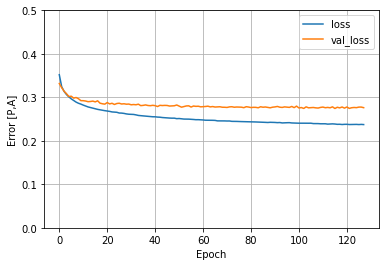

In [14]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, .5])
    plt.xlabel('Epoch')
    plt.ylabel('Error [P,A]')
    plt.legend()
    plt.grid(True)


plot_loss(history)

## Test Model

### Test

In [15]:
test_results = model.evaluate(test_X, test_y, verbose=2)
print("Mean Absolute Error:",test_results)

353/353 - 0s - loss: 0.2719 - 220ms/epoch - 624us/step
Mean Absolute Error: 0.27186521887779236


### Predictions

In [16]:
test_y.head()

,EMOTION_P,EMOTION_A
2,-0.5,0.6
9,-0.5,0.6
10,-0.5,0.6
12,-0.5,0.6
16,-0.5,0.6


In [17]:
test_predictions = model.predict(test_X)

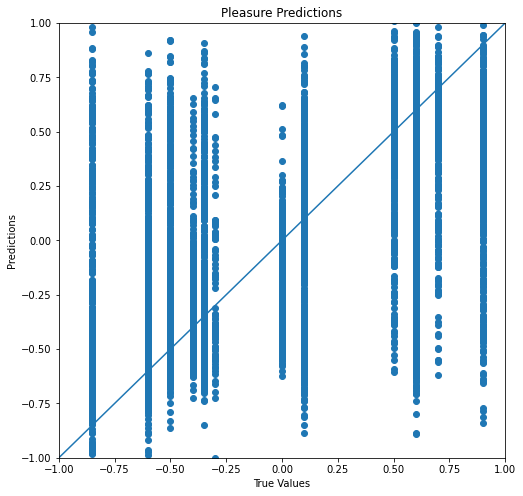

In [18]:
test_y_p = test_y.iloc[:,0]
pred_y_p = test_predictions[:,0]

fig = plt.figure(figsize=[8,8])

plt.scatter(test_y_p, pred_y_p)

plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Pleasure Predictions')

lims = [-1,1]
plt.xlim(lims)
plt.ylim(lims)

plt.plot(lims, lims)

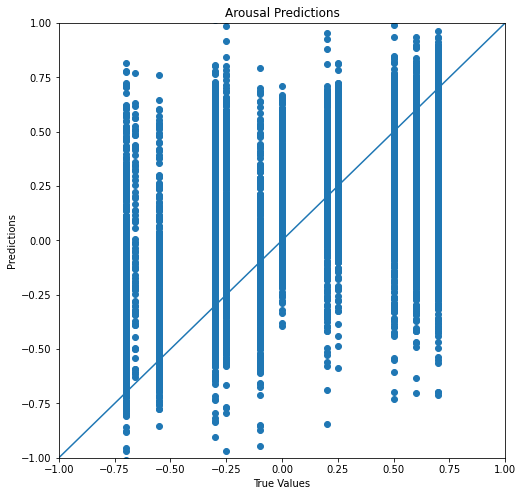

In [19]:
test_y_a = test_y.iloc[:,1]
pred_y_a = test_predictions[:,1]

fig = plt.figure(figsize=[8,8])

plt.scatter(test_y_a, pred_y_a)

plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Arousal Predictions')

lims = [-1,1]
plt.xlim(lims)
plt.ylim(lims)

plt.plot(lims, lims)

### Prediction

In [20]:
row=test_X.iloc[3]

newX = np.asarray([row])
print(newX)

yhat = model.predict(newX)
print('Real: %s' % np.asarray(test_y.iloc[0]))
print('Predicted: %s' % yhat[0])

[[ 4.29294321e-01  3.06416764e-01  1.90160499e-01  4.80217455e-01
   4.81940802e-01  3.92710381e-01  3.68086612e-01  2.79621814e-01
   2.86151000e-01  2.78543929e-01  1.46260049e-03  7.27718893e-02
  -1.24973131e-01  9.88677098e-01 -7.23215648e-03  7.74506342e-02
  -7.46573787e-02  9.93415262e-01  3.44755140e-01  2.35700501e-01
   2.43901109e-01 -1.90304534e+00  1.11720574e-01  1.17148491e-02
  -2.64487607e-01 -3.25672018e-01 -1.32798951e+00 -1.13553977e-01
  -3.25672018e-01 -1.32798951e+00 -1.13553977e-01  2.75070287e-02
   2.29849149e-03]]
Real: [-0.5  0.6]
Predicted: [-0.52534443  0.1486804 ]


In [21]:
row=test_X.iloc[150]

newX = np.asarray([row])
print(newX)

yhat = model.predict(newX)
print('Real: %s' % np.asarray(test_y.iloc[0]))
print('Predicted: %s' % yhat[0])

[[ 1.17215946e-01  3.61241095e-01  3.99839017e-01  4.36527563e-01
   2.25056134e-01  2.50486207e-01  2.13999571e-01  2.25460328e-01
   2.86151000e-01  2.78802821e-01 -4.47469565e-02 -1.97556939e-02
  -1.22498981e-01  9.91259681e-01 -3.79469484e-02 -1.91014097e-02
  -9.71441635e-02  9.94360778e-01  1.50873400e+00  1.53570480e+00
   5.10256963e-03  2.48060947e-02 -6.57138458e-02  3.51885611e-03
   3.30361134e-02  1.60708801e-02 -3.23744358e-02  6.02535890e-02
   1.60708801e-02 -3.23744358e-02  6.02535890e-02  3.09335762e-02
   5.35708106e-04]]
Real: [-0.5  0.6]
Predicted: [-0.37035128  0.5560564 ]


In [22]:
row=test_X.iloc[69]

newX = np.asarray([row])
print(newX)

yhat = model.predict(newX)
print('Real: %s' % np.asarray(test_y.iloc[0]))
print('Predicted: %s' % yhat[0])

[[ 7.45094044e-01  3.08864935e-01  5.89613759e-01  2.16829686e-01
   4.88945356e-01  5.00097549e-01  3.68079471e-01  4.04840912e-01
   2.86151000e-01  2.78836833e-01 -4.74951927e-02  1.28751507e-02
  -1.02237442e-02  9.98701594e-01 -3.35488704e-02  1.02280769e-02
  -2.56976120e-02  9.99019439e-01  8.40703464e-01  8.31786194e-01
   7.28529193e-03 -1.12519885e+00 -4.73639152e-02  3.69714237e-03
  -3.61404533e-02 -3.79055102e-02  1.92132258e-01 -1.37202153e-01
  -3.79055102e-02  1.92132258e-01 -1.37202153e-01  3.92774494e-02
   3.67095874e-04]]
Real: [-0.5  0.6]
Predicted: [-0.0444088 -0.0207414]


# Gradient Boosting (LMA features to P,A coordinates)

## Imports

In [120]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
import tensorflow as tf

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import GradientBoostingRegressor

## Load Data

In [113]:
dataset = pd.read_csv('datasets/pa/Fs_B_N_LMA_DATA.csv')

### Split into Test and Train data

In [114]:
train_dataset = dataset.sample(frac=0.8, random_state=42)
test_dataset = dataset.drop(train_dataset.index)

print("No Training Samples:",train_dataset.shape[0])
print("No Test Samples:",test_dataset.shape[0])

No Training Samples: 8000
No Test Samples: 2000


### Split Features from Targets

In [115]:
train_X = train_dataset.copy()
test_X = test_dataset.copy()

train_y = pd.concat([train_X.pop(x) for x in ['EMOTION_P', 'EMOTION_A']], axis=1)
test_y = pd.concat([test_X.pop(x) for x in ['EMOTION_P', 'EMOTION_A']], axis=1)

test_y_p = test_y.iloc[:,0]
train_y_p = train_y.iloc[:,0]

test_y_a = test_y.iloc[:,1]
train_y_a = train_y.iloc[:,1]

In [116]:
train_X.head()

,avg_hand_distance,avg_l_hand_hip_distance,avg_r_hand_hip_distance,avg_feet_distance,avg_l_hand_chest_distance,avg_r_hand_chest_distance,avg_l_elbow_hip_distance,avg_r_elbow_hip_distance,avg_chest_pelvis_distance,avg_neck_chest_distance,...,avg_pelvis_velocity_y,avg_pelvis_velocity_z,avg_l_foot_velocity_x,avg_l_foot_velocity_y,avg_l_foot_velocity_z,avg_r_foot_velocity_x,avg_r_foot_velocity_y,avg_r_foot_velocity_z,avg_upper_body_volume,avg_distance_traveled
6252,0.182161,0.239957,0.073864,0.239951,0.627903,0.481206,0.502666,0.344620,0.415943,0.979307,...,0.581273,0.457494,0.579834,0.408163,0.508905,0.625058,0.410921,0.481715,0.206246,0.093821
4684,0.445825,0.270398,0.307184,0.540458,0.629404,0.480568,0.497964,0.556971,0.355507,0.977475,...,0.701403,0.453512,0.567967,0.471092,0.594918,0.640870,0.502866,0.438463,0.529884,0.154873
1731,0.630929,0.655890,0.246729,0.060113,0.653721,0.612517,0.599840,0.526427,0.305967,0.996776,...,0.574805,0.494450,0.583849,0.422701,0.483744,0.630963,0.421293,0.454491,0.467607,0.005886
4742,0.713392,0.546526,0.452078,0.520810,0.801025,0.734590,0.773689,0.665912,0.339651,0.989962,...,0.532673,0.334498,0.570885,0.344419,0.486102,0.629931,0.353288,0.494141,0.682069,0.130044
4521,0.403415,0.269620,0.282995,0.051448,0.644198,0.634451,0.521853,0.554992,0.314383,0.999728,...,0.584685,0.488869,0.583202,0.422638,0.485936,0.630273,0.421230,0.457467,0.350990,0.006148


In [117]:
train_y.head()

,EMOTION_P,EMOTION_A
6252,0.1,-0.7
4684,0.7,0.2
1731,-0.5,0.6
4742,0.7,0.2
4521,0.6,0.5


In [118]:
train_X.describe().transpose()[['mean', 'std']]

,mean,std
avg_hand_distance,0.403083,0.223347
avg_l_hand_hip_distance,0.337277,0.200253
avg_r_hand_hip_distance,0.350649,0.198675
avg_feet_distance,0.246535,0.107873
avg_l_hand_chest_distance,0.603496,0.160886
avg_r_hand_chest_distance,0.589745,0.170321
avg_l_elbow_hip_distance,0.514783,0.171863
avg_r_elbow_hip_distance,0.543706,0.171387
avg_chest_pelvis_distance,0.323467,0.062589
avg_neck_chest_distance,0.973500,0.048300


## Define Model

In [121]:
model_p = GradientBoostingRegressor()
model_a = GradientBoostingRegressor()

## Train Model

In [122]:
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

### Pleasure Regression

In [123]:
n_scores = cross_val_score(model_p, train_X, train_y_p, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
print('MAE: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

MAE: -0.236 (0.007)


In [124]:
model_p.fit(train_X, train_y_p)

GradientBoostingRegressor()

### Arousal Regression

In [125]:
n_scores = cross_val_score(model_a, train_X, train_y_a, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
print('MAE: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

MAE: -0.240 (0.006)


In [126]:
model_a.fit(train_X, train_y_a)

GradientBoostingRegressor()

## Test Model

### Prediction

In [127]:
row=test_X.iloc[0]

x = np.asarray([row])

y_p = model_p.predict(x)
y_a = model_a.predict(x)

print('Real: %s' % np.asarray(test_y.iloc[0]))
print('Predicted: %s' % [y_p, y_a])

Real: [-0.35  0.7 ]
Predicted: [array([-0.16072887]), array([0.50489924])]


/home/ds/.local/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/ds/.local/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(


In [129]:
row=test_X.iloc[150]

x = np.asarray([row])

y_p = model_p.predict(x)
y_a = model_a.predict(x)

print('Real: %s' % np.asarray(test_y.iloc[0]))
print('Predicted: %s' % [y_p, y_a])

Real: [-0.35  0.7 ]
Predicted: [array([-0.25354781]), array([0.40621777])]


/home/ds/.local/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/ds/.local/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(


In [130]:
row=test_X.iloc[69]

x = np.asarray([row])

y_p = model_p.predict(x)
y_a = model_a.predict(x)

print('Real: %s' % np.asarray(test_y.iloc[0]))
print('Predicted: %s' % [y_p, y_a])

Real: [-0.35  0.7 ]
Predicted: [array([-0.27337685]), array([0.32014121])]


/home/ds/.local/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/ds/.local/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(


# XGBRegression (LMA features to P,A coordinates)

## Imports

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf

import sklearn
from sklearn.model_selection import cross_val_score, KFold

import xgboost as xgb

xgb.set_config(verbosity=2)

from sklearn.metrics import mean_squared_error

2022-03-11 14:41:33.954265: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-11 14:41:33.954303: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/ds/.local/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## Load Data

In [3]:
#dataset = pd.read_csv('datasets/pa/Fs_B_N_LMA_DATA.csv')
#dataset = pd.read_csv('datasets/pa/Fs_N_LMA_DATA.csv')
#dataset = pd.read_csv('datasets/pa/Fs_N_LMA_DATA_EXTRA.csv')
dataset = pd.read_csv('datasets/pa/Fs2_N_LMA_DATA_EXTRA.csv')

### Split into Test and Train data

In [4]:
train_dataset = dataset.sample(frac=0.8, random_state=42)
test_dataset = dataset.drop(train_dataset.index)

print("No Training Samples:",train_dataset.shape[0])
print("No Test Samples:",test_dataset.shape[0])

No Training Samples: 45087
No Test Samples: 11272


### Split Features from Targets

In [5]:
train_X = train_dataset.copy()
test_X = test_dataset.copy()

train_y = pd.concat([train_X.pop(x) for x in ['EMOTION_P', 'EMOTION_A']], axis=1)
test_y = pd.concat([test_X.pop(x) for x in ['EMOTION_P', 'EMOTION_A']], axis=1)

test_y_p = test_y.iloc[:,0]
train_y_p = train_y.iloc[:,0]

test_y_a = test_y.iloc[:,1]
train_y_a = train_y.iloc[:,1]

In [6]:
train_X.head()

,avg_hand_distance,avg_l_hand_hip_distance,avg_r_hand_hip_distance,avg_feet_distance,avg_l_hand_chest_distance,avg_r_hand_chest_distance,avg_l_elbow_hip_distance,avg_r_elbow_hip_distance,avg_chest_pelvis_distance,avg_neck_chest_distance,...,avg_pelvis_velocity_y,avg_pelvis_velocity_z,avg_l_foot_velocity_x,avg_l_foot_velocity_y,avg_l_foot_velocity_z,avg_r_foot_velocity_x,avg_r_foot_velocity_y,avg_r_foot_velocity_z,avg_upper_body_volume,avg_distance_traveled
5770,0.262334,0.662568,0.696583,0.241384,0.630144,0.594538,0.681151,0.629491,0.257159,0.996101,...,0.473326,0.539095,0.590923,0.633511,0.331921,0.448977,0.506205,0.533892,0.634425,0.055723
20189,0.531666,0.499619,0.491083,0.182074,0.747718,0.387772,0.699997,0.397462,0.256635,0.999420,...,0.492880,0.357735,0.592764,0.617945,0.345391,0.450799,0.496437,0.548976,0.533730,0.132637
55768,0.404123,0.144595,0.455608,0.180686,0.546617,0.711027,0.429951,0.666752,0.272435,0.896752,...,0.482871,0.432854,0.586842,0.662572,0.372798,0.439296,0.481497,0.525963,0.316449,0.031250
5563,0.328572,0.268337,0.225690,0.294625,0.629984,0.598234,0.557388,0.518056,0.264650,0.998397,...,0.507869,0.506601,0.589155,0.622941,0.338966,0.447227,0.499572,0.541782,0.350779,0.032754
53047,0.570762,0.540919,0.507984,0.273218,0.560548,0.556178,0.646091,0.596224,0.260777,0.982706,...,0.447770,0.526478,0.575987,0.652520,0.372661,0.454815,0.506949,0.489328,0.693218,0.046396


In [7]:
train_y.head()

,EMOTION_P,EMOTION_A
5770,-0.35,0.7
20189,-0.35,0.7
55768,-0.85,-0.1
5563,-0.50,0.6
53047,0.50,0.7


In [8]:
train_X.describe().transpose()[['mean', 'std']]

,mean,std
avg_hand_distance,0.367866,0.202526
avg_l_hand_hip_distance,0.354570,0.185754
avg_r_hand_hip_distance,0.369125,0.193929
avg_feet_distance,0.221029,0.105025
avg_l_hand_chest_distance,0.566260,0.164762
avg_r_hand_chest_distance,0.563325,0.164601
avg_l_elbow_hip_distance,0.525713,0.154588
avg_r_elbow_hip_distance,0.526010,0.155729
avg_chest_pelvis_distance,0.268310,0.023227
avg_neck_chest_distance,0.982620,0.035712


## Define Model

In [9]:
xgbr = xgb.XGBRegressor(verbosity=0) 


model_p = xgb.XGBRegressor(
                    n_estimators=2000, learning_rate=0.05, max_depth=10, min_child_weight=11, 
                    subsample=1, colsample_bytree=1, objective="reg:linear"
                )

model_a = xgb.XGBRegressor(
                    n_estimators=2000, learning_rate=0.05, max_depth=10, min_child_weight=11, 
                    subsample=1, colsample_bytree=1, objective="reg:linear"
                )

## Train Model

### Pleasure Regression

In [ ]:
model_p.fit(train_X, train_y_p)

/home/ds/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:41:50] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[14:41:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 802 extra nodes, 0 pruned nodes, max_depth=10
[14:41:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 842 extra nodes, 0 pruned nodes, max_depth=10
[14:41:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 848 extra nodes, 0 pruned nodes, max_depth=10
[14:41:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 850 extra nodes, 0 pruned nodes, max_depth=10
[14:41:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 790 extra nodes, 0 pruned nodes, max_depth=10
[14:41:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 752 extra nodes, 0 pruned nodes, max_depth=10
[14:41:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 898 extra nodes, 0 pruned nodes, max_depth=10
[14:41:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 822 ext

[14:41:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 826 extra nodes, 0 pruned nodes, max_depth=10
[14:41:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 510 extra nodes, 0 pruned nodes, max_depth=10
[14:41:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 498 extra nodes, 0 pruned nodes, max_depth=10
[14:41:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 300 extra nodes, 0 pruned nodes, max_depth=10
[14:41:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 770 extra nodes, 0 pruned nodes, max_depth=10
[14:41:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 442 extra nodes, 0 pruned nodes, max_depth=10
[14:41:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 302 extra nodes, 0 pruned nodes, max_depth=10
[14:41:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 418 extra nodes, 0 pruned nodes, max_depth=10
[14:42:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 618 extra n

[14:42:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 96 extra nodes, 0 pruned nodes, max_depth=10
[14:42:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 318 extra nodes, 0 pruned nodes, max_depth=10
[14:42:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 428 extra nodes, 0 pruned nodes, max_depth=10
[14:42:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 148 extra nodes, 0 pruned nodes, max_depth=10
[14:42:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes, 0 pruned nodes, max_depth=10
[14:42:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 804 extra nodes, 0 pruned nodes, max_depth=10
[14:42:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 120 extra nodes, 0 pruned nodes, max_depth=10
[14:42:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 284 extra nodes, 0 pruned nodes, max_depth=10
[14:42:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 370 extra no

[14:42:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 542 extra nodes, 0 pruned nodes, max_depth=10
[14:42:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 434 extra nodes, 0 pruned nodes, max_depth=10
[14:42:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 92 extra nodes, 0 pruned nodes, max_depth=10
[14:42:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 626 extra nodes, 0 pruned nodes, max_depth=10
[14:42:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 490 extra nodes, 0 pruned nodes, max_depth=10
[14:42:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes, 0 pruned nodes, max_depth=10
[14:42:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 426 extra nodes, 0 pruned nodes, max_depth=10
[14:42:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 238 extra nodes, 0 pruned nodes, max_depth=10
[14:42:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 306 extra no

[14:42:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 452 extra nodes, 0 pruned nodes, max_depth=10
[14:42:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 272 extra nodes, 0 pruned nodes, max_depth=10
[14:42:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 268 extra nodes, 0 pruned nodes, max_depth=10
[14:42:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 130 extra nodes, 0 pruned nodes, max_depth=10
[14:42:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 466 extra nodes, 0 pruned nodes, max_depth=10
[14:42:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 352 extra nodes, 0 pruned nodes, max_depth=10
[14:42:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra nodes, 0 pruned nodes, max_depth=10
[14:42:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 342 extra nodes, 0 pruned nodes, max_depth=10
[14:42:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 238 extra n

[14:42:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 148 extra nodes, 0 pruned nodes, max_depth=10
[14:42:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 186 extra nodes, 0 pruned nodes, max_depth=10
[14:42:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=10
[14:42:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 64 extra nodes, 0 pruned nodes, max_depth=10
[14:42:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 254 extra nodes, 0 pruned nodes, max_depth=10
[14:42:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 86 extra nodes, 0 pruned nodes, max_depth=10
[14:42:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 420 extra nodes, 0 pruned nodes, max_depth=10
[14:42:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 252 extra nodes, 0 pruned nodes, max_depth=10
[14:42:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 692 extra node

[14:42:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes, 0 pruned nodes, max_depth=10
[14:42:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 260 extra nodes, 0 pruned nodes, max_depth=10
[14:42:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 192 extra nodes, 0 pruned nodes, max_depth=10
[14:42:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 618 extra nodes, 0 pruned nodes, max_depth=10
[14:42:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra nodes, 0 pruned nodes, max_depth=10
[14:42:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 144 extra nodes, 0 pruned nodes, max_depth=10
[14:42:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 348 extra nodes, 0 pruned nodes, max_depth=10
[14:42:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 316 extra nodes, 0 pruned nodes, max_depth=10
[14:42:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 518 extra n

[14:42:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 138 extra nodes, 0 pruned nodes, max_depth=10
[14:42:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 508 extra nodes, 0 pruned nodes, max_depth=10
[14:42:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 224 extra nodes, 0 pruned nodes, max_depth=10
[14:42:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes, 0 pruned nodes, max_depth=10
[14:42:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 108 extra nodes, 0 pruned nodes, max_depth=10
[14:42:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 214 extra nodes, 0 pruned nodes, max_depth=10
[14:42:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 330 extra nodes, 0 pruned nodes, max_depth=10
[14:42:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 280 extra nodes, 0 pruned nodes, max_depth=10
[14:42:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 540 extra n

[14:42:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 270 extra nodes, 0 pruned nodes, max_depth=10
[14:42:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 356 extra nodes, 0 pruned nodes, max_depth=10
[14:42:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 294 extra nodes, 0 pruned nodes, max_depth=10
[14:42:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=10
[14:42:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 404 extra nodes, 0 pruned nodes, max_depth=10
[14:42:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 142 extra nodes, 0 pruned nodes, max_depth=10
[14:42:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 102 extra nodes, 0 pruned nodes, max_depth=10
[14:42:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 302 extra nodes, 0 pruned nodes, max_depth=10
[14:42:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 502 extra n

[14:43:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 378 extra nodes, 0 pruned nodes, max_depth=10
[14:43:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 338 extra nodes, 0 pruned nodes, max_depth=10
[14:43:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 360 extra nodes, 0 pruned nodes, max_depth=10
[14:43:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 490 extra nodes, 0 pruned nodes, max_depth=10
[14:43:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 320 extra nodes, 0 pruned nodes, max_depth=10
[14:43:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 366 extra nodes, 0 pruned nodes, max_depth=10
[14:43:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=10
[14:43:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 290 extra nodes, 0 pruned nodes, max_depth=10
[14:43:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 552 extra n

[14:43:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 326 extra nodes, 0 pruned nodes, max_depth=10
[14:43:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 374 extra nodes, 0 pruned nodes, max_depth=10
[14:43:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=10
[14:43:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 484 extra nodes, 0 pruned nodes, max_depth=10
[14:43:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 544 extra nodes, 0 pruned nodes, max_depth=10
[14:43:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 278 extra nodes, 0 pruned nodes, max_depth=10
[14:43:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 488 extra nodes, 0 pruned nodes, max_depth=10
[14:43:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 252 extra nodes, 0 pruned nodes, max_depth=10
[14:43:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 320 extra n

[14:43:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 146 extra nodes, 0 pruned nodes, max_depth=10
[14:43:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 458 extra nodes, 0 pruned nodes, max_depth=10
[14:43:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 448 extra nodes, 0 pruned nodes, max_depth=10
[14:43:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 330 extra nodes, 0 pruned nodes, max_depth=10
[14:43:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 690 extra nodes, 0 pruned nodes, max_depth=10
[14:43:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra nodes, 0 pruned nodes, max_depth=10
[14:43:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 180 extra nodes, 0 pruned nodes, max_depth=10
[14:43:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 238 extra nodes, 0 pruned nodes, max_depth=10
[14:43:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 394 extra n

[14:43:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 308 extra nodes, 0 pruned nodes, max_depth=10
[14:43:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 334 extra nodes, 0 pruned nodes, max_depth=10
[14:43:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 264 extra nodes, 0 pruned nodes, max_depth=10
[14:43:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 308 extra nodes, 0 pruned nodes, max_depth=10
[14:43:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 392 extra nodes, 0 pruned nodes, max_depth=10
[14:43:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 72 extra nodes, 0 pruned nodes, max_depth=10
[14:43:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 350 extra nodes, 0 pruned nodes, max_depth=10
[14:43:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 512 extra nodes, 0 pruned nodes, max_depth=10
[14:43:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 370 extra no

[14:43:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 350 extra nodes, 0 pruned nodes, max_depth=10
[14:43:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 350 extra nodes, 0 pruned nodes, max_depth=10
[14:43:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 240 extra nodes, 0 pruned nodes, max_depth=10
[14:43:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 294 extra nodes, 0 pruned nodes, max_depth=10
[14:43:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 438 extra nodes, 0 pruned nodes, max_depth=10
[14:43:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 350 extra nodes, 0 pruned nodes, max_depth=10
[14:43:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 338 extra nodes, 0 pruned nodes, max_depth=10
[14:43:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 454 extra nodes, 0 pruned nodes, max_depth=10
[14:43:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 290 extra n

[14:43:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 610 extra nodes, 0 pruned nodes, max_depth=10
[14:43:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 264 extra nodes, 0 pruned nodes, max_depth=10
[14:43:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 228 extra nodes, 0 pruned nodes, max_depth=10
[14:43:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 306 extra nodes, 0 pruned nodes, max_depth=10
[14:43:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 290 extra nodes, 0 pruned nodes, max_depth=10
[14:43:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 318 extra nodes, 0 pruned nodes, max_depth=10
[14:43:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 414 extra nodes, 0 pruned nodes, max_depth=10
[14:43:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 240 extra nodes, 0 pruned nodes, max_depth=10
[14:43:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 140 extra n

[14:43:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 228 extra nodes, 0 pruned nodes, max_depth=10
[14:43:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 292 extra nodes, 0 pruned nodes, max_depth=10
[14:43:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 240 extra nodes, 0 pruned nodes, max_depth=10
[14:43:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 234 extra nodes, 0 pruned nodes, max_depth=10
[14:43:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 352 extra nodes, 0 pruned nodes, max_depth=10
[14:43:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 408 extra nodes, 0 pruned nodes, max_depth=10
[14:43:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 198 extra nodes, 0 pruned nodes, max_depth=10
[14:43:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 554 extra nodes, 0 pruned nodes, max_depth=10
[14:43:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 442 extra n

[14:44:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 404 extra nodes, 0 pruned nodes, max_depth=10
[14:44:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 486 extra nodes, 0 pruned nodes, max_depth=10
[14:44:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 302 extra nodes, 0 pruned nodes, max_depth=10
[14:44:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 222 extra nodes, 0 pruned nodes, max_depth=10
[14:44:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 504 extra nodes, 0 pruned nodes, max_depth=10
[14:44:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 396 extra nodes, 0 pruned nodes, max_depth=10
[14:44:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 464 extra nodes, 0 pruned nodes, max_depth=10
[14:44:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 320 extra nodes, 0 pruned nodes, max_depth=10
[14:44:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 286 extra n

[14:44:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 288 extra nodes, 0 pruned nodes, max_depth=10
[14:44:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 340 extra nodes, 0 pruned nodes, max_depth=10
[14:44:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 0 pruned nodes, max_depth=10
[14:44:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 304 extra nodes, 0 pruned nodes, max_depth=10
[14:44:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 264 extra nodes, 0 pruned nodes, max_depth=10
[14:44:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra nodes, 0 pruned nodes, max_depth=10
[14:44:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 262 extra nodes, 0 pruned nodes, max_depth=10
[14:44:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 252 extra nodes, 0 pruned nodes, max_depth=10
[14:44:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 388 extra n

[14:44:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 302 extra nodes, 0 pruned nodes, max_depth=10
[14:44:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 316 extra nodes, 0 pruned nodes, max_depth=10
[14:44:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 240 extra nodes, 0 pruned nodes, max_depth=10
[14:44:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 426 extra nodes, 0 pruned nodes, max_depth=10
[14:44:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 336 extra nodes, 0 pruned nodes, max_depth=10
[14:44:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 308 extra nodes, 0 pruned nodes, max_depth=10
[14:44:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 270 extra nodes, 0 pruned nodes, max_depth=10
[14:44:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 418 extra nodes, 0 pruned nodes, max_depth=10
[14:44:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 452 extra n

[14:44:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 372 extra nodes, 0 pruned nodes, max_depth=10
[14:44:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 110 extra nodes, 0 pruned nodes, max_depth=10
[14:44:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 314 extra nodes, 0 pruned nodes, max_depth=10
[14:44:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 262 extra nodes, 0 pruned nodes, max_depth=10
[14:44:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 204 extra nodes, 0 pruned nodes, max_depth=10
[14:44:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 288 extra nodes, 0 pruned nodes, max_depth=10
[14:44:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 308 extra nodes, 0 pruned nodes, max_depth=10
[14:44:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 282 extra nodes, 0 pruned nodes, max_depth=10
[14:44:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 236 extra n

[14:44:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 336 extra nodes, 0 pruned nodes, max_depth=10
[14:44:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 96 extra nodes, 0 pruned nodes, max_depth=10
[14:44:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 536 extra nodes, 0 pruned nodes, max_depth=10
[14:44:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 284 extra nodes, 0 pruned nodes, max_depth=10
[14:44:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 228 extra nodes, 0 pruned nodes, max_depth=10
[14:44:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 250 extra nodes, 0 pruned nodes, max_depth=10
[14:44:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 426 extra nodes, 0 pruned nodes, max_depth=10
[14:44:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 302 extra nodes, 0 pruned nodes, max_depth=10
[14:44:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra no

### Arousal Regression

In [ ]:
model_a.fit(train_X, train_y_a)

## Test Model

In [ ]:
score = model_p.score(train_X, train_y_p)  

print("Pleasure")
print("Training score: ", score)

print()

score = model_a.score(train_X, train_y_a)  

print("Arousal")
print("Training score: ", score)

In [ ]:
scores = cross_val_score(model_p, train_X, train_y_p,cv=10)

print("Pleasure")
print("Mean cross-validation score: %.2f" % scores.mean())

print()

scores = cross_val_score(model_a, train_X, train_y_a,cv=10)

print("Arousal")
print("Training score: ", score)

In [ ]:
kfold = KFold(n_splits=10, shuffle=True)
kf_cv_scores = cross_val_score(model_p, train_X, train_y_p, cv=kfold )

print("Pleasure")
print("K-fold CV average score: %.2f" % kf_cv_scores.mean())

print()

kfold = KFold(n_splits=10, shuffle=True)
kf_cv_scores = cross_val_score(model_a, train_X, train_y_a, cv=kfold )

print("Arousal")
print("K-fold CV average score: %.2f" % kf_cv_scores.mean())

### Test Graphs

In [ ]:
pred_y_p = model_p.predict(test_X)
mse = mean_squared_error(test_y_p, pred_y_p)
print("MSE: %.2f" % mse)

pred_y_a = model_a.predict(test_X)
mse = mean_squared_error(test_y_a, pred_y_a)
print("MSE: %.2f" % mse)

In [ ]:
x_ax = range(len(test_y_p))
plt.plot(x_ax, test_y_p, label="original")
plt.plot(x_ax, pred_y_p, label="predicted")

plt.title("Pleasure predictions")

plt.legend()
plt.show()

In [ ]:
x_ax = range(len(test_y_a))
plt.plot(x_ax, test_y_a, label="original")

plt.title("Arousal predictions")

plt.legend()
plt.show()

In [ ]:
x_ax = range(len(test_y_a))
plt.plot(x_ax, pred_y_a, label="predicted")

plt.title("Arousal predictions")

plt.legend()
plt.show()

### Prediction

In [ ]:
row=test_X.iloc[0]

x = np.asarray([row])

y_p = model_p.predict(x)
y_a = model_a.predict(x)

print('Real: %s' % np.asarray(test_y.iloc[0]))
print('Predicted: %s' % [y_p[0], y_a[0]])

In [ ]:
row=test_X.iloc[420]

x = np.asarray([row])

y_p = model_p.predict(x)
y_a = model_a.predict(x)

print('Real: %s' % np.asarray(test_y.iloc[420]))
print('Predicted: %s' % [y_p[0], y_a[0]])

In [ ]:
row=test_X.iloc[4000]

x = np.asarray([row])

y_p = model_p.predict(x)
y_a = model_a.predict(x)

print('Real: %s' % np.asarray(test_y.iloc[4000]))
print('Predicted: %s' % [y_p[0], y_a[0]])

## Hyperparameter Grid Search with XGBoost

In [27]:
from datetime import datetime
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf

import sklearn
from sklearn.model_selection import cross_val_score, KFold

import xgboost as xgb

xgb.set_config(verbosity=2)

from sklearn.metrics import mean_squared_error

In [28]:
# A parameter grid for XGBoost
params = {
        'n_estimators': [1000, 1500, 2000],
        'min_child_weight': [5, 11, 22],
        'gamma': [0.5, 1, 1.5],
        'learning_rate': [0.05, 0.1, 0.15],
        'subsample': [0.5, 1.5, 2.0],
        'colsample_bytree': [0.5, 1.0, 1.5],
        'max_depth': [10, 15, 20]
        }

In [29]:
model_p = xgb.XGBRegressor(
                    n_estimators=2000, learning_rate=0.05, max_depth=10, min_child_weight=11, 
                    subsample=1, colsample_bytree=1, objective="reg:linear"
                )

model_a = xgb.XGBRegressor(
                    n_estimators=2000, learning_rate=0.05, max_depth=10, min_child_weight=11, 
                    subsample=1, colsample_bytree=1, objective="reg:linear"
                )

In [ ]:
# run randomized search
n_iter_search = 100
random_search_p = RandomizedSearchCV(model_p, param_distributions=params,
                                   n_iter=n_iter_search, cv=5, scoring='neg_mean_squared_error')

start = time.time()
random_search_p.fit(train_X, train_y_p)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time.time() - start), n_iter_search))

/home/ds/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:13:08] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[14:13:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 380 extra nodes, 226 pruned nodes, max_depth=15
[14:13:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 438 extra nodes, 280 pruned nodes, max_depth=15
[14:13:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 340 extra nodes, 228 pruned nodes, max_depth=15
[14:13:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 400 extra nodes, 304 pruned nodes, max_depth=15
[14:13:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 398 extra nodes, 346 pruned nodes, max_depth=15
[14:13:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 372 extra nodes, 322 pruned nodes, max_depth=15
[14:13:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 350 extra nodes, 294 pruned nodes, max_depth=15
[14:13:09] INFO: ../src/tree/updater_prune.cc:101: tree prunin

[14:13:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 424 pruned nodes, max_depth=14
[14:13:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 82 extra nodes, 652 pruned nodes, max_depth=15
[14:13:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 266 pruned nodes, max_depth=15
[14:13:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 94 extra nodes, 288 pruned nodes, max_depth=14
[14:13:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 70 extra nodes, 484 pruned nodes, max_depth=12
[14:13:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 108 pruned nodes, max_depth=0
[14:13:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 86 extra nodes, 676 pruned nodes, max_depth=14
[14:13:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 380 pruned nodes, max_depth=11
[14:13:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 ext

[14:13:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 544 pruned nodes, max_depth=9
[14:13:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 490 pruned nodes, max_depth=8
[14:13:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 316 pruned nodes, max_depth=15
[14:13:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 292 pruned nodes, max_depth=11
[14:13:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 614 pruned nodes, max_depth=7
[14:13:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 404 pruned nodes, max_depth=13
[14:13:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 422 pruned nodes, max_depth=12
[14:13:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 384 pruned nodes, max_depth=0
[14:13:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 18 extra

[14:13:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 664 pruned nodes, max_depth=10
[14:13:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 530 pruned nodes, max_depth=14
[14:13:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 520 pruned nodes, max_depth=0
[14:13:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 420 pruned nodes, max_depth=0
[14:13:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 428 pruned nodes, max_depth=15
[14:13:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 494 pruned nodes, max_depth=14
[14:13:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 264 pruned nodes, max_depth=13
[14:13:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 172 pruned nodes, max_depth=5
[14:13:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra

[14:13:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 272 pruned nodes, max_depth=10
[14:13:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 688 pruned nodes, max_depth=10
[14:13:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 346 pruned nodes, max_depth=0
[14:13:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 614 pruned nodes, max_depth=0
[14:13:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 362 pruned nodes, max_depth=0
[14:13:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 560 pruned nodes, max_depth=0
[14:13:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 286 pruned nodes, max_depth=9
[14:13:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 464 pruned nodes, max_depth=0
[14:13:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes,

[14:14:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 806 pruned nodes, max_depth=0
[14:14:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 12 extra nodes, 232 pruned nodes, max_depth=6
[14:14:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 330 pruned nodes, max_depth=0
[14:14:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 162 pruned nodes, max_depth=0
[14:14:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 520 pruned nodes, max_depth=12
[14:14:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 374 pruned nodes, max_depth=0
[14:14:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 220 pruned nodes, max_depth=12
[14:14:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 242 pruned nodes, max_depth=15
[14:14:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra node

[14:14:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 490 pruned nodes, max_depth=15
[14:14:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 482 pruned nodes, max_depth=7
[14:14:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 796 pruned nodes, max_depth=11
[14:14:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 692 pruned nodes, max_depth=0
[14:14:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 140 pruned nodes, max_depth=0
[14:14:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 418 pruned nodes, max_depth=0
[14:14:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 640 pruned nodes, max_depth=12
[14:14:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 624 pruned nodes, max_depth=0
[14:14:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra node

[14:14:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 194 pruned nodes, max_depth=0
[14:14:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 326 pruned nodes, max_depth=0
[14:14:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 616 pruned nodes, max_depth=0
[14:14:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 494 pruned nodes, max_depth=9
[14:14:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 392 pruned nodes, max_depth=0
[14:14:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 358 pruned nodes, max_depth=0
[14:14:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 596 pruned nodes, max_depth=13
[14:14:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 496 pruned nodes, max_depth=0
[14:14:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 

[14:14:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 570 pruned nodes, max_depth=0
[14:14:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 548 pruned nodes, max_depth=0
[14:14:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 310 pruned nodes, max_depth=0
[14:14:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 722 pruned nodes, max_depth=12
[14:14:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 346 pruned nodes, max_depth=0
[14:14:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 490 pruned nodes, max_depth=0
[14:14:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 252 pruned nodes, max_depth=0
[14:14:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 650 pruned nodes, max_depth=0
[14:14:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 21

[14:14:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 4 extra nodes, 532 pruned nodes, max_depth=2
[14:14:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 592 pruned nodes, max_depth=10
[14:14:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 590 pruned nodes, max_depth=0
[14:14:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 420 pruned nodes, max_depth=0
[14:14:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 714 pruned nodes, max_depth=0
[14:14:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 400 pruned nodes, max_depth=0
[14:14:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 464 pruned nodes, max_depth=0
[14:14:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 392 pruned nodes, max_depth=0
[14:14:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 43

[14:14:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 352 pruned nodes, max_depth=14
[14:14:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 376 pruned nodes, max_depth=0
[14:14:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 416 pruned nodes, max_depth=0
[14:14:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 482 pruned nodes, max_depth=0
[14:14:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 442 pruned nodes, max_depth=4
[14:14:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 348 pruned nodes, max_depth=0
[14:14:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 352 pruned nodes, max_depth=0
[14:14:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 604 pruned nodes, max_depth=0
[14:14:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 90

[14:14:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 254 pruned nodes, max_depth=0
[14:14:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 332 pruned nodes, max_depth=0
[14:14:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 524 pruned nodes, max_depth=0
[14:14:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 410 pruned nodes, max_depth=13
[14:14:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 624 pruned nodes, max_depth=9
[14:14:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 468 pruned nodes, max_depth=0
[14:14:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 342 pruned nodes, max_depth=0
[14:14:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 318 pruned nodes, max_depth=0
[14:14:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 7

[14:15:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 698 pruned nodes, max_depth=0
[14:15:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 610 pruned nodes, max_depth=0
[14:15:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 572 pruned nodes, max_depth=0
[14:15:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 576 pruned nodes, max_depth=0
[14:15:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 456 pruned nodes, max_depth=0
[14:15:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 352 pruned nodes, max_depth=0
[14:15:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 562 pruned nodes, max_depth=0
[14:15:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 686 pruned nodes, max_depth=0
[14:15:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 280 

/home/ds/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:15:15] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[14:15:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 394 extra nodes, 204 pruned nodes, max_depth=15
[14:15:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 386 extra nodes, 314 pruned nodes, max_depth=15
[14:15:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 446 extra nodes, 266 pruned nodes, max_depth=15
[14:15:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 332 extra nodes, 268 pruned nodes, max_depth=15
[14:15:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 368 extra nodes, 202 pruned nodes, max_depth=15
[14:15:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 420 extra nodes, 362 pruned nodes, max_depth=15
[14:15:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 400 extra nodes, 374 pruned nodes, max_depth=15
[14:15:17] INFO: ../src/tree/updater_prune.cc:101: tree prunin

[14:15:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 246 pruned nodes, max_depth=15
[14:15:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 78 extra nodes, 374 pruned nodes, max_depth=15
[14:15:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 72 extra nodes, 908 pruned nodes, max_depth=12
[14:15:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 396 pruned nodes, max_depth=15
[14:15:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 514 pruned nodes, max_depth=11
[14:15:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 406 pruned nodes, max_depth=8
[14:15:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 442 pruned nodes, max_depth=12
[14:15:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 424 pruned nodes, max_depth=11
[14:15:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 e

[14:15:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 514 pruned nodes, max_depth=14
[14:15:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 538 pruned nodes, max_depth=15
[14:15:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 228 pruned nodes, max_depth=7
[14:15:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 316 pruned nodes, max_depth=9
[14:15:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 344 pruned nodes, max_depth=15
[14:15:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 234 pruned nodes, max_depth=13
[14:15:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 4 extra nodes, 624 pruned nodes, max_depth=2
[14:15:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 122 pruned nodes, max_depth=14
[14:15:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extr

[14:15:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 538 pruned nodes, max_depth=12
[14:15:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 138 pruned nodes, max_depth=0
[14:15:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 508 pruned nodes, max_depth=13
[14:15:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 378 pruned nodes, max_depth=11
[14:15:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 248 pruned nodes, max_depth=0
[14:15:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 574 pruned nodes, max_depth=0
[14:15:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 442 pruned nodes, max_depth=15
[14:15:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 360 pruned nodes, max_depth=0
[14:15:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra no

[14:15:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 538 pruned nodes, max_depth=14
[14:15:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 250 pruned nodes, max_depth=0
[14:15:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 326 pruned nodes, max_depth=8
[14:15:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 298 pruned nodes, max_depth=0
[14:15:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 268 pruned nodes, max_depth=0
[14:15:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 348 pruned nodes, max_depth=0
[14:15:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 248 pruned nodes, max_depth=0
[14:15:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 198 pruned nodes, max_depth=0
[14:15:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 4

[14:16:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 814 pruned nodes, max_depth=0
[14:16:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 350 pruned nodes, max_depth=7
[14:16:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 486 pruned nodes, max_depth=0
[14:16:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 578 pruned nodes, max_depth=0
[14:16:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 720 pruned nodes, max_depth=8
[14:16:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 366 pruned nodes, max_depth=9
[14:16:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 536 pruned nodes, max_depth=13
[14:16:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 636 pruned nodes, max_depth=0
[14:16:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes,

[14:16:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 438 pruned nodes, max_depth=0
[14:16:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 476 pruned nodes, max_depth=0
[14:16:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 638 pruned nodes, max_depth=15
[14:16:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 216 pruned nodes, max_depth=0
[14:16:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 752 pruned nodes, max_depth=0
[14:16:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 334 pruned nodes, max_depth=0
[14:16:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 382 pruned nodes, max_depth=0
[14:16:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 320 pruned nodes, max_depth=15
[14:16:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 

[14:16:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 744 pruned nodes, max_depth=0
[14:16:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 748 pruned nodes, max_depth=12
[14:16:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 566 pruned nodes, max_depth=0
[14:16:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 326 pruned nodes, max_depth=0
[14:16:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 428 pruned nodes, max_depth=0
[14:16:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 194 pruned nodes, max_depth=0
[14:16:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 542 pruned nodes, max_depth=0
[14:16:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 462 pruned nodes, max_depth=0
[14:16:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 58

[14:16:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 532 pruned nodes, max_depth=15
[14:16:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 802 pruned nodes, max_depth=0
[14:16:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 302 pruned nodes, max_depth=0
[14:16:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 504 pruned nodes, max_depth=0
[14:16:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 344 pruned nodes, max_depth=12
[14:16:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 260 pruned nodes, max_depth=0
[14:16:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 528 pruned nodes, max_depth=0
[14:16:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 594 pruned nodes, max_depth=0
[14:16:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 

[14:16:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 348 pruned nodes, max_depth=0
[14:16:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 134 pruned nodes, max_depth=0
[14:16:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 498 pruned nodes, max_depth=0
[14:16:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 598 pruned nodes, max_depth=0
[14:16:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 406 pruned nodes, max_depth=0
[14:16:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 278 pruned nodes, max_depth=0
[14:16:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 474 pruned nodes, max_depth=0
[14:16:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 480 pruned nodes, max_depth=0
[14:16:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 848

[14:16:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 220 pruned nodes, max_depth=0
[14:16:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 690 pruned nodes, max_depth=0
[14:16:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 270 pruned nodes, max_depth=0
[14:16:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 466 pruned nodes, max_depth=15
[14:16:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 614 pruned nodes, max_depth=9
[14:16:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 354 pruned nodes, max_depth=5
[14:16:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 306 pruned nodes, max_depth=14
[14:16:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 282 pruned nodes, max_depth=0
[14:16:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes

[14:16:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 428 pruned nodes, max_depth=0
[14:16:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 282 pruned nodes, max_depth=0
[14:16:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 260 pruned nodes, max_depth=0
[14:16:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 268 pruned nodes, max_depth=0
[14:16:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 386 pruned nodes, max_depth=0
[14:16:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 460 pruned nodes, max_depth=0
[14:16:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 356 pruned nodes, max_depth=0
[14:16:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 202 pruned nodes, max_depth=0
[14:16:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 154 

[14:17:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 218 pruned nodes, max_depth=0
[14:17:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 292 pruned nodes, max_depth=0
[14:17:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 270 pruned nodes, max_depth=0
[14:17:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 442 pruned nodes, max_depth=0
[14:17:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 670 pruned nodes, max_depth=4
[14:17:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 468 pruned nodes, max_depth=0
[14:17:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 546 pruned nodes, max_depth=12
[14:17:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 518 pruned nodes, max_depth=0
[14:17:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 56

[14:17:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 398 pruned nodes, max_depth=0
[14:17:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 268 pruned nodes, max_depth=0
[14:17:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 476 pruned nodes, max_depth=10
[14:17:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 274 pruned nodes, max_depth=0
[14:17:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 320 pruned nodes, max_depth=0
[14:17:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 254 pruned nodes, max_depth=0
[14:17:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 576 pruned nodes, max_depth=15
[14:17:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 778 pruned nodes, max_depth=0
[14:17:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 

/home/ds/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:17:20] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[14:17:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 450 extra nodes, 286 pruned nodes, max_depth=15
[14:17:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 408 extra nodes, 294 pruned nodes, max_depth=15
[14:17:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 398 extra nodes, 266 pruned nodes, max_depth=15
[14:17:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 420 extra nodes, 288 pruned nodes, max_depth=15
[14:17:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 350 extra nodes, 244 pruned nodes, max_depth=15
[14:17:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 366 extra nodes, 236 pruned nodes, max_depth=15
[14:17:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 332 extra nodes, 266 pruned nodes, max_depth=15
[14:17:21] INFO: ../src/tree/updater_prune.cc:101: tree prunin

[14:17:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 86 extra nodes, 572 pruned nodes, max_depth=13
[14:17:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 68 extra nodes, 404 pruned nodes, max_depth=12
[14:17:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 112 extra nodes, 672 pruned nodes, max_depth=15
[14:17:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 214 pruned nodes, max_depth=12
[14:17:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 302 pruned nodes, max_depth=7
[14:17:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 74 extra nodes, 528 pruned nodes, max_depth=15
[14:17:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 90 extra nodes, 660 pruned nodes, max_depth=15
[14:17:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 66 extra nodes, 444 pruned nodes, max_depth=15
[14:17:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 

[14:17:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 262 pruned nodes, max_depth=10
[14:17:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 336 pruned nodes, max_depth=14
[14:17:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 842 pruned nodes, max_depth=14
[14:17:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 386 pruned nodes, max_depth=9
[14:17:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 236 pruned nodes, max_depth=10
[14:17:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 350 pruned nodes, max_depth=15
[14:17:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 370 pruned nodes, max_depth=7
[14:17:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 606 pruned nodes, max_depth=14
[14:17:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 68 ex

[14:17:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 394 pruned nodes, max_depth=13
[14:17:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 260 pruned nodes, max_depth=0
[14:17:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 456 pruned nodes, max_depth=3
[14:17:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 346 pruned nodes, max_depth=0
[14:17:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 654 pruned nodes, max_depth=9
[14:17:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 372 pruned nodes, max_depth=7
[14:17:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 126 pruned nodes, max_depth=0
[14:17:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 346 pruned nodes, max_depth=11
[14:17:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra node

[14:17:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 730 pruned nodes, max_depth=12
[14:17:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 326 pruned nodes, max_depth=0
[14:17:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 526 pruned nodes, max_depth=13
[14:17:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 370 pruned nodes, max_depth=10
[14:17:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 290 pruned nodes, max_depth=0
[14:17:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 216 pruned nodes, max_depth=14
[14:17:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 602 pruned nodes, max_depth=12
[14:17:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 506 pruned nodes, max_depth=11
[14:17:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 16 extr

[14:18:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 506 pruned nodes, max_depth=0
[14:18:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 324 pruned nodes, max_depth=0
[14:18:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 328 pruned nodes, max_depth=5
[14:18:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 408 pruned nodes, max_depth=0
[14:18:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 408 pruned nodes, max_depth=0
[14:18:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 426 pruned nodes, max_depth=0
[14:18:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 560 pruned nodes, max_depth=0
[14:18:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 650 pruned nodes, max_depth=0
[14:18:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 63

[14:18:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 382 pruned nodes, max_depth=0
[14:18:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 476 pruned nodes, max_depth=0
[14:18:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 466 pruned nodes, max_depth=3
[14:18:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 742 pruned nodes, max_depth=0
[14:18:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 472 pruned nodes, max_depth=0
[14:18:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 446 pruned nodes, max_depth=14
[14:18:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 502 pruned nodes, max_depth=0
[14:18:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 392 pruned nodes, max_depth=14
[14:18:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 

[14:18:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 330 pruned nodes, max_depth=0
[14:18:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 512 pruned nodes, max_depth=13
[14:18:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 518 pruned nodes, max_depth=0
[14:18:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 178 pruned nodes, max_depth=0
[14:18:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 360 pruned nodes, max_depth=0
[14:18:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 234 pruned nodes, max_depth=0
[14:18:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 432 pruned nodes, max_depth=4
[14:18:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 370 pruned nodes, max_depth=0
[14:18:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 81

[14:18:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 12 extra nodes, 294 pruned nodes, max_depth=6
[14:18:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 446 pruned nodes, max_depth=0
[14:18:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 364 pruned nodes, max_depth=9
[14:18:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 428 pruned nodes, max_depth=14
[14:18:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 744 pruned nodes, max_depth=0
[14:18:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 488 pruned nodes, max_depth=5
[14:18:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 574 pruned nodes, max_depth=0
[14:18:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 252 pruned nodes, max_depth=0
[14:18:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes

[14:18:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 466 pruned nodes, max_depth=0
[14:18:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 184 pruned nodes, max_depth=0
[14:18:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 450 pruned nodes, max_depth=10
[14:18:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 916 pruned nodes, max_depth=0
[14:18:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 458 pruned nodes, max_depth=0
[14:18:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 348 pruned nodes, max_depth=0
[14:18:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 420 pruned nodes, max_depth=3
[14:18:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 588 pruned nodes, max_depth=0
[14:18:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 37

[14:18:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 326 pruned nodes, max_depth=0
[14:18:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 646 pruned nodes, max_depth=0
[14:18:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 480 pruned nodes, max_depth=0
[14:18:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 738 pruned nodes, max_depth=10
[14:18:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 12 extra nodes, 414 pruned nodes, max_depth=6
[14:18:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 646 pruned nodes, max_depth=0
[14:18:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 572 pruned nodes, max_depth=0
[14:18:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 598 pruned nodes, max_depth=0
[14:18:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 5

[14:19:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 904 pruned nodes, max_depth=0
[14:19:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 314 pruned nodes, max_depth=0
[14:19:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 864 pruned nodes, max_depth=0
[14:19:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 360 pruned nodes, max_depth=0
[14:19:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 456 pruned nodes, max_depth=0
[14:19:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 236 pruned nodes, max_depth=0
[14:19:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 530 pruned nodes, max_depth=0
[14:19:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 434 pruned nodes, max_depth=0
[14:19:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 320 

[14:19:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 306 pruned nodes, max_depth=0
[14:19:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 162 pruned nodes, max_depth=0
[14:19:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 278 pruned nodes, max_depth=0
[14:19:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 628 pruned nodes, max_depth=0
[14:19:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 418 pruned nodes, max_depth=0
[14:19:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 310 pruned nodes, max_depth=0
[14:19:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 330 pruned nodes, max_depth=8
[14:19:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 452 pruned nodes, max_depth=0
[14:19:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 666

/home/ds/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:19:18] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[14:19:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 374 extra nodes, 240 pruned nodes, max_depth=15
[14:19:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 438 extra nodes, 290 pruned nodes, max_depth=15
[14:19:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 402 extra nodes, 286 pruned nodes, max_depth=15
[14:19:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 416 extra nodes, 262 pruned nodes, max_depth=15
[14:19:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 384 extra nodes, 316 pruned nodes, max_depth=15
[14:19:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 322 extra nodes, 288 pruned nodes, max_depth=15
[14:19:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 384 extra nodes, 316 pruned nodes, max_depth=15
[14:19:19] INFO: ../src/tree/updater_prune.cc:101: tree prunin

[14:19:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 436 pruned nodes, max_depth=14
[14:19:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 212 pruned nodes, max_depth=14
[14:19:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 116 extra nodes, 718 pruned nodes, max_depth=14
[14:19:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 376 pruned nodes, max_depth=14
[14:19:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 532 pruned nodes, max_depth=15
[14:19:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 496 pruned nodes, max_depth=12
[14:19:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 68 extra nodes, 408 pruned nodes, max_depth=15
[14:19:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 278 pruned nodes, max_depth=15
[14:19:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 88

[14:19:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 12 extra nodes, 176 pruned nodes, max_depth=6
[14:19:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 82 pruned nodes, max_depth=11
[14:19:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 562 pruned nodes, max_depth=14
[14:19:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 254 pruned nodes, max_depth=9
[14:19:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 528 pruned nodes, max_depth=0
[14:19:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 200 pruned nodes, max_depth=15
[14:19:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 292 pruned nodes, max_depth=4
[14:19:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 262 pruned nodes, max_depth=15
[14:19:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra n

[14:19:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 420 pruned nodes, max_depth=14
[14:19:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 546 pruned nodes, max_depth=0
[14:19:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 204 pruned nodes, max_depth=0
[14:19:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 470 pruned nodes, max_depth=0
[14:19:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 4 extra nodes, 342 pruned nodes, max_depth=2
[14:19:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 370 pruned nodes, max_depth=0
[14:19:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 464 pruned nodes, max_depth=5
[14:19:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 448 pruned nodes, max_depth=8
[14:19:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 

[14:19:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 254 pruned nodes, max_depth=0
[14:19:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 368 pruned nodes, max_depth=0
[14:19:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 394 pruned nodes, max_depth=0
[14:19:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 356 pruned nodes, max_depth=0
[14:19:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 444 pruned nodes, max_depth=10
[14:19:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 444 pruned nodes, max_depth=0
[14:19:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 320 pruned nodes, max_depth=11
[14:19:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 102 pruned nodes, max_depth=14
[14:19:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes

[14:20:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 608 pruned nodes, max_depth=13
[14:20:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 798 pruned nodes, max_depth=4
[14:20:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 544 pruned nodes, max_depth=0
[14:20:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 556 pruned nodes, max_depth=0
[14:20:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 198 pruned nodes, max_depth=0
[14:20:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 214 pruned nodes, max_depth=0
[14:20:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 528 pruned nodes, max_depth=0
[14:20:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 184 pruned nodes, max_depth=7
[14:20:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 

[14:20:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 438 pruned nodes, max_depth=0
[14:20:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 446 pruned nodes, max_depth=0
[14:20:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 358 pruned nodes, max_depth=0
[14:20:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 482 pruned nodes, max_depth=8
[14:20:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 292 pruned nodes, max_depth=14
[14:20:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 352 pruned nodes, max_depth=9
[14:20:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 728 pruned nodes, max_depth=0
[14:20:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 236 pruned nodes, max_depth=0
[14:20:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 

[14:20:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 610 pruned nodes, max_depth=0
[14:20:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 424 pruned nodes, max_depth=0
[14:20:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 428 pruned nodes, max_depth=0
[14:20:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 224 pruned nodes, max_depth=0
[14:20:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 360 pruned nodes, max_depth=0
[14:20:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 634 pruned nodes, max_depth=7
[14:20:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 288 pruned nodes, max_depth=5
[14:20:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 746 pruned nodes, max_depth=8
[14:20:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 2

[14:20:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 554 pruned nodes, max_depth=0
[14:20:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 332 pruned nodes, max_depth=0
[14:20:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 426 pruned nodes, max_depth=0
[14:20:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 490 pruned nodes, max_depth=0
[14:20:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 284 pruned nodes, max_depth=0
[14:20:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 528 pruned nodes, max_depth=0
[14:20:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 438 pruned nodes, max_depth=0
[14:20:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 530 pruned nodes, max_depth=4
[14:20:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 494 

[14:20:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 248 pruned nodes, max_depth=0
[14:20:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 480 pruned nodes, max_depth=0
[14:20:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 486 pruned nodes, max_depth=0
[14:20:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 394 pruned nodes, max_depth=0
[14:20:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 352 pruned nodes, max_depth=0
[14:20:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 256 pruned nodes, max_depth=0
[14:20:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 368 pruned nodes, max_depth=13
[14:20:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 382 pruned nodes, max_depth=0
[14:20:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 42

[14:20:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 404 pruned nodes, max_depth=0
[14:20:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 652 pruned nodes, max_depth=0
[14:20:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 586 pruned nodes, max_depth=0
[14:20:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 496 pruned nodes, max_depth=0
[14:20:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 344 pruned nodes, max_depth=0
[14:20:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 746 pruned nodes, max_depth=0
[14:20:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 540 pruned nodes, max_depth=0
[14:20:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 714 pruned nodes, max_depth=0
[14:20:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 408

[14:20:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 652 pruned nodes, max_depth=0
[14:20:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 584 pruned nodes, max_depth=0
[14:20:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 798 pruned nodes, max_depth=12
[14:20:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 320 pruned nodes, max_depth=0
[14:20:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 314 pruned nodes, max_depth=12
[14:20:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 590 pruned nodes, max_depth=0
[14:20:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 406 pruned nodes, max_depth=0
[14:20:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 394 pruned nodes, max_depth=0
[14:20:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes,

[14:21:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 256 pruned nodes, max_depth=7
[14:21:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 304 pruned nodes, max_depth=0
[14:21:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 674 pruned nodes, max_depth=15
[14:21:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 318 pruned nodes, max_depth=0
[14:21:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 256 pruned nodes, max_depth=0
[14:21:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 308 pruned nodes, max_depth=0
[14:21:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 528 pruned nodes, max_depth=0
[14:21:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 410 pruned nodes, max_depth=0
[14:21:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 1

[14:21:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 258 pruned nodes, max_depth=9
[14:21:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 222 pruned nodes, max_depth=0
[14:21:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 484 pruned nodes, max_depth=12
[14:21:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 468 pruned nodes, max_depth=12
[14:21:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 682 pruned nodes, max_depth=0
[14:21:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 520 pruned nodes, max_depth=0
[14:21:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 246 pruned nodes, max_depth=0
[14:21:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 536 pruned nodes, max_depth=0
[14:21:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes

/home/ds/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:21:18] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[14:21:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 380 extra nodes, 224 pruned nodes, max_depth=15
[14:21:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 402 extra nodes, 300 pruned nodes, max_depth=15
[14:21:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 392 extra nodes, 282 pruned nodes, max_depth=15
[14:21:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 336 extra nodes, 240 pruned nodes, max_depth=15
[14:21:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 372 extra nodes, 218 pruned nodes, max_depth=15
[14:21:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 356 extra nodes, 256 pruned nodes, max_depth=15
[14:21:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 398 extra nodes, 404 pruned nodes, max_depth=15
[14:21:19] INFO: ../src/tree/updater_prune.cc:101: tree prunin

[14:21:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 192 pruned nodes, max_depth=14
[14:21:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 396 pruned nodes, max_depth=8
[14:21:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 634 pruned nodes, max_depth=12
[14:21:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 616 pruned nodes, max_depth=11
[14:21:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 554 pruned nodes, max_depth=14
[14:21:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 164 pruned nodes, max_depth=15
[14:21:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 368 pruned nodes, max_depth=14
[14:21:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 580 pruned nodes, max_depth=15
[14:21:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 e

[14:21:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 514 pruned nodes, max_depth=13
[14:21:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 604 pruned nodes, max_depth=0
[14:21:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 552 pruned nodes, max_depth=12
[14:21:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 438 pruned nodes, max_depth=8
[14:21:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 684 pruned nodes, max_depth=14
[14:21:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 226 pruned nodes, max_depth=15
[14:21:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 910 pruned nodes, max_depth=10
[14:21:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 238 pruned nodes, max_depth=0
[14:21:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra

[14:21:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 514 pruned nodes, max_depth=13
[14:21:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 276 pruned nodes, max_depth=13
[14:21:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 388 pruned nodes, max_depth=8
[14:21:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 488 pruned nodes, max_depth=15
[14:21:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 330 pruned nodes, max_depth=0
[14:21:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 282 pruned nodes, max_depth=8
[14:21:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 814 pruned nodes, max_depth=4
[14:21:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 468 pruned nodes, max_depth=15
[14:21:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 26 extra 

[14:21:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 304 pruned nodes, max_depth=10
[14:21:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 460 pruned nodes, max_depth=0
[14:21:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 514 pruned nodes, max_depth=9
[14:21:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 170 pruned nodes, max_depth=0
[14:21:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 378 pruned nodes, max_depth=0
[14:21:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 278 pruned nodes, max_depth=0
[14:21:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 128 pruned nodes, max_depth=15
[14:21:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 452 pruned nodes, max_depth=0
[14:21:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes,

[14:22:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 526 pruned nodes, max_depth=0
[14:22:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 346 pruned nodes, max_depth=14
[14:22:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 326 pruned nodes, max_depth=0
[14:22:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 700 pruned nodes, max_depth=4
[14:22:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 490 pruned nodes, max_depth=7
[14:22:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 644 pruned nodes, max_depth=0
[14:22:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 172 pruned nodes, max_depth=0
[14:22:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 410 pruned nodes, max_depth=0
[14:22:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 2

[14:22:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 674 pruned nodes, max_depth=0
[14:22:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 428 pruned nodes, max_depth=0
[14:22:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 498 pruned nodes, max_depth=9
[14:22:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 310 pruned nodes, max_depth=0
[14:22:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 426 pruned nodes, max_depth=10
[14:22:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 550 pruned nodes, max_depth=14
[14:22:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 296 pruned nodes, max_depth=10
[14:22:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 214 pruned nodes, max_depth=0
[14:22:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 16 extra nod

[14:22:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 522 pruned nodes, max_depth=0
[14:22:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 304 pruned nodes, max_depth=0
[14:22:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 270 pruned nodes, max_depth=0
[14:22:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 582 pruned nodes, max_depth=15
[14:22:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 716 pruned nodes, max_depth=15
[14:22:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 652 pruned nodes, max_depth=0
[14:22:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 494 pruned nodes, max_depth=0
[14:22:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 206 pruned nodes, max_depth=0
[14:22:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 

[14:22:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 424 pruned nodes, max_depth=0
[14:22:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 300 pruned nodes, max_depth=0
[14:22:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 632 pruned nodes, max_depth=12
[14:22:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 324 pruned nodes, max_depth=0
[14:22:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 412 pruned nodes, max_depth=0
[14:22:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 396 pruned nodes, max_depth=0
[14:22:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 564 pruned nodes, max_depth=14
[14:22:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 450 pruned nodes, max_depth=12
[14:22:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra node

[14:22:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 390 pruned nodes, max_depth=0
[14:22:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 432 pruned nodes, max_depth=0
[14:22:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 760 pruned nodes, max_depth=8
[14:22:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 406 pruned nodes, max_depth=0
[14:22:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 258 pruned nodes, max_depth=10
[14:22:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 354 pruned nodes, max_depth=8
[14:22:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 540 pruned nodes, max_depth=0
[14:22:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 378 pruned nodes, max_depth=0
[14:22:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 

[14:22:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 468 pruned nodes, max_depth=14
[14:22:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 272 pruned nodes, max_depth=0
[14:22:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 402 pruned nodes, max_depth=0
[14:22:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 398 pruned nodes, max_depth=0
[14:22:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 404 pruned nodes, max_depth=0
[14:22:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 620 pruned nodes, max_depth=0
[14:22:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 436 pruned nodes, max_depth=0
[14:22:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 206 pruned nodes, max_depth=0
[14:22:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 56

[14:22:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 686 pruned nodes, max_depth=0
[14:22:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 514 pruned nodes, max_depth=0
[14:22:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 12 extra nodes, 454 pruned nodes, max_depth=6
[14:22:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 580 pruned nodes, max_depth=0
[14:22:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 706 pruned nodes, max_depth=13
[14:22:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 414 pruned nodes, max_depth=9
[14:22:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 318 pruned nodes, max_depth=0
[14:22:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 436 pruned nodes, max_depth=0
[14:22:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 

[14:23:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 560 pruned nodes, max_depth=0
[14:23:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 588 pruned nodes, max_depth=0
[14:23:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 478 pruned nodes, max_depth=0
[14:23:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 470 pruned nodes, max_depth=0
[14:23:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 528 pruned nodes, max_depth=0
[14:23:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 340 pruned nodes, max_depth=0
[14:23:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 668 pruned nodes, max_depth=4
[14:23:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 162 pruned nodes, max_depth=0
[14:23:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 410 

[14:23:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 4 extra nodes, 470 pruned nodes, max_depth=2
[14:23:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 764 pruned nodes, max_depth=0
[14:23:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 194 pruned nodes, max_depth=14
[14:23:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 222 pruned nodes, max_depth=0
[14:23:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 278 pruned nodes, max_depth=0
[14:23:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 612 pruned nodes, max_depth=11
[14:23:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 404 pruned nodes, max_depth=0
[14:23:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 278 pruned nodes, max_depth=0
[14:23:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 

/home/ds/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/ds/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/ds/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/ds/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a fu

[14:23:20] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[14:23:20] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[14:23:20] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[14:23:20] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[14:23:20] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[14:23:20] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[14:23:20] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[14:23:20] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[14:23:20] WARNING: ../src/objective/regression_

[14:23:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 10 pruned nodes, max_depth=5
[14:23:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 4 pruned nodes, max_depth=5
[14:23:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 10 pruned nodes, max_depth=5
[14:23:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 8 pruned nodes, max_depth=5
[14:23:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 14 pruned nodes, max_depth=5
[14:23:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 4 pruned nodes, max_depth=5
[14:23:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 4 pruned nodes, max_depth=5
[14:23:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 18 pruned nodes, max_depth=5
[14:23:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 4 prune

[14:23:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 22 pruned nodes, max_depth=5
[14:23:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 30 pruned nodes, max_depth=5
[14:23:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 18 pruned nodes, max_depth=5
[14:23:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 14 pruned nodes, max_depth=5
[14:23:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 18 pruned nodes, max_depth=5
[14:23:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 20 pruned nodes, max_depth=5
[14:23:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 18 pruned nodes, max_depth=5
[14:23:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 24 pruned nodes, max_depth=5
[14:23:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 18 

[14:23:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 18 pruned nodes, max_depth=4
[14:23:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 16 pruned nodes, max_depth=4
[14:23:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 20 pruned nodes, max_depth=5
[14:23:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 16 pruned nodes, max_depth=5
[14:23:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 30 pruned nodes, max_depth=5
[14:23:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 30 pruned nodes, max_depth=0
[14:23:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 12 pruned nodes, max_depth=5
[14:23:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 16 pruned nodes, max_depth=5
[14:23:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 30 prun

[14:23:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 22 pruned nodes, max_depth=5
[14:23:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 38 pruned nodes, max_depth=5
[14:23:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 18 pruned nodes, max_depth=5
[14:23:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 10 pruned nodes, max_depth=5
[14:23:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 28 pruned nodes, max_depth=5
[14:23:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 28 pruned nodes, max_depth=4
[14:23:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 32 pruned nodes, max_depth=5
[14:23:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 16 pruned nodes, max_depth=5
[14:23:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 38 

[14:23:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 22 pruned nodes, max_depth=5
[14:23:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 10 pruned nodes, max_depth=5
[14:23:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 36 pruned nodes, max_depth=5
[14:23:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 26 pruned nodes, max_depth=5
[14:23:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 32 pruned nodes, max_depth=4
[14:23:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 26 pruned nodes, max_depth=5
[14:23:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 34 pruned nodes, max_depth=5
[14:23:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 18 pruned nodes, max_depth=5
[14:23:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 28 

[14:23:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 12 extra nodes, 38 pruned nodes, max_depth=5
[14:23:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 8 pruned nodes, max_depth=5
[14:23:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 46 pruned nodes, max_depth=0
[14:23:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 22 pruned nodes, max_depth=5
[14:23:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 38 pruned nodes, max_depth=0
[14:23:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 26 pruned nodes, max_depth=3
[14:23:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 38 pruned nodes, max_depth=5
[14:23:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 32 pruned nodes, max_depth=5
[14:23:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 36 prun

[14:23:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 26 pruned nodes, max_depth=5
[14:23:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 34 pruned nodes, max_depth=0
[14:23:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 20 pruned nodes, max_depth=0
[14:23:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 30 pruned nodes, max_depth=5
[14:23:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 14 pruned nodes, max_depth=0
[14:23:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 18 pruned nodes, max_depth=5
[14:23:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 40 pruned nodes, max_depth=0
[14:23:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 12 extra nodes, 42 pruned nodes, max_depth=5
[14:23:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 42 prune

[14:23:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 22 pruned nodes, max_depth=0
[14:23:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 32 pruned nodes, max_depth=0
[14:23:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 32 pruned nodes, max_depth=0
[14:23:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 38 pruned nodes, max_depth=0
[14:23:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 26 pruned nodes, max_depth=5
[14:23:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 32 pruned nodes, max_depth=0
[14:23:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 36 pruned nodes, max_depth=0
[14:23:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 30 pruned nodes, max_depth=0
[14:23:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 40 pruned n

[14:23:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 28 pruned nodes, max_depth=5
[14:23:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 36 pruned nodes, max_depth=5
[14:23:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 34 pruned nodes, max_depth=5
[14:23:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 26 pruned nodes, max_depth=4
[14:23:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 4 extra nodes, 34 pruned nodes, max_depth=2
[14:23:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 22 pruned nodes, max_depth=4
[14:23:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 28 pruned nodes, max_depth=5
[14:23:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 34 pruned nodes, max_depth=5
[14:23:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 32 pru

[14:23:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 32 pruned nodes, max_depth=4
[14:23:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 18 pruned nodes, max_depth=5
[14:23:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 4 extra nodes, 42 pruned nodes, max_depth=2
[14:23:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 32 pruned nodes, max_depth=0
[14:23:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 44 pruned nodes, max_depth=0
[14:23:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 32 pruned nodes, max_depth=3
[14:23:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 50 pruned nodes, max_depth=0
[14:23:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 44 pruned nodes, max_depth=5
[14:23:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 52 pruned

[14:23:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 44 pruned nodes, max_depth=0
[14:23:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 32 pruned nodes, max_depth=0
[14:23:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 28 pruned nodes, max_depth=0
[14:23:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 42 pruned nodes, max_depth=0
[14:23:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 22 pruned nodes, max_depth=0
[14:23:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 26 pruned nodes, max_depth=0
[14:23:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 48 pruned nodes, max_depth=0
[14:23:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 36 pruned nodes, max_depth=0
[14:23:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 20 pruned no

[14:23:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 40 pruned nodes, max_depth=4
[14:23:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 26 pruned nodes, max_depth=5
[14:23:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 32 pruned nodes, max_depth=4
[14:23:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 34 pruned nodes, max_depth=0
[14:23:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 44 pruned nodes, max_depth=5
[14:23:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 32 pruned nodes, max_depth=0
[14:23:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 38 pruned nodes, max_depth=0
[14:23:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 34 pruned nodes, max_depth=0
[14:23:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 16 prune

[14:23:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 34 pruned nodes, max_depth=0
[14:23:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 32 pruned nodes, max_depth=0
[14:23:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 40 pruned nodes, max_depth=4
[14:23:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 48 pruned nodes, max_depth=0
[14:23:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 24 pruned nodes, max_depth=4
[14:23:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 56 pruned nodes, max_depth=0
[14:23:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 34 pruned nodes, max_depth=3
[14:23:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 12 extra nodes, 4 pruned nodes, max_depth=5
[14:23:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 32 pruned no

[14:23:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 46 pruned nodes, max_depth=0
[14:23:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 32 pruned nodes, max_depth=0
[14:23:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 42 pruned nodes, max_depth=5
[14:23:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 44 pruned nodes, max_depth=0
[14:23:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 34 pruned nodes, max_depth=5
[14:23:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 20 pruned nodes, max_depth=0
[14:23:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 38 pruned nodes, max_depth=0
[14:23:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 36 pruned nodes, max_depth=0
[14:23:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 18 pruned 

[14:23:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 34 pruned nodes, max_depth=0
[14:23:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 32 pruned nodes, max_depth=5
[14:23:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 34 pruned nodes, max_depth=0
[14:23:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 44 pruned nodes, max_depth=0
[14:23:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 30 pruned nodes, max_depth=0
[14:23:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 34 pruned nodes, max_depth=0
[14:23:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 34 pruned nodes, max_depth=0
[14:23:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 26 pruned nodes, max_depth=0
[14:23:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 28 pruned n

[14:24:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 34 pruned nodes, max_depth=0
[14:24:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 26 pruned nodes, max_depth=0
[14:24:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 34 pruned nodes, max_depth=0
[14:24:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 30 pruned nodes, max_depth=0
[14:24:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 44 pruned nodes, max_depth=0
[14:24:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 56 pruned nodes, max_depth=0
[14:24:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 26 pruned nodes, max_depth=5
[14:24:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 20 pruned nodes, max_depth=0
[14:24:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 34 pruned n

[14:24:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 48 pruned nodes, max_depth=0
[14:24:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 24 pruned nodes, max_depth=0
[14:24:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 48 pruned nodes, max_depth=0
[14:24:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 32 pruned nodes, max_depth=3
[14:24:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 42 pruned nodes, max_depth=0
[14:24:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 38 pruned nodes, max_depth=0
[14:24:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 58 pruned nodes, max_depth=0
[14:24:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 42 pruned nodes, max_depth=0
[14:24:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 18 pruned n

[14:24:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 40 pruned nodes, max_depth=0
[14:24:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 30 pruned nodes, max_depth=0
[14:24:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 42 pruned nodes, max_depth=0
[14:24:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 32 pruned nodes, max_depth=0
[14:24:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 38 pruned nodes, max_depth=5
[14:24:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 20 pruned nodes, max_depth=4
[14:24:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 30 pruned nodes, max_depth=0
[14:24:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 42 pruned nodes, max_depth=0
[14:24:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 48 pruned n

[14:24:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 48 pruned nodes, max_depth=0
[14:24:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 46 pruned nodes, max_depth=0
[14:24:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 24 pruned nodes, max_depth=0
[14:24:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 42 pruned nodes, max_depth=0
[14:24:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 46 pruned nodes, max_depth=5
[14:24:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 18 pruned nodes, max_depth=5
[14:24:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 32 pruned nodes, max_depth=0
[14:24:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 34 pruned nodes, max_depth=0
[14:24:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 42 pruned 

/home/ds/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:24:10] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 4 pruned nodes, max_depth=5
[14:24:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[14:24:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 2 pruned nodes, max_depth=5
[14:24:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 6 pruned nodes, max_depth=5
[14:24:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 4 pruned nodes, max_depth=5
[14:24:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 2 pruned nodes, max_depth=5
[14:24:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 4 pruned nodes, max_depth=5
[14:24:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pru

[14:24:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 24 pruned nodes, max_depth=5
[14:24:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 8 pruned nodes, max_depth=5
[14:24:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 10 pruned nodes, max_depth=5
[14:24:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 18 pruned nodes, max_depth=5
[14:24:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 10 pruned nodes, max_depth=5
[14:24:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 10 pruned nodes, max_depth=5
[14:24:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 16 pruned nodes, max_depth=5
[14:24:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 12 pruned nodes, max_depth=5
[14:24:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 18 p

[14:24:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 6 pruned nodes, max_depth=5
[14:24:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 14 pruned nodes, max_depth=5
[14:24:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 12 extra nodes, 20 pruned nodes, max_depth=5
[14:24:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 14 pruned nodes, max_depth=5
[14:24:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 18 pruned nodes, max_depth=5
[14:24:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 16 pruned nodes, max_depth=5
[14:24:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 18 pruned nodes, max_depth=5
[14:24:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 6 pruned nodes, max_depth=5
[14:24:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 6 pru

[14:24:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 4 extra nodes, 28 pruned nodes, max_depth=2
[14:24:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 4 extra nodes, 26 pruned nodes, max_depth=2
[14:24:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 12 extra nodes, 6 pruned nodes, max_depth=5
[14:24:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 18 pruned nodes, max_depth=5
[14:24:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 36 pruned nodes, max_depth=0
[14:24:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 28 pruned nodes, max_depth=5
[14:24:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 32 pruned nodes, max_depth=5
[14:24:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 30 pruned nodes, max_depth=5
[14:24:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 4 prune

[14:24:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 10 pruned nodes, max_depth=5
[14:24:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 12 extra nodes, 36 pruned nodes, max_depth=5
[14:24:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 34 pruned nodes, max_depth=5
[14:24:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 24 pruned nodes, max_depth=5
[14:24:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 30 pruned nodes, max_depth=4
[14:24:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 32 pruned nodes, max_depth=3
[14:24:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 26 pruned nodes, max_depth=5
[14:24:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 12 extra nodes, 20 pruned nodes, max_depth=5
[14:24:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 26 pr

[14:24:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 48 pruned nodes, max_depth=0
[14:24:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 34 pruned nodes, max_depth=5
[14:24:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 32 pruned nodes, max_depth=0
[14:24:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 18 pruned nodes, max_depth=5
[14:24:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 18 pruned nodes, max_depth=5
[14:24:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 34 pruned nodes, max_depth=5
[14:24:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 12 extra nodes, 26 pruned nodes, max_depth=5
[14:24:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 28 pruned nodes, max_depth=5
[14:24:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 16 pr

[14:24:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 28 pruned nodes, max_depth=4
[14:24:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 26 pruned nodes, max_depth=5
[14:24:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 4 extra nodes, 44 pruned nodes, max_depth=2
[14:24:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 12 extra nodes, 38 pruned nodes, max_depth=5
[14:24:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 18 pruned nodes, max_depth=5
[14:24:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 12 extra nodes, 26 pruned nodes, max_depth=5
[14:24:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 26 pruned nodes, max_depth=4
[14:24:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 26 pruned nodes, max_depth=5
[14:24:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 44 prun

[14:24:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 28 pruned nodes, max_depth=5
[14:24:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 4 extra nodes, 32 pruned nodes, max_depth=2
[14:24:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 22 pruned nodes, max_depth=5
[14:24:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 22 pruned nodes, max_depth=0
[14:24:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 22 pruned nodes, max_depth=0
[14:24:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 12 extra nodes, 32 pruned nodes, max_depth=5
[14:24:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 42 pruned nodes, max_depth=5
[14:24:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 12 extra nodes, 34 pruned nodes, max_depth=5
[14:24:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 26 pru

[14:24:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 22 pruned nodes, max_depth=5
[14:24:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 12 extra nodes, 16 pruned nodes, max_depth=5
[14:24:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 12 extra nodes, 22 pruned nodes, max_depth=5
[14:24:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 24 pruned nodes, max_depth=3
[14:24:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 30 pruned nodes, max_depth=0
[14:24:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 12 pruned nodes, max_depth=5
[14:24:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 34 pruned nodes, max_depth=0
[14:24:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 22 pruned nodes, max_depth=0
[14:24:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 34 prune

[14:24:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 38 pruned nodes, max_depth=4
[14:24:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 22 pruned nodes, max_depth=0
[14:24:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 48 pruned nodes, max_depth=0
[14:24:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 42 pruned nodes, max_depth=0
[14:24:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 32 pruned nodes, max_depth=4
[14:24:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 30 pruned nodes, max_depth=0
[14:24:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 42 pruned nodes, max_depth=4
[14:24:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 34 pruned nodes, max_depth=0
[14:24:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 18 pruned 

[14:24:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 34 pruned nodes, max_depth=0
[14:24:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 42 pruned nodes, max_depth=0
[14:24:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 26 pruned nodes, max_depth=0
[14:24:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 40 pruned nodes, max_depth=0
[14:24:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 34 pruned nodes, max_depth=0
[14:24:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 44 pruned nodes, max_depth=0
[14:24:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 22 pruned nodes, max_depth=0
[14:24:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 46 pruned nodes, max_depth=0
[14:24:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 36 pruned no

[14:24:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 44 pruned nodes, max_depth=0
[14:24:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 52 pruned nodes, max_depth=0
[14:24:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 18 pruned nodes, max_depth=0
[14:24:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 40 pruned nodes, max_depth=0
[14:24:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 38 pruned nodes, max_depth=5
[14:24:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 26 pruned nodes, max_depth=0
[14:24:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 36 pruned nodes, max_depth=0
[14:24:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 26 pruned nodes, max_depth=0
[14:24:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 46 pruned n

[14:24:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 46 pruned nodes, max_depth=0
[14:24:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 46 pruned nodes, max_depth=3
[14:24:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 48 pruned nodes, max_depth=0
[14:24:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 28 pruned nodes, max_depth=4
[14:24:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 12 extra nodes, 26 pruned nodes, max_depth=5
[14:24:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 32 pruned nodes, max_depth=3
[14:24:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 32 pruned nodes, max_depth=0
[14:24:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 48 pruned nodes, max_depth=0
[14:24:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 26 pruned

[14:24:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 44 pruned nodes, max_depth=0
[14:24:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 28 pruned nodes, max_depth=0
[14:24:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 38 pruned nodes, max_depth=0
[14:24:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 30 pruned nodes, max_depth=0
[14:24:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 40 pruned nodes, max_depth=0
[14:24:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 54 pruned nodes, max_depth=0
[14:24:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 46 pruned nodes, max_depth=0
[14:24:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 40 pruned nodes, max_depth=0
[14:24:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 36 pruned n

[14:24:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 4 extra nodes, 30 pruned nodes, max_depth=2
[14:24:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 20 pruned nodes, max_depth=0
[14:24:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 32 pruned nodes, max_depth=0
[14:24:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 34 pruned nodes, max_depth=0
[14:24:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 38 pruned nodes, max_depth=5
[14:24:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 52 pruned nodes, max_depth=0
[14:24:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 60 pruned nodes, max_depth=0
[14:24:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 40 pruned nodes, max_depth=3
[14:24:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 36 pruned n

[14:24:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 26 pruned nodes, max_depth=0
[14:24:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 18 pruned nodes, max_depth=0
[14:24:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 42 pruned nodes, max_depth=3
[14:24:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 42 pruned nodes, max_depth=0
[14:24:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 30 pruned nodes, max_depth=0
[14:24:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 34 pruned nodes, max_depth=0
[14:24:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 30 pruned nodes, max_depth=5
[14:24:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 30 pruned nodes, max_depth=0
[14:24:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 38 pruned n

[14:24:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 36 pruned nodes, max_depth=0
[14:24:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 38 pruned nodes, max_depth=0
[14:24:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 26 pruned nodes, max_depth=0
[14:24:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 50 pruned nodes, max_depth=0
[14:24:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 38 pruned nodes, max_depth=4
[14:24:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 28 pruned nodes, max_depth=0
[14:24:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 42 pruned nodes, max_depth=0
[14:24:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 50 pruned nodes, max_depth=0
[14:24:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 32 pruned no

[14:24:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 38 pruned nodes, max_depth=0
[14:24:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 36 pruned nodes, max_depth=0
[14:24:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 4 extra nodes, 32 pruned nodes, max_depth=2
[14:24:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 48 pruned nodes, max_depth=0
[14:24:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 34 pruned nodes, max_depth=0
[14:24:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 28 pruned nodes, max_depth=0
[14:24:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 40 pruned nodes, max_depth=5
[14:24:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 20 pruned nodes, max_depth=5
[14:24:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 48 pruned 

[14:24:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 54 pruned nodes, max_depth=0
[14:24:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 12 extra nodes, 24 pruned nodes, max_depth=5
[14:24:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 36 pruned nodes, max_depth=0
[14:24:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 20 pruned nodes, max_depth=0
[14:24:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 32 pruned nodes, max_depth=0
[14:24:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 46 pruned nodes, max_depth=3
[14:24:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 28 pruned nodes, max_depth=0
[14:24:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 44 pruned nodes, max_depth=0
[14:24:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 44 pruned n

[14:25:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 36 pruned nodes, max_depth=0
[14:25:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 32 pruned nodes, max_depth=0
[14:25:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 18 pruned nodes, max_depth=0
[14:25:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 46 pruned nodes, max_depth=0
[14:25:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 42 pruned nodes, max_depth=0
[14:25:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 12 pruned nodes, max_depth=0
[14:25:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 20 pruned nodes, max_depth=5
[14:25:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 36 pruned nodes, max_depth=0
[14:25:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 44 pruned n

/home/ds/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:25:01] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[14:25:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[14:25:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 2 pruned nodes, max_depth=5
[14:25:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 4 pruned nodes, max_depth=5
[14:25:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 4 pruned nodes, max_depth=5
[14:25:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 10 pruned nodes, max_depth=5
[14:25:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 4 pruned nodes, max_depth=5
[14:25:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 6 pr

[14:25:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 2 pruned nodes, max_depth=5
[14:25:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 10 pruned nodes, max_depth=5
[14:25:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 10 pruned nodes, max_depth=5
[14:25:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 10 pruned nodes, max_depth=5
[14:25:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 12 extra nodes, 16 pruned nodes, max_depth=5
[14:25:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 10 pruned nodes, max_depth=5
[14:25:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 6 pruned nodes, max_depth=5
[14:25:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 8 pruned nodes, max_depth=5
[14:25:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 10 pru

[14:25:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 14 pruned nodes, max_depth=5
[14:25:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 20 pruned nodes, max_depth=5
[14:25:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 20 pruned nodes, max_depth=5
[14:25:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 12 extra nodes, 26 pruned nodes, max_depth=5
[14:25:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 4 extra nodes, 22 pruned nodes, max_depth=2
[14:25:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 12 pruned nodes, max_depth=5
[14:25:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 24 pruned nodes, max_depth=5
[14:25:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 36 pruned nodes, max_depth=5
[14:25:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 12 extra nodes, 28 p

[14:25:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 20 pruned nodes, max_depth=5
[14:25:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 20 pruned nodes, max_depth=0
[14:25:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 28 pruned nodes, max_depth=3
[14:25:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 22 pruned nodes, max_depth=5
[14:25:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 28 pruned nodes, max_depth=5
[14:25:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 10 pruned nodes, max_depth=5
[14:25:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 12 pruned nodes, max_depth=3
[14:25:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 12 pruned nodes, max_depth=5
[14:25:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 20 pru

[14:25:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 30 pruned nodes, max_depth=5
[14:25:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 16 pruned nodes, max_depth=5
[14:25:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 22 pruned nodes, max_depth=5
[14:25:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 22 pruned nodes, max_depth=5
[14:25:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 16 pruned nodes, max_depth=5
[14:25:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 8 pruned nodes, max_depth=5
[14:25:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 34 pruned nodes, max_depth=5
[14:25:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 4 pruned nodes, max_depth=5
[14:25:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 20 pru

[14:25:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 36 pruned nodes, max_depth=0
[14:25:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 16 pruned nodes, max_depth=5
[14:25:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 26 pruned nodes, max_depth=5
[14:25:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 32 pruned nodes, max_depth=5
[14:25:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 24 pruned nodes, max_depth=5
[14:25:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 32 pruned nodes, max_depth=0
[14:25:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 26 pruned nodes, max_depth=0
[14:25:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 28 pruned nodes, max_depth=3
[14:25:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 34 prune

[14:25:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 4 extra nodes, 36 pruned nodes, max_depth=2
[14:25:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 34 pruned nodes, max_depth=5
[14:25:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 24 pruned nodes, max_depth=4
[14:25:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 34 pruned nodes, max_depth=5
[14:25:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 26 pruned nodes, max_depth=5
[14:25:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 26 pruned nodes, max_depth=5
[14:25:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 32 pruned nodes, max_depth=5
[14:25:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 48 pruned nodes, max_depth=0
[14:25:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 26 prun

[14:25:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 4 extra nodes, 32 pruned nodes, max_depth=2
[14:25:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 12 extra nodes, 32 pruned nodes, max_depth=5
[14:25:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 26 pruned nodes, max_depth=0
[14:25:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 22 pruned nodes, max_depth=5
[14:25:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 18 pruned nodes, max_depth=5
[14:25:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 24 pruned nodes, max_depth=5
[14:25:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 38 pruned nodes, max_depth=0
[14:25:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 20 pruned nodes, max_depth=5
[14:25:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 28 pru

[14:25:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 26 pruned nodes, max_depth=4
[14:25:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 20 pruned nodes, max_depth=4
[14:25:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 26 pruned nodes, max_depth=0
[14:25:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 12 extra nodes, 36 pruned nodes, max_depth=5
[14:25:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 4 extra nodes, 36 pruned nodes, max_depth=2
[14:25:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 44 pruned nodes, max_depth=5
[14:25:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 32 pruned nodes, max_depth=5
[14:25:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 40 pruned nodes, max_depth=4
[14:25:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 32 prun

[14:25:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 4 extra nodes, 40 pruned nodes, max_depth=2
[14:25:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 48 pruned nodes, max_depth=0
[14:25:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 34 pruned nodes, max_depth=3
[14:25:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 40 pruned nodes, max_depth=5
[14:25:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 42 pruned nodes, max_depth=0
[14:25:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 28 pruned nodes, max_depth=0
[14:25:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 20 pruned nodes, max_depth=0
[14:25:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 16 pruned nodes, max_depth=4
[14:25:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 44 pruned n

[14:25:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 22 pruned nodes, max_depth=0
[14:25:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 38 pruned nodes, max_depth=3
[14:25:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 36 pruned nodes, max_depth=5
[14:25:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 34 pruned nodes, max_depth=0
[14:25:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 22 pruned nodes, max_depth=0
[14:25:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 56 pruned nodes, max_depth=0
[14:25:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 28 pruned nodes, max_depth=5
[14:25:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 32 pruned nodes, max_depth=0
[14:25:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 46 pruned

[14:25:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 46 pruned nodes, max_depth=0
[14:25:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 22 pruned nodes, max_depth=0
[14:25:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 34 pruned nodes, max_depth=0
[14:25:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 12 extra nodes, 34 pruned nodes, max_depth=5
[14:25:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 4 extra nodes, 48 pruned nodes, max_depth=2
[14:25:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 44 pruned nodes, max_depth=0
[14:25:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 26 pruned nodes, max_depth=0
[14:25:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 30 pruned nodes, max_depth=0
[14:25:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 18 pruned n

[14:25:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 44 pruned nodes, max_depth=4
[14:25:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 26 pruned nodes, max_depth=5
[14:25:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 42 pruned nodes, max_depth=5
[14:25:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 36 pruned nodes, max_depth=4
[14:25:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 32 pruned nodes, max_depth=0
[14:25:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 24 pruned nodes, max_depth=0
[14:25:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 32 pruned nodes, max_depth=0
[14:25:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 18 pruned nodes, max_depth=0
[14:25:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 18 pruned 

[14:25:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 50 pruned nodes, max_depth=0
[14:25:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 34 pruned nodes, max_depth=0
[14:25:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 30 pruned nodes, max_depth=5
[14:25:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 52 pruned nodes, max_depth=0
[14:25:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 60 pruned nodes, max_depth=0
[14:25:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 32 pruned nodes, max_depth=4
[14:25:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 36 pruned nodes, max_depth=0
[14:25:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 14 pruned nodes, max_depth=0
[14:25:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 18 pruned n

[14:25:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 44 pruned nodes, max_depth=0
[14:25:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 34 pruned nodes, max_depth=0
[14:25:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 30 pruned nodes, max_depth=0
[14:25:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 26 pruned nodes, max_depth=0
[14:25:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 40 pruned nodes, max_depth=0
[14:25:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 32 pruned nodes, max_depth=0
[14:25:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 44 pruned nodes, max_depth=0
[14:25:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 34 pruned nodes, max_depth=5
[14:25:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 30 pruned n

[14:25:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 18 pruned nodes, max_depth=5
[14:25:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 12 extra nodes, 42 pruned nodes, max_depth=4
[14:25:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 40 pruned nodes, max_depth=0
[14:25:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 32 pruned nodes, max_depth=0
[14:25:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 30 pruned nodes, max_depth=0
[14:25:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 34 pruned nodes, max_depth=0
[14:25:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 12 extra nodes, 38 pruned nodes, max_depth=5
[14:25:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 24 pruned nodes, max_depth=5
[14:25:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 50 prune

[14:25:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 28 pruned nodes, max_depth=0
[14:25:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 42 pruned nodes, max_depth=0
[14:25:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 26 pruned nodes, max_depth=0
[14:25:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 38 pruned nodes, max_depth=0
[14:25:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 34 pruned nodes, max_depth=0
[14:25:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 4 extra nodes, 38 pruned nodes, max_depth=2
[14:25:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 46 pruned nodes, max_depth=3
[14:25:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 6 pruned nodes, max_depth=5
[14:25:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 20 pruned no

[14:25:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 46 pruned nodes, max_depth=5
[14:25:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 20 pruned nodes, max_depth=0
[14:25:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 20 pruned nodes, max_depth=0
[14:25:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 24 pruned nodes, max_depth=0
[14:25:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 22 pruned nodes, max_depth=0
[14:25:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 42 pruned nodes, max_depth=4
[14:25:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 38 pruned nodes, max_depth=0
[14:25:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 32 pruned nodes, max_depth=0
[14:25:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 32 pruned n

[14:25:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 26 pruned nodes, max_depth=3
[14:25:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 30 pruned nodes, max_depth=0
[14:25:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 46 pruned nodes, max_depth=0
[14:25:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 28 pruned nodes, max_depth=0
[14:25:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 42 pruned nodes, max_depth=0
[14:25:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 24 pruned nodes, max_depth=5
[14:25:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 32 pruned nodes, max_depth=0
[14:25:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 26 pruned nodes, max_depth=0
[14:25:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 38 pruned n

[14:25:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 44 pruned nodes, max_depth=4
[14:25:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 36 pruned nodes, max_depth=0
[14:25:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 46 pruned nodes, max_depth=0
[14:25:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 22 pruned nodes, max_depth=0
[14:25:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 42 pruned nodes, max_depth=0
[14:25:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 16 pruned nodes, max_depth=0
[14:25:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 28 pruned nodes, max_depth=0
[14:25:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 24 pruned nodes, max_depth=0
[14:25:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 50 pruned no

/home/ds/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:25:51] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 4 pruned nodes, max_depth=5
[14:25:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 2 pruned nodes, max_depth=5
[14:25:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 2 pruned nodes, max_depth=5
[14:25:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 4 pruned nodes, max_depth=5
[14:25:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 4 pruned nodes, max_depth=5
[14:25:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[14:25:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 6 pruned nodes, max_depth=5
[14:25:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 8 pru

[14:25:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 10 pruned nodes, max_depth=5
[14:25:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 10 pruned nodes, max_depth=5
[14:25:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 12 pruned nodes, max_depth=4
[14:25:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 12 extra nodes, 12 pruned nodes, max_depth=5
[14:25:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 12 pruned nodes, max_depth=5
[14:25:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 2 pruned nodes, max_depth=5
[14:25:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 12 extra nodes, 16 pruned nodes, max_depth=5
[14:25:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=5
[14:25:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 10 pr

[14:25:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 2 pruned nodes, max_depth=5
[14:25:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 24 pruned nodes, max_depth=5
[14:25:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 4 extra nodes, 18 pruned nodes, max_depth=2
[14:25:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 2 pruned nodes, max_depth=5
[14:25:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 28 pruned nodes, max_depth=4
[14:25:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 10 pruned nodes, max_depth=5
[14:25:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 24 pruned nodes, max_depth=5
[14:25:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 28 pruned nodes, max_depth=5
[14:25:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 16 pru

[14:25:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 10 pruned nodes, max_depth=5
[14:25:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 30 pruned nodes, max_depth=5
[14:25:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 26 pruned nodes, max_depth=5
[14:25:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 8 pruned nodes, max_depth=5
[14:25:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 30 pruned nodes, max_depth=5
[14:25:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 18 pruned nodes, max_depth=3
[14:25:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 12 pruned nodes, max_depth=5
[14:25:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 16 pruned nodes, max_depth=5
[14:25:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 20 pr

[14:26:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 20 pruned nodes, max_depth=0
[14:26:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 18 pruned nodes, max_depth=5
[14:26:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 24 pruned nodes, max_depth=0
[14:26:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 20 pruned nodes, max_depth=5
[14:26:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 38 pruned nodes, max_depth=4
[14:26:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 22 pruned nodes, max_depth=5
[14:26:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 24 pruned nodes, max_depth=5
[14:26:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 20 pruned nodes, max_depth=5
[14:26:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 16 pru

[14:26:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 30 pruned nodes, max_depth=5
[14:26:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 26 pruned nodes, max_depth=0
[14:26:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 42 pruned nodes, max_depth=3
[14:26:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 28 pruned nodes, max_depth=5
[14:26:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 12 extra nodes, 42 pruned nodes, max_depth=4
[14:26:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 20 pruned nodes, max_depth=4
[14:26:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 32 pruned nodes, max_depth=5
[14:26:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 16 pruned nodes, max_depth=5
[14:26:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 24 pru

[14:26:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 34 pruned nodes, max_depth=5
[14:26:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 28 pruned nodes, max_depth=5
[14:26:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 36 pruned nodes, max_depth=4
[14:26:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 26 pruned nodes, max_depth=5
[14:26:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 40 pruned nodes, max_depth=0
[14:26:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 12 extra nodes, 38 pruned nodes, max_depth=4
[14:26:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 44 pruned nodes, max_depth=0
[14:26:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 32 pruned nodes, max_depth=5
[14:26:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 22 prun

[14:26:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 36 pruned nodes, max_depth=5
[14:26:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 28 pruned nodes, max_depth=5
[14:26:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 20 pruned nodes, max_depth=0
[14:26:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 40 pruned nodes, max_depth=3
[14:26:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 4 extra nodes, 36 pruned nodes, max_depth=2
[14:26:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 16 pruned nodes, max_depth=5
[14:26:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 28 pruned nodes, max_depth=4
[14:26:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 12 extra nodes, 38 pruned nodes, max_depth=5
[14:26:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 22 prun

[14:26:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 44 pruned nodes, max_depth=0
[14:26:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 18 pruned nodes, max_depth=0
[14:26:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 22 pruned nodes, max_depth=5
[14:26:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 12 extra nodes, 42 pruned nodes, max_depth=4
[14:26:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 42 pruned nodes, max_depth=0
[14:26:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 24 pruned nodes, max_depth=5
[14:26:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 48 pruned nodes, max_depth=0
[14:26:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 42 pruned nodes, max_depth=0
[14:26:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 36 prune

[14:26:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 30 pruned nodes, max_depth=0
[14:26:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2 extra nodes, 28 pruned nodes, max_depth=1
[14:26:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 44 pruned nodes, max_depth=3
[14:26:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 32 pruned nodes, max_depth=0
[14:26:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 36 pruned nodes, max_depth=4
[14:26:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 12 extra nodes, 38 pruned nodes, max_depth=5
[14:26:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 50 pruned nodes, max_depth=4
[14:26:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 26 pruned nodes, max_depth=0
[14:26:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 30 pruned 

[14:26:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 32 pruned nodes, max_depth=5
[14:26:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 34 pruned nodes, max_depth=5
[14:26:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 38 pruned nodes, max_depth=0
[14:26:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 34 pruned nodes, max_depth=4
[14:26:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 54 pruned nodes, max_depth=0
[14:26:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 20 pruned nodes, max_depth=4
[14:26:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 16 pruned nodes, max_depth=0
[14:26:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 34 pruned nodes, max_depth=5
[14:26:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 28 pruned

[14:26:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 20 pruned nodes, max_depth=0
[14:26:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 38 pruned nodes, max_depth=0
[14:26:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 36 pruned nodes, max_depth=0
[14:26:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 24 pruned nodes, max_depth=0
[14:26:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 38 pruned nodes, max_depth=0
[14:26:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 40 pruned nodes, max_depth=0
[14:26:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 30 pruned nodes, max_depth=0
[14:26:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 46 pruned nodes, max_depth=0
[14:26:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 20 pruned no

[14:26:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 60 pruned nodes, max_depth=0
[14:26:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 30 pruned nodes, max_depth=5
[14:26:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 34 pruned nodes, max_depth=5
[14:26:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 34 pruned nodes, max_depth=0
[14:26:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 16 pruned nodes, max_depth=0
[14:26:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 24 pruned nodes, max_depth=5
[14:26:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 38 pruned nodes, max_depth=5
[14:26:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 26 pruned nodes, max_depth=0
[14:26:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 12 extra nodes, 34 prun

[14:26:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 20 pruned nodes, max_depth=0
[14:26:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 12 extra nodes, 40 pruned nodes, max_depth=5
[14:26:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 36 pruned nodes, max_depth=5
[14:26:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 28 pruned nodes, max_depth=0
[14:26:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 48 pruned nodes, max_depth=0
[14:26:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 46 pruned nodes, max_depth=0
[14:26:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 22 pruned nodes, max_depth=5
[14:26:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 48 pruned nodes, max_depth=0
[14:26:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 30 pruned

[14:26:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 4 extra nodes, 46 pruned nodes, max_depth=2
[14:26:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 40 pruned nodes, max_depth=0
[14:26:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 40 pruned nodes, max_depth=0
[14:26:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 24 pruned nodes, max_depth=0
[14:26:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 32 pruned nodes, max_depth=4
[14:26:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 42 pruned nodes, max_depth=0
[14:26:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 20 pruned nodes, max_depth=5
[14:26:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 50 pruned nodes, max_depth=0
[14:26:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 22 pruned 

[14:26:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 36 pruned nodes, max_depth=4
[14:26:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 28 pruned nodes, max_depth=5
[14:26:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 18 pruned nodes, max_depth=4
[14:26:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 32 pruned nodes, max_depth=4
[14:26:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 44 pruned nodes, max_depth=0
[14:26:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 12 extra nodes, 36 pruned nodes, max_depth=5
[14:26:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 32 pruned nodes, max_depth=0
[14:26:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 30 pruned nodes, max_depth=0
[14:26:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 48 pruned 

[14:26:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 26 pruned nodes, max_depth=0
[14:26:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 12 extra nodes, 34 pruned nodes, max_depth=5
[14:26:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 36 pruned nodes, max_depth=4
[14:26:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 36 pruned nodes, max_depth=0
[14:26:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 48 pruned nodes, max_depth=0
[14:26:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 24 pruned nodes, max_depth=4
[14:26:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 50 pruned nodes, max_depth=0
[14:26:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 44 pruned nodes, max_depth=0
[14:26:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 40 pruned 

[14:26:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 28 pruned nodes, max_depth=0
[14:26:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 20 pruned nodes, max_depth=5
[14:26:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 40 pruned nodes, max_depth=0
[14:26:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 46 pruned nodes, max_depth=0
[14:26:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 48 pruned nodes, max_depth=5
[14:26:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 46 pruned nodes, max_depth=0
[14:26:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 34 pruned nodes, max_depth=0
[14:26:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 26 pruned nodes, max_depth=4
[14:26:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 34 pruned 

[14:26:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 38 pruned nodes, max_depth=0
[14:26:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 54 pruned nodes, max_depth=0
[14:26:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 40 pruned nodes, max_depth=0
[14:26:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 46 pruned nodes, max_depth=0
[14:26:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 44 pruned nodes, max_depth=3
[14:26:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 28 pruned nodes, max_depth=0
[14:26:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 32 pruned nodes, max_depth=4
[14:26:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 50 pruned nodes, max_depth=0
[14:26:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 44 pruned no

[14:26:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 26 pruned nodes, max_depth=0


/home/ds/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:26:41] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[14:26:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[14:26:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 2 pruned nodes, max_depth=5
[14:26:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 2 pruned nodes, max_depth=5
[14:26:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 4 pruned nodes, max_depth=5
[14:26:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 6 pruned nodes, max_depth=5
[14:26:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 4 pruned nodes, max_depth=5
[14:26:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 2 pru

[14:26:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 12 pruned nodes, max_depth=5
[14:26:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 20 pruned nodes, max_depth=5
[14:26:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 6 pruned nodes, max_depth=5
[14:26:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 8 pruned nodes, max_depth=5
[14:26:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 4 pruned nodes, max_depth=5
[14:26:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 2 pruned nodes, max_depth=5
[14:26:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 8 pruned nodes, max_depth=5
[14:26:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=5
[14:26:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 14 pruned

[14:26:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 30 pruned nodes, max_depth=0
[14:26:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 8 pruned nodes, max_depth=5
[14:26:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 12 pruned nodes, max_depth=5
[14:26:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 18 pruned nodes, max_depth=5
[14:26:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 22 pruned nodes, max_depth=5
[14:26:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 12 extra nodes, 24 pruned nodes, max_depth=5
[14:26:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 18 pruned nodes, max_depth=5
[14:26:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 8 pruned nodes, max_depth=5
[14:26:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 10 pru

[14:26:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 14 pruned nodes, max_depth=5
[14:26:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 24 pruned nodes, max_depth=5
[14:26:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 30 pruned nodes, max_depth=5
[14:26:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 10 pruned nodes, max_depth=5
[14:26:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 20 pruned nodes, max_depth=5
[14:26:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 38 pruned nodes, max_depth=5
[14:26:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 14 pruned nodes, max_depth=5
[14:26:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 16 pruned nodes, max_depth=5
[14:26:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 18 p

[14:26:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 16 pruned nodes, max_depth=5
[14:26:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 30 pruned nodes, max_depth=0
[14:26:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 26 pruned nodes, max_depth=5
[14:26:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 12 extra nodes, 16 pruned nodes, max_depth=5
[14:26:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 22 pruned nodes, max_depth=4
[14:26:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 32 pruned nodes, max_depth=5
[14:26:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 26 pruned nodes, max_depth=5
[14:26:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 34 pruned nodes, max_depth=4
[14:26:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 20 pru

[14:26:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 24 pruned nodes, max_depth=5
[14:26:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 16 pruned nodes, max_depth=0
[14:26:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 26 pruned nodes, max_depth=5
[14:26:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 28 pruned nodes, max_depth=5
[14:26:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 24 pruned nodes, max_depth=0
[14:26:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 26 pruned nodes, max_depth=4
[14:26:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 4 extra nodes, 36 pruned nodes, max_depth=2
[14:26:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 28 pruned nodes, max_depth=5
[14:26:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 30 pru

[14:26:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 24 pruned nodes, max_depth=5
[14:26:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 12 extra nodes, 20 pruned nodes, max_depth=5
[14:26:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 36 pruned nodes, max_depth=3
[14:26:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 32 pruned nodes, max_depth=3
[14:26:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 36 pruned nodes, max_depth=0
[14:26:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 16 pruned nodes, max_depth=0
[14:26:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 28 pruned nodes, max_depth=3
[14:26:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 50 pruned nodes, max_depth=5
[14:26:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 16 prune

[14:26:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 34 pruned nodes, max_depth=5
[14:26:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 18 pruned nodes, max_depth=4
[14:26:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 18 pruned nodes, max_depth=5
[14:26:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 32 pruned nodes, max_depth=5
[14:26:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 26 pruned nodes, max_depth=0
[14:26:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 46 pruned nodes, max_depth=3
[14:27:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 30 pruned nodes, max_depth=4
[14:27:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 28 pruned nodes, max_depth=0
[14:27:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 12 extra nodes, 14 prun

[14:27:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 34 pruned nodes, max_depth=0
[14:27:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 56 pruned nodes, max_depth=0
[14:27:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 44 pruned nodes, max_depth=0
[14:27:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 16 pruned nodes, max_depth=4
[14:27:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 28 pruned nodes, max_depth=0
[14:27:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 26 pruned nodes, max_depth=5
[14:27:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 20 pruned nodes, max_depth=5
[14:27:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 38 pruned nodes, max_depth=5
[14:27:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 32 pruned

[14:27:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 24 pruned nodes, max_depth=0
[14:27:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 26 pruned nodes, max_depth=4
[14:27:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 28 pruned nodes, max_depth=5
[14:27:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 30 pruned nodes, max_depth=0
[14:27:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 42 pruned nodes, max_depth=0
[14:27:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 36 pruned nodes, max_depth=0
[14:27:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 14 pruned nodes, max_depth=0
[14:27:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 46 pruned nodes, max_depth=0
[14:27:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 32 pruned n

[14:27:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 34 pruned nodes, max_depth=3
[14:27:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 24 pruned nodes, max_depth=5
[14:27:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 42 pruned nodes, max_depth=5
[14:27:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 24 pruned nodes, max_depth=0
[14:27:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 20 pruned nodes, max_depth=0
[14:27:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 44 pruned nodes, max_depth=5
[14:27:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 14 pruned nodes, max_depth=5
[14:27:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 14 pruned nodes, max_depth=5
[14:27:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 22 pru

[14:27:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 36 pruned nodes, max_depth=0
[14:27:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 32 pruned nodes, max_depth=5
[14:27:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 42 pruned nodes, max_depth=0
[14:27:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 34 pruned nodes, max_depth=5
[14:27:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 38 pruned nodes, max_depth=4
[14:27:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 46 pruned nodes, max_depth=0
[14:27:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 36 pruned nodes, max_depth=0
[14:27:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 22 pruned nodes, max_depth=0
[14:27:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 50 pruned 

[14:27:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 20 pruned nodes, max_depth=0
[14:27:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 42 pruned nodes, max_depth=0
[14:27:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 42 pruned nodes, max_depth=0
[14:27:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 30 pruned nodes, max_depth=4
[14:27:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 22 pruned nodes, max_depth=0
[14:27:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 32 pruned nodes, max_depth=0
[14:27:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 26 pruned nodes, max_depth=0
[14:27:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 24 pruned nodes, max_depth=0
[14:27:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 48 pruned n

[14:27:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 36 pruned nodes, max_depth=0
[14:27:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 40 pruned nodes, max_depth=0
[14:27:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 46 pruned nodes, max_depth=0
[14:27:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 44 pruned nodes, max_depth=0
[14:27:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 36 pruned nodes, max_depth=3
[14:27:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 32 pruned nodes, max_depth=0
[14:27:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 46 pruned nodes, max_depth=0
[14:27:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 22 pruned nodes, max_depth=0
[14:27:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 38 pruned n

[14:27:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 36 pruned nodes, max_depth=5
[14:27:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 52 pruned nodes, max_depth=0
[14:27:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 12 extra nodes, 36 pruned nodes, max_depth=5
[14:27:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 38 pruned nodes, max_depth=0
[14:27:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 50 pruned nodes, max_depth=0
[14:27:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 32 pruned nodes, max_depth=3
[14:27:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 24 pruned nodes, max_depth=0
[14:27:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 22 pruned nodes, max_depth=0
[14:27:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 48 pruned 

[14:27:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 34 pruned nodes, max_depth=0
[14:27:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 30 pruned nodes, max_depth=0
[14:27:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 12 extra nodes, 10 pruned nodes, max_depth=5
[14:27:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 38 pruned nodes, max_depth=0
[14:27:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 36 pruned nodes, max_depth=5
[14:27:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 48 pruned nodes, max_depth=0
[14:27:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 46 pruned nodes, max_depth=0
[14:27:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 18 pruned nodes, max_depth=5
[14:27:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 36 pruned

[14:27:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 40 pruned nodes, max_depth=5
[14:27:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 28 pruned nodes, max_depth=0
[14:27:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 32 pruned nodes, max_depth=4
[14:27:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 52 pruned nodes, max_depth=0
[14:27:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 28 pruned nodes, max_depth=0
[14:27:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 46 pruned nodes, max_depth=0
[14:27:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 12 extra nodes, 38 pruned nodes, max_depth=5
[14:27:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 38 pruned nodes, max_depth=5
[14:27:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 40 pruned

[14:27:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 36 pruned nodes, max_depth=0
[14:27:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 32 pruned nodes, max_depth=5
[14:27:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 50 pruned nodes, max_depth=5
[14:27:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 36 pruned nodes, max_depth=0
[14:27:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 50 pruned nodes, max_depth=0
[14:27:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 34 pruned nodes, max_depth=5
[14:27:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 26 pruned nodes, max_depth=0
[14:27:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 36 pruned nodes, max_depth=0
[14:27:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 50 pruned

[14:27:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 30 pruned nodes, max_depth=0
[14:27:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 34 pruned nodes, max_depth=0
[14:27:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 4 extra nodes, 40 pruned nodes, max_depth=2
[14:27:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 24 pruned nodes, max_depth=0
[14:27:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 50 pruned nodes, max_depth=0
[14:27:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 4 extra nodes, 38 pruned nodes, max_depth=2
[14:27:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 52 pruned nodes, max_depth=0
[14:27:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 42 pruned nodes, max_depth=0
[14:27:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 56 pruned no

[14:27:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 30 pruned nodes, max_depth=3
[14:27:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 28 pruned nodes, max_depth=0
[14:27:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 40 pruned nodes, max_depth=5
[14:27:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 32 pruned nodes, max_depth=0
[14:27:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 12 extra nodes, 44 pruned nodes, max_depth=4
[14:27:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 36 pruned nodes, max_depth=3
[14:27:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 30 pruned nodes, max_depth=0
[14:27:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 42 pruned nodes, max_depth=0
[14:27:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 20 pruned 

/home/ds/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/ds/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/ds/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/ds/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a fu

[14:27:31] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:31] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:31] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:31] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:31] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:31] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 20 pruned nodes, max_depth=5
[14:27:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 14 pruned nodes, max_depth=5
[14:27:32] INFO: ../src/tree/updater_prune.cc:101: tree pr

[14:27:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 42 pruned nodes, max_depth=5
[14:27:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 26 pruned nodes, max_depth=5
[14:27:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 44 pruned nodes, max_depth=0
[14:27:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 12 extra nodes, 38 pruned nodes, max_depth=5
[14:27:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 36 pruned nodes, max_depth=0
[14:27:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 4 extra nodes, 52 pruned nodes, max_depth=2
[14:27:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 36 pruned nodes, max_depth=5
[14:27:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 46 pruned nodes, max_depth=0
[14:27:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 32 prun

[14:27:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 54 pruned nodes, max_depth=0
[14:27:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 38 pruned nodes, max_depth=0
[14:27:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 46 pruned nodes, max_depth=5
[14:27:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 44 pruned nodes, max_depth=0
[14:27:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 48 pruned nodes, max_depth=4
[14:27:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 30 pruned nodes, max_depth=0
[14:27:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 12 extra nodes, 20 pruned nodes, max_depth=5
[14:27:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 4 extra nodes, 42 pruned nodes, max_depth=2
[14:27:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 38 pruned

[14:27:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 34 pruned nodes, max_depth=0
[14:27:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 52 pruned nodes, max_depth=0
[14:27:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 4 extra nodes, 48 pruned nodes, max_depth=2
[14:27:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 50 pruned nodes, max_depth=0
[14:27:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 56 pruned nodes, max_depth=0
[14:27:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 46 pruned nodes, max_depth=0
[14:27:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 44 pruned nodes, max_depth=4
[14:27:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 58 pruned nodes, max_depth=0
[14:27:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 30 pruned no

[14:27:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 28 pruned nodes, max_depth=0
[14:27:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 44 pruned nodes, max_depth=0
[14:27:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 36 pruned nodes, max_depth=5
[14:27:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 54 pruned nodes, max_depth=0
[14:27:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 26 pruned nodes, max_depth=0
[14:27:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 26 pruned nodes, max_depth=0
[14:27:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 48 pruned nodes, max_depth=4
[14:27:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 48 pruned nodes, max_depth=0
[14:27:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 18 pruned n

[14:27:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 52 pruned nodes, max_depth=0
[14:27:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 34 pruned nodes, max_depth=0
[14:27:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 28 pruned nodes, max_depth=0
[14:27:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 42 pruned nodes, max_depth=0
[14:27:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 46 pruned nodes, max_depth=0
[14:27:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 40 pruned nodes, max_depth=0
[14:27:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 52 pruned nodes, max_depth=0
[14:27:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 44 pruned nodes, max_depth=0
[14:27:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 34 pruned no

[14:27:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 48 pruned nodes, max_depth=0
[14:27:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 50 pruned nodes, max_depth=0
[14:27:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 24 pruned nodes, max_depth=0
[14:27:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 36 pruned nodes, max_depth=0
[14:27:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 52 pruned nodes, max_depth=4
[14:27:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 40 pruned nodes, max_depth=0
[14:27:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 56 pruned nodes, max_depth=0
[14:27:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 32 pruned nodes, max_depth=0
[14:27:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 50 pruned no

[14:27:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 38 pruned nodes, max_depth=0
[14:27:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 44 pruned nodes, max_depth=0
[14:27:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 52 pruned nodes, max_depth=0
[14:27:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 4 extra nodes, 26 pruned nodes, max_depth=2
[14:27:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 58 pruned nodes, max_depth=0
[14:27:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 24 pruned nodes, max_depth=0
[14:27:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 34 pruned nodes, max_depth=0
[14:27:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 38 pruned nodes, max_depth=0
[14:27:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 54 pruned no

[14:27:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 42 pruned nodes, max_depth=0
[14:27:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 24 pruned nodes, max_depth=0
[14:27:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 48 pruned nodes, max_depth=0
[14:27:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 32 pruned nodes, max_depth=0
[14:27:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 26 pruned nodes, max_depth=0
[14:27:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 40 pruned nodes, max_depth=0
[14:27:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 50 pruned nodes, max_depth=0
[14:27:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 58 pruned nodes, max_depth=0
[14:27:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 60 pruned no

[14:27:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 32 pruned nodes, max_depth=3
[14:27:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 56 pruned nodes, max_depth=0
[14:27:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 32 pruned nodes, max_depth=0
[14:27:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 28 pruned nodes, max_depth=0
[14:27:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 34 pruned nodes, max_depth=0
[14:27:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 42 pruned nodes, max_depth=0
[14:27:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 44 pruned nodes, max_depth=3
[14:27:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 48 pruned nodes, max_depth=0
[14:27:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 20 pruned no

[14:27:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 46 pruned nodes, max_depth=0
[14:27:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 44 pruned nodes, max_depth=0
[14:27:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 54 pruned nodes, max_depth=0
[14:27:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 38 pruned nodes, max_depth=0
[14:27:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 38 pruned nodes, max_depth=0
[14:27:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 34 pruned nodes, max_depth=0
[14:27:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 36 pruned nodes, max_depth=0
[14:27:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 54 pruned nodes, max_depth=0
[14:27:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 48 pruned no

[14:27:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 36 pruned nodes, max_depth=0
[14:27:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 28 pruned nodes, max_depth=0
[14:27:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 38 pruned nodes, max_depth=0
[14:27:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 48 pruned nodes, max_depth=0
[14:27:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 34 pruned nodes, max_depth=0
[14:27:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 54 pruned nodes, max_depth=0
[14:27:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 56 pruned nodes, max_depth=0
[14:27:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 40 pruned nodes, max_depth=0
[14:27:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 58 pruned no

[14:27:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 50 pruned nodes, max_depth=0
[14:27:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 46 pruned nodes, max_depth=0
[14:27:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 30 pruned nodes, max_depth=0
[14:27:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 42 pruned nodes, max_depth=0
[14:27:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 38 pruned nodes, max_depth=5
[14:27:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 36 pruned nodes, max_depth=0
[14:27:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 22 pruned nodes, max_depth=0
[14:27:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 36 pruned nodes, max_depth=0
[14:27:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 34 pruned n

[14:27:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 26 pruned nodes, max_depth=0
[14:27:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 40 pruned nodes, max_depth=0
[14:27:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 36 pruned nodes, max_depth=5
[14:27:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 20 pruned nodes, max_depth=0
[14:27:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 28 pruned nodes, max_depth=0
[14:27:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 28 pruned nodes, max_depth=0
[14:27:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 48 pruned nodes, max_depth=0
[14:27:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 24 pruned nodes, max_depth=0
[14:27:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 46 pruned n

[14:28:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 48 pruned nodes, max_depth=0
[14:28:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 60 pruned nodes, max_depth=0
[14:28:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 30 pruned nodes, max_depth=0
[14:28:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 36 pruned nodes, max_depth=0
[14:28:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 18 pruned nodes, max_depth=0
[14:28:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 42 pruned nodes, max_depth=0
[14:28:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 40 pruned nodes, max_depth=0
[14:28:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 38 pruned nodes, max_depth=5
[14:28:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 24 pruned n

[14:28:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 52 pruned nodes, max_depth=0
[14:28:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 46 pruned nodes, max_depth=0
[14:28:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 44 pruned nodes, max_depth=3
[14:28:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 60 pruned nodes, max_depth=0
[14:28:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 22 pruned nodes, max_depth=0
[14:28:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 52 pruned nodes, max_depth=0
[14:28:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 26 pruned nodes, max_depth=0
[14:28:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 54 pruned nodes, max_depth=0
[14:28:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 48 pruned no

[14:28:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 52 pruned nodes, max_depth=0
[14:28:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 36 pruned nodes, max_depth=0
[14:28:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 50 pruned nodes, max_depth=0
[14:28:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 34 pruned nodes, max_depth=0
[14:28:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 40 pruned nodes, max_depth=0
[14:28:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 46 pruned nodes, max_depth=0
[14:28:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 40 pruned nodes, max_depth=0
[14:28:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 46 pruned nodes, max_depth=0
[14:28:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 48 pruned no

[14:28:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 38 pruned nodes, max_depth=0
[14:28:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 40 pruned nodes, max_depth=0
[14:28:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 30 pruned nodes, max_depth=0
[14:28:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 40 pruned nodes, max_depth=0
[14:28:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 48 pruned nodes, max_depth=3
[14:28:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 56 pruned nodes, max_depth=0
[14:28:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 50 pruned nodes, max_depth=0
[14:28:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 40 pruned nodes, max_depth=0
[14:28:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 38 pruned no

[14:28:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 32 pruned nodes, max_depth=0
[14:28:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 30 pruned nodes, max_depth=5
[14:28:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 40 pruned nodes, max_depth=0
[14:28:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 28 pruned nodes, max_depth=0
[14:28:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 44 pruned nodes, max_depth=0
[14:28:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 34 pruned nodes, max_depth=0
[14:28:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 60 pruned nodes, max_depth=0
[14:28:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 24 pruned nodes, max_depth=0
[14:28:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 48 pruned n

[14:28:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 36 pruned nodes, max_depth=0
[14:28:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 46 pruned nodes, max_depth=0
[14:28:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 52 pruned nodes, max_depth=0
[14:28:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 42 pruned nodes, max_depth=0
[14:28:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 24 pruned nodes, max_depth=0
[14:28:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 44 pruned nodes, max_depth=0
[14:28:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 42 pruned nodes, max_depth=0
[14:28:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 40 pruned nodes, max_depth=0
[14:28:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 54 pruned no

[14:28:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 60 pruned nodes, max_depth=0
[14:28:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 34 pruned nodes, max_depth=0
[14:28:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 32 pruned nodes, max_depth=0
[14:28:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 48 pruned nodes, max_depth=0
[14:28:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 38 pruned nodes, max_depth=0
[14:28:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 56 pruned nodes, max_depth=0
[14:28:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 32 pruned nodes, max_depth=0
[14:28:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 60 pruned nodes, max_depth=0
[14:28:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 36 pruned n

[14:28:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 40 pruned nodes, max_depth=0
[14:28:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 40 pruned nodes, max_depth=0
[14:28:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 50 pruned nodes, max_depth=0
[14:28:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 26 pruned nodes, max_depth=0
[14:28:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 52 pruned nodes, max_depth=0
[14:28:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 38 pruned nodes, max_depth=0
[14:28:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 36 pruned nodes, max_depth=0
[14:28:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 44 pruned nodes, max_depth=0
[14:28:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 34 pruned no

[14:28:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 50 pruned nodes, max_depth=0
[14:28:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 48 pruned nodes, max_depth=0
[14:28:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 56 pruned nodes, max_depth=0
[14:28:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 28 pruned nodes, max_depth=0
[14:28:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 44 pruned nodes, max_depth=0
[14:28:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 34 pruned nodes, max_depth=0
[14:28:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 44 pruned nodes, max_depth=0
[14:28:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 32 pruned nodes, max_depth=0
[14:28:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 12 pruned no

[14:28:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 56 pruned nodes, max_depth=0
[14:28:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 48 pruned nodes, max_depth=0
[14:28:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 60 pruned nodes, max_depth=0
[14:28:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 56 pruned nodes, max_depth=0
[14:28:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 42 pruned nodes, max_depth=0
[14:28:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 54 pruned nodes, max_depth=0
[14:28:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 32 pruned nodes, max_depth=0
[14:28:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 28 pruned nodes, max_depth=0
[14:28:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 52 pruned no

[14:28:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 54 pruned nodes, max_depth=0
[14:28:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 50 pruned nodes, max_depth=4
[14:28:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 38 pruned nodes, max_depth=5
[14:28:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 32 pruned nodes, max_depth=0
[14:28:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 58 pruned nodes, max_depth=0
[14:28:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 52 pruned nodes, max_depth=0
[14:28:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 42 pruned nodes, max_depth=0
[14:28:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 42 pruned nodes, max_depth=0
[14:28:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 46 pruned n

[14:28:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 36 pruned nodes, max_depth=0
[14:28:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 44 pruned nodes, max_depth=0
[14:28:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 52 pruned nodes, max_depth=0
[14:28:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 54 pruned nodes, max_depth=0
[14:28:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 62 pruned nodes, max_depth=0
[14:28:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 54 pruned nodes, max_depth=0
[14:28:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 34 pruned nodes, max_depth=0
[14:28:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 42 pruned nodes, max_depth=0
[14:28:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 42 pruned no

/home/ds/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:28:25] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 16 pruned nodes, max_depth=5
[14:28:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 6 pruned nodes, max_depth=5
[14:28:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 14 pruned nodes, max_depth=5
[14:28:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 20 pruned nodes, max_depth=5
[14:28:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 20 pruned nodes, max_depth=5
[14:28:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 20 pruned nodes, max_depth=5
[14:28:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 24 pruned nodes, max_depth=5
[14:28:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes,

[14:28:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 44 pruned nodes, max_depth=5
[14:28:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 46 pruned nodes, max_depth=0
[14:28:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 20 pruned nodes, max_depth=0
[14:28:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 4 extra nodes, 44 pruned nodes, max_depth=2
[14:28:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 44 pruned nodes, max_depth=0
[14:28:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 36 pruned nodes, max_depth=5
[14:28:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 52 pruned nodes, max_depth=0
[14:28:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 38 pruned nodes, max_depth=0
[14:28:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 24 pruned

[14:28:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 56 pruned nodes, max_depth=0
[14:28:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 48 pruned nodes, max_depth=0
[14:28:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 40 pruned nodes, max_depth=4
[14:28:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 20 pruned nodes, max_depth=0
[14:28:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 30 pruned nodes, max_depth=0
[14:28:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 36 pruned nodes, max_depth=5
[14:28:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 44 pruned nodes, max_depth=0
[14:28:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 30 pruned nodes, max_depth=0
[14:28:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 18 pruned 

[14:28:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 44 pruned nodes, max_depth=3
[14:28:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 60 pruned nodes, max_depth=0
[14:28:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 48 pruned nodes, max_depth=0
[14:28:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 30 pruned nodes, max_depth=0
[14:28:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 40 pruned nodes, max_depth=0
[14:28:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 32 pruned nodes, max_depth=0
[14:28:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 44 pruned nodes, max_depth=5
[14:28:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 28 pruned nodes, max_depth=5
[14:28:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 60 pruned 

[14:28:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 40 pruned nodes, max_depth=0
[14:28:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 20 pruned nodes, max_depth=5
[14:28:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 46 pruned nodes, max_depth=0
[14:28:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 58 pruned nodes, max_depth=0
[14:28:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 58 pruned nodes, max_depth=0
[14:28:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 18 pruned nodes, max_depth=0
[14:28:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 38 pruned nodes, max_depth=0
[14:28:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 40 pruned nodes, max_depth=0
[14:28:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 38 pruned n

[14:28:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 44 pruned nodes, max_depth=0
[14:28:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 50 pruned nodes, max_depth=0
[14:28:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 46 pruned nodes, max_depth=0
[14:28:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 54 pruned nodes, max_depth=0
[14:28:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 46 pruned nodes, max_depth=4
[14:28:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 36 pruned nodes, max_depth=5
[14:28:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 52 pruned nodes, max_depth=0
[14:28:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 28 pruned nodes, max_depth=0
[14:28:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 38 pruned n

[14:28:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 56 pruned nodes, max_depth=0
[14:28:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 36 pruned nodes, max_depth=5
[14:28:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 44 pruned nodes, max_depth=0
[14:28:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 58 pruned nodes, max_depth=0
[14:28:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 50 pruned nodes, max_depth=0
[14:28:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 42 pruned nodes, max_depth=0
[14:28:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 32 pruned nodes, max_depth=0
[14:28:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 40 pruned nodes, max_depth=0
[14:28:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 22 pruned n

[14:28:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 20 pruned nodes, max_depth=0
[14:28:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 32 pruned nodes, max_depth=0
[14:28:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 42 pruned nodes, max_depth=0
[14:28:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 48 pruned nodes, max_depth=3
[14:28:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 44 pruned nodes, max_depth=5
[14:28:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 24 pruned nodes, max_depth=0
[14:28:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 24 pruned nodes, max_depth=4
[14:28:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 30 pruned nodes, max_depth=0
[14:28:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 50 pruned n

[14:28:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 48 pruned nodes, max_depth=0
[14:28:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 30 pruned nodes, max_depth=0
[14:28:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 34 pruned nodes, max_depth=0
[14:28:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 58 pruned nodes, max_depth=0
[14:28:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 52 pruned nodes, max_depth=0
[14:28:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 56 pruned nodes, max_depth=0
[14:28:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 36 pruned nodes, max_depth=0
[14:28:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 40 pruned nodes, max_depth=0
[14:28:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 34 pruned no

[14:28:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 36 pruned nodes, max_depth=4
[14:28:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 46 pruned nodes, max_depth=0
[14:28:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 38 pruned nodes, max_depth=0
[14:28:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 52 pruned nodes, max_depth=0
[14:28:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 50 pruned nodes, max_depth=0
[14:28:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 50 pruned nodes, max_depth=0
[14:28:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 48 pruned nodes, max_depth=0
[14:28:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 22 pruned nodes, max_depth=0
[14:28:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 58 pruned no

[14:28:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 36 pruned nodes, max_depth=0
[14:28:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 60 pruned nodes, max_depth=0
[14:28:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 46 pruned nodes, max_depth=0
[14:28:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 44 pruned nodes, max_depth=0
[14:28:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 24 pruned nodes, max_depth=5
[14:28:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 48 pruned nodes, max_depth=0
[14:28:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 56 pruned nodes, max_depth=0
[14:28:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 52 pruned nodes, max_depth=0
[14:28:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 52 pruned n

[14:28:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 12 extra nodes, 34 pruned nodes, max_depth=4
[14:28:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 56 pruned nodes, max_depth=0
[14:28:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 56 pruned nodes, max_depth=0
[14:28:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 40 pruned nodes, max_depth=0
[14:28:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 36 pruned nodes, max_depth=0
[14:28:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 24 pruned nodes, max_depth=0
[14:28:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 32 pruned nodes, max_depth=0
[14:28:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 50 pruned nodes, max_depth=0
[14:28:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 12 pruned 

[14:28:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 28 pruned nodes, max_depth=0
[14:28:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 26 pruned nodes, max_depth=0
[14:28:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 44 pruned nodes, max_depth=0
[14:28:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 38 pruned nodes, max_depth=0
[14:28:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 54 pruned nodes, max_depth=0
[14:28:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 52 pruned nodes, max_depth=0
[14:28:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 44 pruned nodes, max_depth=0
[14:28:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 36 pruned nodes, max_depth=0
[14:28:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 40 pruned no

[14:28:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 42 pruned nodes, max_depth=0
[14:28:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 12 extra nodes, 16 pruned nodes, max_depth=5
[14:28:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 30 pruned nodes, max_depth=0
[14:28:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 46 pruned nodes, max_depth=0
[14:28:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 36 pruned nodes, max_depth=0
[14:28:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 42 pruned nodes, max_depth=0
[14:28:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 42 pruned nodes, max_depth=0
[14:28:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 50 pruned nodes, max_depth=0
[14:28:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 52 pruned n

[14:28:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 56 pruned nodes, max_depth=0
[14:28:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 34 pruned nodes, max_depth=0
[14:28:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 46 pruned nodes, max_depth=0
[14:28:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 54 pruned nodes, max_depth=3
[14:28:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 50 pruned nodes, max_depth=0
[14:28:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 60 pruned nodes, max_depth=0
[14:28:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 58 pruned nodes, max_depth=0
[14:28:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 48 pruned nodes, max_depth=0
[14:28:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 22 pruned no

[14:28:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 42 pruned nodes, max_depth=0
[14:28:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 42 pruned nodes, max_depth=0
[14:28:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 36 pruned nodes, max_depth=0
[14:28:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 28 pruned nodes, max_depth=0
[14:28:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 34 pruned nodes, max_depth=0
[14:28:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 34 pruned nodes, max_depth=0
[14:28:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 50 pruned nodes, max_depth=4
[14:28:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 26 pruned nodes, max_depth=0
[14:28:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 48 pruned no

[14:29:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 52 pruned nodes, max_depth=0
[14:29:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 42 pruned nodes, max_depth=0
[14:29:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 38 pruned nodes, max_depth=0
[14:29:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 34 pruned nodes, max_depth=0
[14:29:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 28 pruned nodes, max_depth=0
[14:29:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 36 pruned nodes, max_depth=0
[14:29:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 52 pruned nodes, max_depth=0
[14:29:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 44 pruned nodes, max_depth=0
[14:29:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 4 extra nodes, 54 pruned no

[14:29:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 54 pruned nodes, max_depth=0
[14:29:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 20 pruned nodes, max_depth=0
[14:29:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 42 pruned nodes, max_depth=0
[14:29:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 34 pruned nodes, max_depth=0
[14:29:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 50 pruned nodes, max_depth=0
[14:29:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 32 pruned nodes, max_depth=0
[14:29:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 46 pruned nodes, max_depth=0
[14:29:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 38 pruned nodes, max_depth=0
[14:29:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 36 pruned no

[14:29:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 38 pruned nodes, max_depth=0
[14:29:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 46 pruned nodes, max_depth=0
[14:29:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 38 pruned nodes, max_depth=0
[14:29:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 24 pruned nodes, max_depth=0
[14:29:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 38 pruned nodes, max_depth=5
[14:29:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 58 pruned nodes, max_depth=0
[14:29:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 26 pruned nodes, max_depth=0
[14:29:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 34 pruned nodes, max_depth=0
[14:29:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 46 pruned n

[14:29:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 18 pruned nodes, max_depth=0
[14:29:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 50 pruned nodes, max_depth=0
[14:29:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 46 pruned nodes, max_depth=5
[14:29:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 32 pruned nodes, max_depth=0
[14:29:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 34 pruned nodes, max_depth=4
[14:29:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 52 pruned nodes, max_depth=0
[14:29:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 30 pruned nodes, max_depth=0
[14:29:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 50 pruned nodes, max_depth=0
[14:29:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 44 pruned n

[14:29:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 40 pruned nodes, max_depth=0
[14:29:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 58 pruned nodes, max_depth=0
[14:29:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 52 pruned nodes, max_depth=0
[14:29:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 26 pruned nodes, max_depth=0
[14:29:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 26 pruned nodes, max_depth=0
[14:29:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 36 pruned nodes, max_depth=0
[14:29:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 46 pruned nodes, max_depth=0
[14:29:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 44 pruned nodes, max_depth=0
[14:29:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 36 pruned no

[14:29:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 30 pruned nodes, max_depth=0
[14:29:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 32 pruned nodes, max_depth=0
[14:29:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 40 pruned nodes, max_depth=0
[14:29:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 44 pruned nodes, max_depth=0
[14:29:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 60 pruned nodes, max_depth=0
[14:29:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 58 pruned nodes, max_depth=0
[14:29:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 56 pruned nodes, max_depth=0
[14:29:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 50 pruned nodes, max_depth=0
[14:29:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 36 pruned no

[14:29:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 48 pruned nodes, max_depth=0
[14:29:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 50 pruned nodes, max_depth=0
[14:29:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 58 pruned nodes, max_depth=0
[14:29:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 52 pruned nodes, max_depth=0
[14:29:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 50 pruned nodes, max_depth=0
[14:29:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 40 pruned nodes, max_depth=0
[14:29:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 28 pruned nodes, max_depth=0
[14:29:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 26 pruned nodes, max_depth=0
[14:29:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 56 pruned no

[14:29:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 34 pruned nodes, max_depth=0
[14:29:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 44 pruned nodes, max_depth=0
[14:29:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 32 pruned nodes, max_depth=0
[14:29:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 22 pruned nodes, max_depth=0
[14:29:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 48 pruned nodes, max_depth=0
[14:29:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 36 pruned nodes, max_depth=0
[14:29:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 48 pruned nodes, max_depth=0
[14:29:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 18 pruned nodes, max_depth=0
[14:29:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 36 pruned no

[14:29:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 40 pruned nodes, max_depth=0
[14:29:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 44 pruned nodes, max_depth=0
[14:29:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 32 pruned nodes, max_depth=0
[14:29:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 50 pruned nodes, max_depth=0
[14:29:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 52 pruned nodes, max_depth=0
[14:29:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 54 pruned nodes, max_depth=0
[14:29:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 30 pruned nodes, max_depth=0
[14:29:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 34 pruned nodes, max_depth=0
[14:29:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 46 pruned no

[14:29:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 32 pruned nodes, max_depth=0
[14:29:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 32 pruned nodes, max_depth=0
[14:29:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 48 pruned nodes, max_depth=0
[14:29:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 42 pruned nodes, max_depth=0
[14:29:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 44 pruned nodes, max_depth=0
[14:29:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 50 pruned nodes, max_depth=0
[14:29:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 28 pruned nodes, max_depth=0
[14:29:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 34 pruned nodes, max_depth=0
[14:29:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 38 pruned no

/home/ds/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:29:19] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 14 pruned nodes, max_depth=5
[14:29:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 12 pruned nodes, max_depth=5
[14:29:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 14 pruned nodes, max_depth=5
[14:29:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 16 pruned nodes, max_depth=5
[14:29:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 20 pruned nodes, max_depth=5
[14:29:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 18 pruned nodes, max_depth=5
[14:29:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 24 pruned nodes, max_depth=5
[14:29:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes

[14:29:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 46 pruned nodes, max_depth=5
[14:29:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 44 pruned nodes, max_depth=5
[14:29:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 48 pruned nodes, max_depth=0
[14:29:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 26 pruned nodes, max_depth=5
[14:29:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 42 pruned nodes, max_depth=5
[14:29:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 30 pruned nodes, max_depth=0
[14:29:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 28 pruned nodes, max_depth=0
[14:29:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 18 pruned nodes, max_depth=5
[14:29:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 44 prun

[14:29:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 38 pruned nodes, max_depth=5
[14:29:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 32 pruned nodes, max_depth=0
[14:29:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 32 pruned nodes, max_depth=0
[14:29:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 4 extra nodes, 52 pruned nodes, max_depth=2
[14:29:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 58 pruned nodes, max_depth=0
[14:29:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 44 pruned nodes, max_depth=0
[14:29:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 54 pruned nodes, max_depth=3
[14:29:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 34 pruned nodes, max_depth=0
[14:29:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 38 pruned 

[14:29:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 12 extra nodes, 30 pruned nodes, max_depth=5
[14:29:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 22 pruned nodes, max_depth=5
[14:29:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 50 pruned nodes, max_depth=4
[14:29:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 30 pruned nodes, max_depth=0
[14:29:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 48 pruned nodes, max_depth=4
[14:29:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 58 pruned nodes, max_depth=0
[14:29:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 34 pruned nodes, max_depth=0
[14:29:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 28 pruned nodes, max_depth=0
[14:29:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 34 pruned

[14:29:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 52 pruned nodes, max_depth=0
[14:29:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 34 pruned nodes, max_depth=0
[14:29:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 58 pruned nodes, max_depth=0
[14:29:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 56 pruned nodes, max_depth=0
[14:29:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 20 pruned nodes, max_depth=0
[14:29:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 48 pruned nodes, max_depth=0
[14:29:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 4 extra nodes, 48 pruned nodes, max_depth=2
[14:29:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 30 pruned nodes, max_depth=0
[14:29:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 56 pruned no

[14:29:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 32 pruned nodes, max_depth=0
[14:29:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 46 pruned nodes, max_depth=0
[14:29:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 20 pruned nodes, max_depth=5
[14:29:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 32 pruned nodes, max_depth=0
[14:29:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 16 pruned nodes, max_depth=4
[14:29:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 42 pruned nodes, max_depth=0
[14:29:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 58 pruned nodes, max_depth=0
[14:29:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 40 pruned nodes, max_depth=5
[14:29:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 38 pruned 

[14:29:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 44 pruned nodes, max_depth=0
[14:29:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 32 pruned nodes, max_depth=5
[14:29:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 18 pruned nodes, max_depth=0
[14:29:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 44 pruned nodes, max_depth=0
[14:29:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 28 pruned nodes, max_depth=0
[14:29:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 22 pruned nodes, max_depth=5
[14:29:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 42 pruned nodes, max_depth=0
[14:29:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 36 pruned nodes, max_depth=0
[14:29:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 50 pruned 

[14:29:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 44 pruned nodes, max_depth=0
[14:29:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 54 pruned nodes, max_depth=0
[14:29:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 24 pruned nodes, max_depth=0
[14:29:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 40 pruned nodes, max_depth=0
[14:29:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 42 pruned nodes, max_depth=0
[14:29:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 52 pruned nodes, max_depth=0
[14:29:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 32 pruned nodes, max_depth=0
[14:29:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 26 pruned nodes, max_depth=5
[14:29:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 36 pruned n

[14:29:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 28 pruned nodes, max_depth=0
[14:29:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 28 pruned nodes, max_depth=5
[14:29:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 50 pruned nodes, max_depth=0
[14:29:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 32 pruned nodes, max_depth=0
[14:29:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 44 pruned nodes, max_depth=0
[14:29:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 46 pruned nodes, max_depth=0
[14:29:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 36 pruned nodes, max_depth=5
[14:29:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 36 pruned nodes, max_depth=0
[14:29:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 56 pruned 

[14:29:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 36 pruned nodes, max_depth=0
[14:29:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 40 pruned nodes, max_depth=5
[14:29:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 50 pruned nodes, max_depth=0
[14:29:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 30 pruned nodes, max_depth=0
[14:29:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 44 pruned nodes, max_depth=5
[14:29:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 48 pruned nodes, max_depth=0
[14:29:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 48 pruned nodes, max_depth=0
[14:29:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 26 pruned nodes, max_depth=3
[14:29:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 32 pruned 

[14:29:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 50 pruned nodes, max_depth=0
[14:29:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 22 pruned nodes, max_depth=5
[14:29:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 44 pruned nodes, max_depth=0
[14:29:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 34 pruned nodes, max_depth=0
[14:29:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 26 pruned nodes, max_depth=0
[14:29:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 34 pruned nodes, max_depth=0
[14:29:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 54 pruned nodes, max_depth=0
[14:29:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 58 pruned nodes, max_depth=0
[14:29:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 54 pruned n

[14:29:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 34 pruned nodes, max_depth=0
[14:29:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 32 pruned nodes, max_depth=0
[14:29:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 40 pruned nodes, max_depth=0
[14:29:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 44 pruned nodes, max_depth=0
[14:29:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 44 pruned nodes, max_depth=0
[14:29:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 46 pruned nodes, max_depth=0
[14:29:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 32 pruned nodes, max_depth=0
[14:29:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 26 pruned nodes, max_depth=0
[14:29:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 34 pruned no

[14:29:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 42 pruned nodes, max_depth=0
[14:29:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 26 pruned nodes, max_depth=0
[14:29:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 40 pruned nodes, max_depth=0
[14:29:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 50 pruned nodes, max_depth=0
[14:29:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 44 pruned nodes, max_depth=0
[14:29:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 40 pruned nodes, max_depth=0
[14:29:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 60 pruned nodes, max_depth=0
[14:29:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 40 pruned nodes, max_depth=0
[14:29:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 58 pruned no

[14:29:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 32 pruned nodes, max_depth=0
[14:29:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 22 pruned nodes, max_depth=0
[14:29:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 44 pruned nodes, max_depth=0
[14:29:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 30 pruned nodes, max_depth=0
[14:29:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 54 pruned nodes, max_depth=0
[14:29:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 44 pruned nodes, max_depth=0
[14:29:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 50 pruned nodes, max_depth=0
[14:29:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 18 pruned nodes, max_depth=0
[14:29:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 48 pruned no

[14:29:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 38 pruned nodes, max_depth=0
[14:29:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 46 pruned nodes, max_depth=0
[14:29:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 40 pruned nodes, max_depth=0
[14:29:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 30 pruned nodes, max_depth=0
[14:29:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 32 pruned nodes, max_depth=0
[14:29:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 58 pruned nodes, max_depth=0
[14:29:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 52 pruned nodes, max_depth=0
[14:29:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 34 pruned nodes, max_depth=0
[14:29:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 44 pruned no

[14:29:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 54 pruned nodes, max_depth=0
[14:29:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 38 pruned nodes, max_depth=0
[14:29:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 32 pruned nodes, max_depth=0
[14:29:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 32 pruned nodes, max_depth=0
[14:29:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 54 pruned nodes, max_depth=0
[14:29:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 52 pruned nodes, max_depth=0
[14:29:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 28 pruned nodes, max_depth=0
[14:29:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 42 pruned nodes, max_depth=0
[14:29:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 36 pruned no

[14:29:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 34 pruned nodes, max_depth=0
[14:29:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 54 pruned nodes, max_depth=0
[14:29:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 50 pruned nodes, max_depth=0
[14:29:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 32 pruned nodes, max_depth=0
[14:29:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 44 pruned nodes, max_depth=0
[14:29:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 58 pruned nodes, max_depth=0
[14:29:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 60 pruned nodes, max_depth=0
[14:29:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 44 pruned nodes, max_depth=0
[14:29:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 36 pruned no

[14:29:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 46 pruned nodes, max_depth=5
[14:29:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 14 pruned nodes, max_depth=0
[14:29:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 54 pruned nodes, max_depth=0
[14:29:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 54 pruned nodes, max_depth=0
[14:29:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 40 pruned nodes, max_depth=0
[14:29:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 34 pruned nodes, max_depth=0
[14:29:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 62 pruned nodes, max_depth=0
[14:29:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 56 pruned nodes, max_depth=0
[14:29:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 28 pruned n

[14:29:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 50 pruned nodes, max_depth=0
[14:29:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 42 pruned nodes, max_depth=0
[14:29:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 20 pruned nodes, max_depth=0
[14:29:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 30 pruned nodes, max_depth=0
[14:29:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 52 pruned nodes, max_depth=0
[14:29:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 46 pruned nodes, max_depth=0
[14:29:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 28 pruned nodes, max_depth=0
[14:29:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 18 pruned nodes, max_depth=0
[14:29:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 34 pruned no

[14:29:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 30 pruned nodes, max_depth=0
[14:29:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 32 pruned nodes, max_depth=0
[14:29:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 46 pruned nodes, max_depth=0
[14:29:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 52 pruned nodes, max_depth=0
[14:29:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 44 pruned nodes, max_depth=0
[14:29:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 38 pruned nodes, max_depth=0
[14:29:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 48 pruned nodes, max_depth=0
[14:29:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 32 pruned nodes, max_depth=0
[14:29:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 34 pruned no

[14:30:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 50 pruned nodes, max_depth=0
[14:30:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 42 pruned nodes, max_depth=0
[14:30:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 18 pruned nodes, max_depth=0
[14:30:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 34 pruned nodes, max_depth=0
[14:30:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 62 pruned nodes, max_depth=0
[14:30:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 16 pruned nodes, max_depth=0
[14:30:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 38 pruned nodes, max_depth=0
[14:30:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 36 pruned nodes, max_depth=0
[14:30:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 34 pruned no

[14:30:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 32 pruned nodes, max_depth=0
[14:30:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 34 pruned nodes, max_depth=0
[14:30:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 30 pruned nodes, max_depth=0
[14:30:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 32 pruned nodes, max_depth=0
[14:30:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 28 pruned nodes, max_depth=0
[14:30:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 36 pruned nodes, max_depth=0
[14:30:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 24 pruned nodes, max_depth=0
[14:30:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 26 pruned nodes, max_depth=0
[14:30:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 32 pruned no

[14:30:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 26 pruned nodes, max_depth=0
[14:30:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 52 pruned nodes, max_depth=0
[14:30:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 32 pruned nodes, max_depth=0
[14:30:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 40 pruned nodes, max_depth=0
[14:30:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 62 pruned nodes, max_depth=0
[14:30:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 38 pruned nodes, max_depth=0
[14:30:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 44 pruned nodes, max_depth=0
[14:30:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 36 pruned nodes, max_depth=0
[14:30:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 42 pruned no

[14:30:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 36 pruned nodes, max_depth=0
[14:30:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 50 pruned nodes, max_depth=0
[14:30:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 26 pruned nodes, max_depth=0
[14:30:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 38 pruned nodes, max_depth=0
[14:30:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 56 pruned nodes, max_depth=0
[14:30:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 40 pruned nodes, max_depth=0
[14:30:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 32 pruned nodes, max_depth=0
[14:30:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 26 pruned nodes, max_depth=0
[14:30:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 50 pruned no

[14:30:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 48 pruned nodes, max_depth=0
[14:30:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 30 pruned nodes, max_depth=0
[14:30:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 46 pruned nodes, max_depth=0
[14:30:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 46 pruned nodes, max_depth=0
[14:30:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 38 pruned nodes, max_depth=0
[14:30:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 52 pruned nodes, max_depth=0
[14:30:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 38 pruned nodes, max_depth=0
[14:30:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 32 pruned nodes, max_depth=0
[14:30:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 34 pruned no

[14:30:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 48 pruned nodes, max_depth=0
[14:30:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 38 pruned nodes, max_depth=5
[14:30:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 48 pruned nodes, max_depth=0
[14:30:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 32 pruned nodes, max_depth=0
[14:30:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 34 pruned nodes, max_depth=0
[14:30:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 48 pruned nodes, max_depth=0
[14:30:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 32 pruned nodes, max_depth=0
[14:30:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 34 pruned nodes, max_depth=0
[14:30:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 60 pruned n

/home/ds/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:30:13] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[14:30:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 10 pruned nodes, max_depth=5
[14:30:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 12 pruned nodes, max_depth=5
[14:30:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 10 pruned nodes, max_depth=5
[14:30:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 16 pruned nodes, max_depth=5
[14:30:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 24 pruned nodes, max_depth=5
[14:30:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 20 pruned nodes, max_depth=5
[14:30:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 16 pruned nodes, max_depth=5
[14:30:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes

[14:30:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 32 pruned nodes, max_depth=5
[14:30:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 42 pruned nodes, max_depth=5
[14:30:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 42 pruned nodes, max_depth=0
[14:30:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 46 pruned nodes, max_depth=5
[14:30:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 12 extra nodes, 28 pruned nodes, max_depth=5
[14:30:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 20 pruned nodes, max_depth=4
[14:30:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 12 extra nodes, 18 pruned nodes, max_depth=5
[14:30:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 32 pruned nodes, max_depth=0
[14:30:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 48 prun

[14:30:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 42 pruned nodes, max_depth=0
[14:30:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 36 pruned nodes, max_depth=0
[14:30:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 26 pruned nodes, max_depth=0
[14:30:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 32 pruned nodes, max_depth=0
[14:30:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 58 pruned nodes, max_depth=0
[14:30:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 60 pruned nodes, max_depth=0
[14:30:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 4 extra nodes, 54 pruned nodes, max_depth=2
[14:30:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 56 pruned nodes, max_depth=0
[14:30:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 48 pruned n

[14:30:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 50 pruned nodes, max_depth=0
[14:30:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 20 pruned nodes, max_depth=0
[14:30:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 34 pruned nodes, max_depth=0
[14:30:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 54 pruned nodes, max_depth=0
[14:30:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 32 pruned nodes, max_depth=0
[14:30:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 42 pruned nodes, max_depth=0
[14:30:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 24 pruned nodes, max_depth=0
[14:30:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 46 pruned nodes, max_depth=0
[14:30:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 46 pruned no

[14:30:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 48 pruned nodes, max_depth=4
[14:30:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 44 pruned nodes, max_depth=0
[14:30:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 20 pruned nodes, max_depth=0
[14:30:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 54 pruned nodes, max_depth=0
[14:30:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 40 pruned nodes, max_depth=0
[14:30:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 32 pruned nodes, max_depth=0
[14:30:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 32 pruned nodes, max_depth=0
[14:30:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 48 pruned nodes, max_depth=0
[14:30:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 52 pruned no

[14:30:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 30 pruned nodes, max_depth=0
[14:30:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 36 pruned nodes, max_depth=0
[14:30:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 24 pruned nodes, max_depth=0
[14:30:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 34 pruned nodes, max_depth=0
[14:30:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 30 pruned nodes, max_depth=0
[14:30:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 38 pruned nodes, max_depth=0
[14:30:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 30 pruned nodes, max_depth=0
[14:30:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 38 pruned nodes, max_depth=0
[14:30:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 44 pruned no

[14:30:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 36 pruned nodes, max_depth=0
[14:30:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 38 pruned nodes, max_depth=5
[14:30:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 44 pruned nodes, max_depth=3
[14:30:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 34 pruned nodes, max_depth=0
[14:30:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 54 pruned nodes, max_depth=0
[14:30:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 28 pruned nodes, max_depth=0
[14:30:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 46 pruned nodes, max_depth=0
[14:30:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 42 pruned nodes, max_depth=0
[14:30:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 44 pruned n

[14:30:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 38 pruned nodes, max_depth=0
[14:30:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 50 pruned nodes, max_depth=0
[14:30:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 34 pruned nodes, max_depth=0
[14:30:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 38 pruned nodes, max_depth=0
[14:30:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 48 pruned nodes, max_depth=0
[14:30:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 40 pruned nodes, max_depth=0
[14:30:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 54 pruned nodes, max_depth=0
[14:30:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 26 pruned nodes, max_depth=0
[14:30:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 44 pruned no

[14:30:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 32 pruned nodes, max_depth=0
[14:30:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 4 extra nodes, 54 pruned nodes, max_depth=2
[14:30:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 30 pruned nodes, max_depth=0
[14:30:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 58 pruned nodes, max_depth=0
[14:30:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 32 pruned nodes, max_depth=0
[14:30:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 46 pruned nodes, max_depth=0
[14:30:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 36 pruned nodes, max_depth=0
[14:30:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 56 pruned nodes, max_depth=0
[14:30:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 58 pruned no

[14:30:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 28 pruned nodes, max_depth=0
[14:30:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 32 pruned nodes, max_depth=0
[14:30:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 54 pruned nodes, max_depth=0
[14:30:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 32 pruned nodes, max_depth=0
[14:30:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 46 pruned nodes, max_depth=0
[14:30:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 28 pruned nodes, max_depth=0
[14:30:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 44 pruned nodes, max_depth=0
[14:30:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 34 pruned nodes, max_depth=0
[14:30:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 58 pruned no

[14:30:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 32 pruned nodes, max_depth=0
[14:30:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 42 pruned nodes, max_depth=0
[14:30:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 42 pruned nodes, max_depth=0
[14:30:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 38 pruned nodes, max_depth=0
[14:30:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 36 pruned nodes, max_depth=0
[14:30:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 28 pruned nodes, max_depth=0
[14:30:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 50 pruned nodes, max_depth=0
[14:30:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 36 pruned nodes, max_depth=0
[14:30:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 36 pruned no

[14:30:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 40 pruned nodes, max_depth=0
[14:30:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 24 pruned nodes, max_depth=0
[14:30:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 40 pruned nodes, max_depth=4
[14:30:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 32 pruned nodes, max_depth=0
[14:30:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 36 pruned nodes, max_depth=0
[14:30:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 42 pruned nodes, max_depth=0
[14:30:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 30 pruned nodes, max_depth=0
[14:30:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 52 pruned nodes, max_depth=0
[14:30:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 48 pruned no

[14:30:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 46 pruned nodes, max_depth=0
[14:30:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 26 pruned nodes, max_depth=0
[14:30:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 54 pruned nodes, max_depth=0
[14:30:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 40 pruned nodes, max_depth=0
[14:30:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 38 pruned nodes, max_depth=0
[14:30:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 32 pruned nodes, max_depth=0
[14:30:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 52 pruned nodes, max_depth=5
[14:30:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 40 pruned nodes, max_depth=0
[14:30:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 26 pruned n

[14:30:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 40 pruned nodes, max_depth=0
[14:30:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 50 pruned nodes, max_depth=0
[14:30:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 4 extra nodes, 48 pruned nodes, max_depth=2
[14:30:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 40 pruned nodes, max_depth=0
[14:30:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 50 pruned nodes, max_depth=0
[14:30:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 34 pruned nodes, max_depth=0
[14:30:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 56 pruned nodes, max_depth=0
[14:30:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 48 pruned nodes, max_depth=0
[14:30:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 42 pruned no

[14:30:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 40 pruned nodes, max_depth=0
[14:30:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 18 pruned nodes, max_depth=0
[14:30:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 46 pruned nodes, max_depth=0
[14:30:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 50 pruned nodes, max_depth=0
[14:30:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 42 pruned nodes, max_depth=0
[14:30:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 46 pruned nodes, max_depth=0
[14:30:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 28 pruned nodes, max_depth=0
[14:30:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 38 pruned nodes, max_depth=3
[14:30:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 38 pruned no

[14:30:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 28 pruned nodes, max_depth=0
[14:30:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 40 pruned nodes, max_depth=0
[14:30:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 48 pruned nodes, max_depth=0
[14:30:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 30 pruned nodes, max_depth=0
[14:30:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 48 pruned nodes, max_depth=0
[14:30:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 28 pruned nodes, max_depth=0
[14:30:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 40 pruned nodes, max_depth=0
[14:30:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 32 pruned nodes, max_depth=0
[14:30:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 48 pruned no

[14:30:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 34 pruned nodes, max_depth=0
[14:30:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 48 pruned nodes, max_depth=0
[14:30:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 56 pruned nodes, max_depth=0
[14:30:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 28 pruned nodes, max_depth=0
[14:30:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 28 pruned nodes, max_depth=0
[14:30:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 42 pruned nodes, max_depth=4
[14:30:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 30 pruned nodes, max_depth=0
[14:30:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 46 pruned nodes, max_depth=0
[14:30:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 36 pruned no

[14:30:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 56 pruned nodes, max_depth=0
[14:30:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 28 pruned nodes, max_depth=0
[14:30:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 32 pruned nodes, max_depth=0
[14:30:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 40 pruned nodes, max_depth=0
[14:30:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 46 pruned nodes, max_depth=0
[14:30:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 52 pruned nodes, max_depth=0
[14:30:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 44 pruned nodes, max_depth=0
[14:30:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 40 pruned nodes, max_depth=0
[14:30:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 38 pruned no

[14:30:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 52 pruned nodes, max_depth=0
[14:30:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 48 pruned nodes, max_depth=0
[14:30:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 48 pruned nodes, max_depth=0
[14:30:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 36 pruned nodes, max_depth=0
[14:30:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 40 pruned nodes, max_depth=0
[14:30:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 14 pruned nodes, max_depth=0
[14:30:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 20 pruned nodes, max_depth=0
[14:30:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 18 pruned nodes, max_depth=0
[14:30:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 52 pruned no

[14:30:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 26 pruned nodes, max_depth=0
[14:30:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 22 pruned nodes, max_depth=0
[14:30:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 52 pruned nodes, max_depth=0
[14:30:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 44 pruned nodes, max_depth=0
[14:30:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 34 pruned nodes, max_depth=0
[14:30:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 48 pruned nodes, max_depth=5
[14:30:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 60 pruned nodes, max_depth=0
[14:30:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 52 pruned nodes, max_depth=0
[14:30:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 62 pruned n

[14:30:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 46 pruned nodes, max_depth=0
[14:30:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 52 pruned nodes, max_depth=0
[14:30:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 24 pruned nodes, max_depth=0
[14:30:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 36 pruned nodes, max_depth=0
[14:30:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 46 pruned nodes, max_depth=0
[14:30:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 44 pruned nodes, max_depth=0
[14:30:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 52 pruned nodes, max_depth=0
[14:30:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 34 pruned nodes, max_depth=4
[14:30:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 46 pruned no

[14:30:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 28 pruned nodes, max_depth=0
[14:30:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 26 pruned nodes, max_depth=0
[14:30:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 32 pruned nodes, max_depth=0
[14:30:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 54 pruned nodes, max_depth=0
[14:30:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 46 pruned nodes, max_depth=0
[14:30:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 26 pruned nodes, max_depth=0
[14:30:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 38 pruned nodes, max_depth=0
[14:30:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 46 pruned nodes, max_depth=0
[14:30:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 34 pruned no

[14:30:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 46 pruned nodes, max_depth=0
[14:30:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 24 pruned nodes, max_depth=0
[14:30:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 44 pruned nodes, max_depth=0
[14:30:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 40 pruned nodes, max_depth=0
[14:30:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 42 pruned nodes, max_depth=0
[14:30:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 28 pruned nodes, max_depth=0
[14:30:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 26 pruned nodes, max_depth=0
[14:31:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 42 pruned nodes, max_depth=0
[14:31:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 58 pruned no

[14:31:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 34 pruned nodes, max_depth=0
[14:31:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 46 pruned nodes, max_depth=0
[14:31:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 48 pruned nodes, max_depth=0
[14:31:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 32 pruned nodes, max_depth=4
[14:31:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 48 pruned nodes, max_depth=0
[14:31:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 52 pruned nodes, max_depth=0
[14:31:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 40 pruned nodes, max_depth=0
[14:31:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 42 pruned nodes, max_depth=0
[14:31:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 36 pruned n

[14:31:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 42 pruned nodes, max_depth=0
[14:31:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 54 pruned nodes, max_depth=0
[14:31:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 44 pruned nodes, max_depth=0
[14:31:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 56 pruned nodes, max_depth=0
[14:31:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 32 pruned nodes, max_depth=0
[14:31:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 50 pruned nodes, max_depth=0
[14:31:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 36 pruned nodes, max_depth=0
[14:31:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 38 pruned nodes, max_depth=0
[14:31:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 36 pruned no

[14:31:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 20 pruned nodes, max_depth=0
[14:31:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 56 pruned nodes, max_depth=0
[14:31:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 28 pruned nodes, max_depth=0
[14:31:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 36 pruned nodes, max_depth=0
[14:31:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 54 pruned nodes, max_depth=0
[14:31:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 26 pruned nodes, max_depth=0
[14:31:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 52 pruned nodes, max_depth=0
[14:31:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 54 pruned nodes, max_depth=0
[14:31:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 26 pruned no

/home/ds/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:31:06] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 14 pruned nodes, max_depth=5
[14:31:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 6 pruned nodes, max_depth=5
[14:31:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 10 pruned nodes, max_depth=5
[14:31:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 20 pruned nodes, max_depth=5
[14:31:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 30 pruned nodes, max_depth=5
[14:31:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 16 pruned nodes, max_depth=5
[14:31:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 10 pruned nodes, max_depth=5
[14:31:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes,

[14:31:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 12 extra nodes, 38 pruned nodes, max_depth=5
[14:31:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 40 pruned nodes, max_depth=5
[14:31:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 44 pruned nodes, max_depth=0
[14:31:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 36 pruned nodes, max_depth=0
[14:31:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 38 pruned nodes, max_depth=5
[14:31:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 30 pruned nodes, max_depth=0
[14:31:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 36 pruned nodes, max_depth=4
[14:31:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 12 extra nodes, 38 pruned nodes, max_depth=5
[14:31:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 56 prune

[14:31:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 30 pruned nodes, max_depth=0
[14:31:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 30 pruned nodes, max_depth=5
[14:31:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 44 pruned nodes, max_depth=0
[14:31:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 12 extra nodes, 26 pruned nodes, max_depth=5
[14:31:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 28 pruned nodes, max_depth=0
[14:31:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 50 pruned nodes, max_depth=0
[14:31:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 30 pruned nodes, max_depth=0
[14:31:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 46 pruned nodes, max_depth=4
[14:31:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 48 pruned 

[14:31:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 42 pruned nodes, max_depth=4
[14:31:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 42 pruned nodes, max_depth=0
[14:31:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 20 pruned nodes, max_depth=4
[14:31:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 30 pruned nodes, max_depth=5
[14:31:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 44 pruned nodes, max_depth=3
[14:31:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 54 pruned nodes, max_depth=3
[14:31:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 4 extra nodes, 58 pruned nodes, max_depth=2
[14:31:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 22 pruned nodes, max_depth=0
[14:31:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 16 pruned n

[14:31:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 28 pruned nodes, max_depth=5
[14:31:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 32 pruned nodes, max_depth=0
[14:31:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 42 pruned nodes, max_depth=0
[14:31:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 62 pruned nodes, max_depth=0
[14:31:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 30 pruned nodes, max_depth=0
[14:31:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 52 pruned nodes, max_depth=0
[14:31:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 12 pruned nodes, max_depth=0
[14:31:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 12 extra nodes, 32 pruned nodes, max_depth=5
[14:31:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 58 pruned 

[14:31:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 46 pruned nodes, max_depth=0
[14:31:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 32 pruned nodes, max_depth=0
[14:31:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 50 pruned nodes, max_depth=0
[14:31:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 48 pruned nodes, max_depth=0
[14:31:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 48 pruned nodes, max_depth=0
[14:31:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 30 pruned nodes, max_depth=5
[14:31:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 52 pruned nodes, max_depth=0
[14:31:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 48 pruned nodes, max_depth=0
[14:31:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 38 pruned n

[14:31:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 42 pruned nodes, max_depth=5
[14:31:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 54 pruned nodes, max_depth=0
[14:31:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 38 pruned nodes, max_depth=0
[14:31:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 60 pruned nodes, max_depth=0
[14:31:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 54 pruned nodes, max_depth=0
[14:31:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 60 pruned nodes, max_depth=0
[14:31:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 54 pruned nodes, max_depth=0
[14:31:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 40 pruned nodes, max_depth=0
[14:31:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 48 pruned n

[14:31:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 18 pruned nodes, max_depth=4
[14:31:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 58 pruned nodes, max_depth=0
[14:31:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 36 pruned nodes, max_depth=0
[14:31:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 44 pruned nodes, max_depth=0
[14:31:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 56 pruned nodes, max_depth=0
[14:31:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 52 pruned nodes, max_depth=0
[14:31:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 46 pruned nodes, max_depth=0
[14:31:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 40 pruned nodes, max_depth=0
[14:31:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 42 pruned no

[14:31:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 14 pruned nodes, max_depth=0
[14:31:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 58 pruned nodes, max_depth=0
[14:31:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 48 pruned nodes, max_depth=0
[14:31:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 34 pruned nodes, max_depth=0
[14:31:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 40 pruned nodes, max_depth=0
[14:31:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 36 pruned nodes, max_depth=5
[14:31:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 50 pruned nodes, max_depth=3
[14:31:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 44 pruned nodes, max_depth=0
[14:31:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 30 pruned n

[14:31:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 32 pruned nodes, max_depth=0
[14:31:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 36 pruned nodes, max_depth=0
[14:31:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 38 pruned nodes, max_depth=0
[14:31:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 38 pruned nodes, max_depth=0
[14:31:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 28 pruned nodes, max_depth=0
[14:31:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 48 pruned nodes, max_depth=0
[14:31:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 56 pruned nodes, max_depth=0
[14:31:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 58 pruned nodes, max_depth=0
[14:31:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 52 pruned no

[14:31:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 50 pruned nodes, max_depth=0
[14:31:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 42 pruned nodes, max_depth=0
[14:31:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 32 pruned nodes, max_depth=0
[14:31:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 44 pruned nodes, max_depth=0
[14:31:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 30 pruned nodes, max_depth=4
[14:31:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 52 pruned nodes, max_depth=0
[14:31:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 36 pruned nodes, max_depth=0
[14:31:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 30 pruned nodes, max_depth=0
[14:31:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 48 pruned no

[14:31:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 58 pruned nodes, max_depth=0
[14:31:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 4 extra nodes, 58 pruned nodes, max_depth=2
[14:31:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 40 pruned nodes, max_depth=0
[14:31:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 60 pruned nodes, max_depth=0
[14:31:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 52 pruned nodes, max_depth=0
[14:31:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 48 pruned nodes, max_depth=0
[14:31:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 48 pruned nodes, max_depth=0
[14:31:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 52 pruned nodes, max_depth=0
[14:31:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 34 pruned no

[14:31:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 34 pruned nodes, max_depth=0
[14:31:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 50 pruned nodes, max_depth=0
[14:31:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 54 pruned nodes, max_depth=0
[14:31:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 38 pruned nodes, max_depth=0
[14:31:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 58 pruned nodes, max_depth=0
[14:31:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 56 pruned nodes, max_depth=0
[14:31:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 48 pruned nodes, max_depth=0
[14:31:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 26 pruned nodes, max_depth=0
[14:31:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 48 pruned no

[14:31:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 56 pruned nodes, max_depth=0
[14:31:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 60 pruned nodes, max_depth=0
[14:31:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 30 pruned nodes, max_depth=0
[14:31:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 14 pruned nodes, max_depth=0
[14:31:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 30 pruned nodes, max_depth=0
[14:31:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 42 pruned nodes, max_depth=0
[14:31:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 44 pruned nodes, max_depth=0
[14:31:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 48 pruned nodes, max_depth=0
[14:31:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 52 pruned no

[14:31:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 26 pruned nodes, max_depth=0
[14:31:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 32 pruned nodes, max_depth=5
[14:31:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 26 pruned nodes, max_depth=0
[14:31:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 42 pruned nodes, max_depth=0
[14:31:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 54 pruned nodes, max_depth=0
[14:31:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 44 pruned nodes, max_depth=0
[14:31:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 44 pruned nodes, max_depth=0
[14:31:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 30 pruned nodes, max_depth=0
[14:31:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 20 pruned n

[14:31:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 24 pruned nodes, max_depth=0
[14:31:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 40 pruned nodes, max_depth=0
[14:31:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 26 pruned nodes, max_depth=0
[14:31:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 28 pruned nodes, max_depth=0
[14:31:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 20 pruned nodes, max_depth=0
[14:31:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 34 pruned nodes, max_depth=0
[14:31:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 46 pruned nodes, max_depth=0
[14:31:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 32 pruned nodes, max_depth=0
[14:31:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 30 pruned no

[14:31:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 56 pruned nodes, max_depth=0
[14:31:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 52 pruned nodes, max_depth=0
[14:31:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 48 pruned nodes, max_depth=0
[14:31:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 34 pruned nodes, max_depth=0
[14:31:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 42 pruned nodes, max_depth=0
[14:31:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 56 pruned nodes, max_depth=0
[14:31:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 50 pruned nodes, max_depth=0
[14:31:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 34 pruned nodes, max_depth=0
[14:31:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 56 pruned no

[14:31:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 32 pruned nodes, max_depth=0
[14:31:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 36 pruned nodes, max_depth=0
[14:31:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 40 pruned nodes, max_depth=0
[14:31:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 48 pruned nodes, max_depth=0
[14:31:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 48 pruned nodes, max_depth=0
[14:31:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 22 pruned nodes, max_depth=0
[14:31:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 42 pruned nodes, max_depth=0
[14:31:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 58 pruned nodes, max_depth=0
[14:31:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 62 pruned no

[14:31:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 48 pruned nodes, max_depth=0
[14:31:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 40 pruned nodes, max_depth=0
[14:31:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 36 pruned nodes, max_depth=0
[14:31:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 38 pruned nodes, max_depth=0
[14:31:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 52 pruned nodes, max_depth=0
[14:31:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 24 pruned nodes, max_depth=4
[14:31:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 32 pruned nodes, max_depth=0
[14:31:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 40 pruned nodes, max_depth=0
[14:31:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 50 pruned no

[14:31:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 56 pruned nodes, max_depth=0
[14:31:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 50 pruned nodes, max_depth=0
[14:31:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 24 pruned nodes, max_depth=0
[14:31:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 26 pruned nodes, max_depth=0
[14:31:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 40 pruned nodes, max_depth=0
[14:31:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 56 pruned nodes, max_depth=0
[14:31:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 34 pruned nodes, max_depth=0
[14:31:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 60 pruned nodes, max_depth=0
[14:31:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 52 pruned no

[14:31:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 46 pruned nodes, max_depth=0
[14:31:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 30 pruned nodes, max_depth=0
[14:31:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 30 pruned nodes, max_depth=4
[14:31:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 58 pruned nodes, max_depth=0
[14:31:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 50 pruned nodes, max_depth=0
[14:31:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 54 pruned nodes, max_depth=0
[14:31:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 36 pruned nodes, max_depth=0
[14:31:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 28 pruned nodes, max_depth=0
[14:31:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 46 pruned no

[14:31:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 26 pruned nodes, max_depth=0
[14:31:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 32 pruned nodes, max_depth=0
[14:31:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 58 pruned nodes, max_depth=0
[14:31:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 50 pruned nodes, max_depth=0
[14:31:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 24 pruned nodes, max_depth=0
[14:31:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 50 pruned nodes, max_depth=0
[14:31:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 36 pruned nodes, max_depth=0
[14:31:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 52 pruned nodes, max_depth=0
[14:31:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 36 pruned no

[14:31:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 28 pruned nodes, max_depth=0
[14:31:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 52 pruned nodes, max_depth=0
[14:31:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 58 pruned nodes, max_depth=0
[14:31:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 42 pruned nodes, max_depth=0
[14:31:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 52 pruned nodes, max_depth=0
[14:31:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 24 pruned nodes, max_depth=0
[14:31:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 38 pruned nodes, max_depth=0
[14:31:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 50 pruned nodes, max_depth=0
[14:31:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 46 pruned no

[14:31:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 42 pruned nodes, max_depth=0
[14:31:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 18 pruned nodes, max_depth=0
[14:31:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 58 pruned nodes, max_depth=0
[14:31:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 44 pruned nodes, max_depth=5
[14:31:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 30 pruned nodes, max_depth=0
[14:31:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 34 pruned nodes, max_depth=0
[14:31:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 58 pruned nodes, max_depth=0
[14:31:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 24 pruned nodes, max_depth=0
[14:31:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 48 pruned 

[14:31:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 22 pruned nodes, max_depth=0
[14:31:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 50 pruned nodes, max_depth=0
[14:31:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 50 pruned nodes, max_depth=0
[14:31:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 50 pruned nodes, max_depth=0
[14:31:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 32 pruned nodes, max_depth=0
[14:31:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 52 pruned nodes, max_depth=0
[14:31:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 30 pruned nodes, max_depth=0
[14:31:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 52 pruned nodes, max_depth=0
[14:31:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 32 pruned no

[14:31:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 22 pruned nodes, max_depth=0
[14:31:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 34 pruned nodes, max_depth=0
[14:31:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 22 pruned nodes, max_depth=0
[14:31:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 44 pruned nodes, max_depth=5
[14:31:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 32 pruned nodes, max_depth=0
[14:31:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 34 pruned nodes, max_depth=0
[14:31:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 46 pruned nodes, max_depth=0
[14:31:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 26 pruned nodes, max_depth=0
[14:31:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 62 pruned n

/home/ds/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/ds/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/ds/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/ds/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a fu

[14:31:59] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:59] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:59] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:59] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:59] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:59] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 490 extra nodes, 188 pruned nodes, max_depth=10
[14:31:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 544 extra nodes, 202 pruned nodes, max_depth=10
[14:32:00] INFO: ../src/tree/updater_prune.cc:101: t

[14:32:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 248 extra nodes, 386 pruned nodes, max_depth=10
[14:32:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 86 extra nodes, 272 pruned nodes, max_depth=10
[14:32:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 152 extra nodes, 250 pruned nodes, max_depth=10
[14:32:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 100 extra nodes, 242 pruned nodes, max_depth=10
[14:32:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 280 extra nodes, 388 pruned nodes, max_depth=10
[14:32:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 134 extra nodes, 340 pruned nodes, max_depth=10
[14:32:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra nodes, 534 pruned nodes, max_depth=10
[14:32:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 306 pruned nodes, max_depth=10
[14:32:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning e

[14:32:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 418 pruned nodes, max_depth=9
[14:32:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 292 pruned nodes, max_depth=10
[14:32:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 162 extra nodes, 594 pruned nodes, max_depth=10
[14:32:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 112 extra nodes, 516 pruned nodes, max_depth=10
[14:32:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 124 extra nodes, 522 pruned nodes, max_depth=10
[14:32:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 200 pruned nodes, max_depth=10
[14:32:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 236 pruned nodes, max_depth=9
[14:32:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 68 extra nodes, 334 pruned nodes, max_depth=10
[14:32:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 16

[14:32:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 424 pruned nodes, max_depth=10
[14:32:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 78 extra nodes, 276 pruned nodes, max_depth=10
[14:32:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 278 pruned nodes, max_depth=10
[14:32:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 442 pruned nodes, max_depth=10
[14:32:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 296 pruned nodes, max_depth=8
[14:32:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 70 extra nodes, 640 pruned nodes, max_depth=9
[14:32:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 336 pruned nodes, max_depth=8
[14:32:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 388 pruned nodes, max_depth=10
[14:32:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 ext

[14:32:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 206 pruned nodes, max_depth=0
[14:32:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 402 pruned nodes, max_depth=7
[14:32:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 334 pruned nodes, max_depth=10
[14:32:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 414 pruned nodes, max_depth=9
[14:32:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 416 pruned nodes, max_depth=8
[14:32:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 518 pruned nodes, max_depth=10
[14:32:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 334 pruned nodes, max_depth=7
[14:32:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 600 pruned nodes, max_depth=0
[14:32:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra no

[14:32:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 472 pruned nodes, max_depth=9
[14:32:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 400 pruned nodes, max_depth=10
[14:32:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 438 pruned nodes, max_depth=4
[14:32:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 446 pruned nodes, max_depth=10
[14:32:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 362 pruned nodes, max_depth=10
[14:32:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 550 pruned nodes, max_depth=7
[14:32:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 518 pruned nodes, max_depth=10
[14:32:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 410 pruned nodes, max_depth=9
[14:32:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra

[14:32:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 278 pruned nodes, max_depth=8
[14:32:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 674 pruned nodes, max_depth=10
[14:32:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 774 pruned nodes, max_depth=10
[14:32:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 520 pruned nodes, max_depth=10
[14:32:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 344 pruned nodes, max_depth=5
[14:32:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 296 pruned nodes, max_depth=0
[14:32:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 164 pruned nodes, max_depth=9
[14:32:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 334 pruned nodes, max_depth=8
[14:32:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra n

[14:32:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 514 pruned nodes, max_depth=8
[14:32:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 528 pruned nodes, max_depth=0
[14:32:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 438 pruned nodes, max_depth=10
[14:32:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 542 pruned nodes, max_depth=9
[14:32:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 360 pruned nodes, max_depth=10
[14:32:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 254 pruned nodes, max_depth=9
[14:32:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 376 pruned nodes, max_depth=0
[14:32:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 318 pruned nodes, max_depth=0
[14:32:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra node

[14:32:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 624 pruned nodes, max_depth=10
[14:32:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 342 pruned nodes, max_depth=0
[14:32:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 504 pruned nodes, max_depth=9
[14:32:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 258 pruned nodes, max_depth=9
[14:32:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 360 pruned nodes, max_depth=0
[14:32:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 450 pruned nodes, max_depth=9
[14:32:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 338 pruned nodes, max_depth=0
[14:32:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 408 pruned nodes, max_depth=10
[14:32:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 18 extra nod

[14:32:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 274 pruned nodes, max_depth=0
[14:32:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 508 pruned nodes, max_depth=10
[14:32:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 546 pruned nodes, max_depth=0
[14:32:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 372 pruned nodes, max_depth=0
[14:32:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 400 pruned nodes, max_depth=7
[14:32:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 258 pruned nodes, max_depth=0
[14:32:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 338 pruned nodes, max_depth=0
[14:32:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 446 pruned nodes, max_depth=9
[14:32:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes,

[14:32:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 630 pruned nodes, max_depth=10
[14:32:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 568 pruned nodes, max_depth=9
[14:32:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 508 pruned nodes, max_depth=9
[14:32:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 672 pruned nodes, max_depth=10
[14:32:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 258 pruned nodes, max_depth=0
[14:32:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 64 extra nodes, 512 pruned nodes, max_depth=10
[14:32:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 478 pruned nodes, max_depth=8
[14:32:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 390 pruned nodes, max_depth=0
[14:32:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra no

[14:32:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 384 pruned nodes, max_depth=0
[14:32:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 500 pruned nodes, max_depth=0
[14:32:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 340 pruned nodes, max_depth=0
[14:32:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 614 pruned nodes, max_depth=10
[14:32:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 342 pruned nodes, max_depth=9
[14:32:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 300 pruned nodes, max_depth=0
[14:32:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 482 pruned nodes, max_depth=0
[14:32:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 460 pruned nodes, max_depth=0
[14:32:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 

[14:33:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 342 pruned nodes, max_depth=0
[14:33:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 538 pruned nodes, max_depth=5
[14:33:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 600 pruned nodes, max_depth=9
[14:33:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 542 pruned nodes, max_depth=9
[14:33:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 340 pruned nodes, max_depth=8
[14:33:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 362 pruned nodes, max_depth=10
[14:33:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 750 pruned nodes, max_depth=9
[14:33:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 428 pruned nodes, max_depth=0
[14:33:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 18 extra nod

[14:33:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 342 pruned nodes, max_depth=8
[14:33:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 384 pruned nodes, max_depth=0
[14:33:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 356 pruned nodes, max_depth=10
[14:33:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 378 pruned nodes, max_depth=0
[14:33:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 394 pruned nodes, max_depth=0
[14:33:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 286 pruned nodes, max_depth=0
[14:33:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 500 pruned nodes, max_depth=7
[14:33:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 156 pruned nodes, max_depth=0
[14:33:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 

[14:33:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 644 pruned nodes, max_depth=9
[14:33:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 384 pruned nodes, max_depth=0
[14:33:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 294 pruned nodes, max_depth=0
[14:33:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 440 pruned nodes, max_depth=0
[14:33:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 276 pruned nodes, max_depth=0
[14:33:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 606 pruned nodes, max_depth=0
[14:33:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 316 pruned nodes, max_depth=0
[14:33:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 474 pruned nodes, max_depth=0
[14:33:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 320

[14:33:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 440 pruned nodes, max_depth=9
[14:33:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 244 pruned nodes, max_depth=0
[14:33:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 366 pruned nodes, max_depth=0
[14:33:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 472 pruned nodes, max_depth=0
[14:33:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 354 pruned nodes, max_depth=0
[14:33:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 360 pruned nodes, max_depth=0
[14:33:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 262 pruned nodes, max_depth=8
[14:33:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 334 pruned nodes, max_depth=0
[14:33:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 45

[14:33:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 456 pruned nodes, max_depth=0
[14:33:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 528 pruned nodes, max_depth=7
[14:33:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 238 pruned nodes, max_depth=0
[14:33:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 642 pruned nodes, max_depth=0
[14:33:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 440 pruned nodes, max_depth=0
[14:33:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 282 pruned nodes, max_depth=0
[14:33:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 394 pruned nodes, max_depth=0
[14:33:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 350 pruned nodes, max_depth=10
[14:33:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 

[14:33:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 384 pruned nodes, max_depth=0
[14:33:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 12 extra nodes, 472 pruned nodes, max_depth=6
[14:33:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 580 pruned nodes, max_depth=0
[14:33:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 558 pruned nodes, max_depth=0
[14:33:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 374 pruned nodes, max_depth=0
[14:33:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 314 pruned nodes, max_depth=0
[14:33:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 344 pruned nodes, max_depth=8
[14:33:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 406 pruned nodes, max_depth=0
[14:33:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 57

[14:33:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 250 pruned nodes, max_depth=0
[14:33:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 12 extra nodes, 482 pruned nodes, max_depth=6
[14:33:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 306 pruned nodes, max_depth=0
[14:33:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 410 pruned nodes, max_depth=0
[14:33:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 276 pruned nodes, max_depth=0
[14:33:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 300 pruned nodes, max_depth=0
[14:33:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 436 pruned nodes, max_depth=0
[14:33:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 318 pruned nodes, max_depth=0
[14:33:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 562

[14:33:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 382 pruned nodes, max_depth=0
[14:33:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 182 pruned nodes, max_depth=0
[14:33:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 180 pruned nodes, max_depth=0
[14:33:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 496 pruned nodes, max_depth=0
[14:33:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 248 pruned nodes, max_depth=0
[14:33:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 398 pruned nodes, max_depth=0
[14:33:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 384 pruned nodes, max_depth=9
[14:33:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 330 pruned nodes, max_depth=10
[14:33:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 

[14:33:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 624 pruned nodes, max_depth=0
[14:33:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 330 pruned nodes, max_depth=0
[14:33:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 12 extra nodes, 452 pruned nodes, max_depth=6
[14:33:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 310 pruned nodes, max_depth=0
[14:33:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 12 extra nodes, 462 pruned nodes, max_depth=6
[14:33:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 740 pruned nodes, max_depth=0
[14:33:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 262 pruned nodes, max_depth=0
[14:33:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 300 pruned nodes, max_depth=0
[14:33:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 54

[14:33:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 418 pruned nodes, max_depth=0
[14:33:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 172 pruned nodes, max_depth=0
[14:33:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 356 pruned nodes, max_depth=0
[14:33:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 294 pruned nodes, max_depth=0
[14:33:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 570 pruned nodes, max_depth=0
[14:33:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 526 pruned nodes, max_depth=0
[14:33:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 632 pruned nodes, max_depth=0
[14:33:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 678 pruned nodes, max_depth=8
[14:33:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 510

[14:33:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 744 pruned nodes, max_depth=0
[14:33:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 412 pruned nodes, max_depth=0
[14:33:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 502 pruned nodes, max_depth=0
[14:33:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 514 pruned nodes, max_depth=0
[14:33:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 602 pruned nodes, max_depth=0
[14:33:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 400 pruned nodes, max_depth=0
[14:33:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 366 pruned nodes, max_depth=10
[14:33:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 404 pruned nodes, max_depth=0
[14:33:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 31

[14:33:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 202 pruned nodes, max_depth=0
[14:33:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 482 pruned nodes, max_depth=8
[14:33:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 308 pruned nodes, max_depth=0
[14:33:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 320 pruned nodes, max_depth=0
[14:33:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 312 pruned nodes, max_depth=10
[14:33:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 628 pruned nodes, max_depth=0
[14:33:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 464 pruned nodes, max_depth=0
[14:33:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 714 pruned nodes, max_depth=0
[14:33:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 3

[14:34:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 350 pruned nodes, max_depth=0
[14:34:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 504 pruned nodes, max_depth=0
[14:34:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 428 pruned nodes, max_depth=8
[14:34:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 646 pruned nodes, max_depth=10
[14:34:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 376 pruned nodes, max_depth=0
[14:34:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 348 pruned nodes, max_depth=0
[14:34:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 150 pruned nodes, max_depth=0
[14:34:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 350 pruned nodes, max_depth=0
[14:34:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 4

[14:34:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 278 pruned nodes, max_depth=0
[14:34:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 162 pruned nodes, max_depth=0
[14:34:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 408 pruned nodes, max_depth=0
[14:34:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 432 pruned nodes, max_depth=0
[14:34:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 302 pruned nodes, max_depth=0
[14:34:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 274 pruned nodes, max_depth=0
[14:34:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 532 pruned nodes, max_depth=0
[14:34:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 464 pruned nodes, max_depth=0
[14:34:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 578 

[14:34:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 270 pruned nodes, max_depth=0
[14:34:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 608 pruned nodes, max_depth=0
[14:34:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 546 pruned nodes, max_depth=0
[14:34:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 238 pruned nodes, max_depth=0
[14:34:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 544 pruned nodes, max_depth=0
[14:34:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 750 pruned nodes, max_depth=0
[14:34:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 494 pruned nodes, max_depth=0
[14:34:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 230 pruned nodes, max_depth=0
[14:34:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 290 

[14:34:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 264 pruned nodes, max_depth=0
[14:34:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 586 pruned nodes, max_depth=0
[14:34:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 232 pruned nodes, max_depth=0
[14:34:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 772 pruned nodes, max_depth=4
[14:34:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 336 pruned nodes, max_depth=0
[14:34:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 280 pruned nodes, max_depth=0
[14:34:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 340 pruned nodes, max_depth=0
[14:34:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 452 pruned nodes, max_depth=0
[14:34:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 294 

/home/ds/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:34:21] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[14:34:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 538 extra nodes, 168 pruned nodes, max_depth=10
[14:34:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 480 extra nodes, 200 pruned nodes, max_depth=10
[14:34:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 550 extra nodes, 214 pruned nodes, max_depth=10
[14:34:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 452 extra nodes, 188 pruned nodes, max_depth=10
[14:34:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 448 extra nodes, 200 pruned nodes, max_depth=10
[14:34:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 460 extra nodes, 212 pruned nodes, max_depth=10
[14:34:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 462 extra nodes, 206 pruned nodes, max_depth=10
[14:34:22] INFO: ../src/tree/updater_prune.cc:101: tree prunin

[14:34:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 246 extra nodes, 652 pruned nodes, max_depth=10
[14:34:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 202 pruned nodes, max_depth=10
[14:34:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes, 434 pruned nodes, max_depth=10
[14:34:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 72 extra nodes, 320 pruned nodes, max_depth=10
[14:34:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 84 extra nodes, 254 pruned nodes, max_depth=10
[14:34:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 210 extra nodes, 528 pruned nodes, max_depth=10
[14:34:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 78 extra nodes, 252 pruned nodes, max_depth=10
[14:34:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 96 extra nodes, 326 pruned nodes, max_depth=10
[14:34:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 

[14:34:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 318 pruned nodes, max_depth=10
[14:34:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 312 pruned nodes, max_depth=10
[14:34:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 104 extra nodes, 586 pruned nodes, max_depth=10
[14:34:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 436 pruned nodes, max_depth=10
[14:34:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 110 extra nodes, 536 pruned nodes, max_depth=10
[14:34:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 406 pruned nodes, max_depth=10
[14:34:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 572 pruned nodes, max_depth=10
[14:34:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 290 pruned nodes, max_depth=9
[14:34:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42

[14:34:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 248 pruned nodes, max_depth=10
[14:34:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 186 pruned nodes, max_depth=0
[14:34:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 282 pruned nodes, max_depth=9
[14:34:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 166 pruned nodes, max_depth=0
[14:34:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 486 pruned nodes, max_depth=10
[14:34:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 64 extra nodes, 324 pruned nodes, max_depth=10
[14:34:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 494 pruned nodes, max_depth=8
[14:34:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 366 pruned nodes, max_depth=10
[14:34:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 22 extra 

[14:34:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 298 pruned nodes, max_depth=9
[14:34:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 266 pruned nodes, max_depth=0
[14:34:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 426 pruned nodes, max_depth=8
[14:34:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 212 pruned nodes, max_depth=8
[14:34:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 312 pruned nodes, max_depth=8
[14:34:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 250 pruned nodes, max_depth=0
[14:34:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 284 pruned nodes, max_depth=10
[14:34:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 242 pruned nodes, max_depth=9
[14:34:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 20 extra nod

[14:34:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 320 pruned nodes, max_depth=7
[14:34:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 362 pruned nodes, max_depth=7
[14:34:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 492 pruned nodes, max_depth=10
[14:34:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 4 extra nodes, 254 pruned nodes, max_depth=2
[14:34:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 446 pruned nodes, max_depth=9
[14:34:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 444 pruned nodes, max_depth=8
[14:34:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 516 pruned nodes, max_depth=10
[14:34:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 258 pruned nodes, max_depth=4
[14:34:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra no

[14:34:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 370 pruned nodes, max_depth=0
[14:34:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 310 pruned nodes, max_depth=0
[14:34:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 270 pruned nodes, max_depth=10
[14:34:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 396 pruned nodes, max_depth=8
[14:34:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 248 pruned nodes, max_depth=0
[14:34:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 140 pruned nodes, max_depth=9
[14:34:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 364 pruned nodes, max_depth=8
[14:34:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 482 pruned nodes, max_depth=5
[14:34:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes

[14:34:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 324 pruned nodes, max_depth=8
[14:34:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 726 pruned nodes, max_depth=8
[14:34:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 322 pruned nodes, max_depth=10
[14:34:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 280 pruned nodes, max_depth=8
[14:34:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 504 pruned nodes, max_depth=10
[14:34:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 334 pruned nodes, max_depth=7
[14:34:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 452 pruned nodes, max_depth=8
[14:34:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 446 pruned nodes, max_depth=10
[14:34:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 16 extra

[14:35:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 452 pruned nodes, max_depth=9
[14:35:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 490 pruned nodes, max_depth=10
[14:35:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 224 pruned nodes, max_depth=0
[14:35:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 408 pruned nodes, max_depth=0
[14:35:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 476 pruned nodes, max_depth=9
[14:35:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 216 pruned nodes, max_depth=10
[14:35:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 656 pruned nodes, max_depth=7
[14:35:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 306 pruned nodes, max_depth=0
[14:35:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra node

[14:35:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 112 pruned nodes, max_depth=10
[14:35:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 320 pruned nodes, max_depth=10
[14:35:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 452 pruned nodes, max_depth=5
[14:35:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 12 extra nodes, 198 pruned nodes, max_depth=6
[14:35:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 384 pruned nodes, max_depth=0
[14:35:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 250 pruned nodes, max_depth=0
[14:35:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 372 pruned nodes, max_depth=10
[14:35:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 314 pruned nodes, max_depth=0
[14:35:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 16 extra no

[14:35:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 232 pruned nodes, max_depth=9
[14:35:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 292 pruned nodes, max_depth=0
[14:35:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 346 pruned nodes, max_depth=0
[14:35:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 592 pruned nodes, max_depth=0
[14:35:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 492 pruned nodes, max_depth=7
[14:35:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 392 pruned nodes, max_depth=0
[14:35:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 298 pruned nodes, max_depth=0
[14:35:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 508 pruned nodes, max_depth=10
[14:35:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 

[14:35:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 220 pruned nodes, max_depth=0
[14:35:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 276 pruned nodes, max_depth=0
[14:35:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 552 pruned nodes, max_depth=6
[14:35:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 292 pruned nodes, max_depth=0
[14:35:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 284 pruned nodes, max_depth=10
[14:35:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 512 pruned nodes, max_depth=0
[14:35:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 326 pruned nodes, max_depth=0
[14:35:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 288 pruned nodes, max_depth=0
[14:35:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 5

[14:35:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 376 pruned nodes, max_depth=0
[14:35:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 492 pruned nodes, max_depth=10
[14:35:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 360 pruned nodes, max_depth=0
[14:35:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 284 pruned nodes, max_depth=0
[14:35:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 288 pruned nodes, max_depth=0
[14:35:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 414 pruned nodes, max_depth=10
[14:35:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 612 pruned nodes, max_depth=0
[14:35:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 292 pruned nodes, max_depth=0
[14:35:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 

Exception ignored on calling ctypes callback function: <function _log_callback at 0x7ff090c1a5e0>
Traceback (most recent call last):
  File "/home/ds/.local/lib/python3.8/site-packages/xgboost/core.py", line 143, in _log_callback
    def _log_callback(msg: bytes) -> None:
KeyboardInterrupt: 


[14:35:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 634 pruned nodes, max_depth=0
[14:35:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 362 pruned nodes, max_depth=10
[14:35:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 424 pruned nodes, max_depth=9
[14:35:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 360 pruned nodes, max_depth=0
[14:35:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 12 extra nodes, 380 pruned nodes, max_depth=6
[14:35:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 12 extra nodes, 518 pruned nodes, max_depth=6
[14:35:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 504 pruned nodes, max_depth=0
[14:35:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 114 pruned nodes, max_depth=0
[14:35:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes,

[14:35:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 422 pruned nodes, max_depth=8
[14:35:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 256 pruned nodes, max_depth=10
[14:35:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 312 pruned nodes, max_depth=0
[14:35:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 12 extra nodes, 456 pruned nodes, max_depth=6
[14:35:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 692 pruned nodes, max_depth=10
[14:35:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 362 pruned nodes, max_depth=9
[14:35:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 464 pruned nodes, max_depth=0
[14:35:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 560 pruned nodes, max_depth=10
[14:35:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra no

Exception ignored on calling ctypes callback function: <function _log_callback at 0x7ff090c1a5e0>
Traceback (most recent call last):
  File "/home/ds/.local/lib/python3.8/site-packages/xgboost/core.py", line 143, in _log_callback
    def _log_callback(msg: bytes) -> None:
KeyboardInterrupt: 


[14:35:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 638 pruned nodes, max_depth=5
[14:35:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 494 pruned nodes, max_depth=0
[14:35:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 12 extra nodes, 290 pruned nodes, max_depth=6
[14:35:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 394 pruned nodes, max_depth=0
[14:35:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 456 pruned nodes, max_depth=8
[14:35:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 500 pruned nodes, max_depth=9
[14:35:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 394 pruned nodes, max_depth=0
[14:35:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 206 pruned nodes, max_depth=0
[14:35:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 

[14:35:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 542 pruned nodes, max_depth=0
[14:35:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 622 pruned nodes, max_depth=0
[14:35:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 378 pruned nodes, max_depth=0
[14:35:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 358 pruned nodes, max_depth=0
[14:35:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 448 pruned nodes, max_depth=0
[14:35:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 514 pruned nodes, max_depth=10
[14:35:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 456 pruned nodes, max_depth=0
[14:35:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 510 pruned nodes, max_depth=0
[14:35:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 41

[14:35:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 400 pruned nodes, max_depth=0
[14:35:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 334 pruned nodes, max_depth=0
[14:35:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 454 pruned nodes, max_depth=0
[14:35:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 394 pruned nodes, max_depth=0
[14:35:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 328 pruned nodes, max_depth=0
[14:35:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 426 pruned nodes, max_depth=10
[14:35:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 438 pruned nodes, max_depth=0
[14:35:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 342 pruned nodes, max_depth=0
[14:35:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 5

Exception ignored on calling ctypes callback function: <function _log_callback at 0x7ff090c1a5e0>
Traceback (most recent call last):
  File "/home/ds/.local/lib/python3.8/site-packages/xgboost/core.py", line 143, in _log_callback
    def _log_callback(msg: bytes) -> None:
KeyboardInterrupt: 


[14:35:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 642 pruned nodes, max_depth=8
[14:35:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 194 pruned nodes, max_depth=0
[14:35:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 306 pruned nodes, max_depth=0
[14:35:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 590 pruned nodes, max_depth=4
[14:35:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 342 pruned nodes, max_depth=0
[14:35:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 394 pruned nodes, max_depth=10
[14:35:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 360 pruned nodes, max_depth=0
[14:35:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 494 pruned nodes, max_depth=0
[14:35:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 2

[14:35:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 328 pruned nodes, max_depth=0
[14:35:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 420 pruned nodes, max_depth=0
[14:35:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 586 pruned nodes, max_depth=0
[14:35:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 212 pruned nodes, max_depth=0
[14:35:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 638 pruned nodes, max_depth=0
[14:35:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 402 pruned nodes, max_depth=10
[14:35:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 674 pruned nodes, max_depth=10
[14:35:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 480 pruned nodes, max_depth=10
[14:35:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes

[14:36:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 258 pruned nodes, max_depth=0
[14:36:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 368 pruned nodes, max_depth=0
[14:36:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 362 pruned nodes, max_depth=0
[14:36:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 12 extra nodes, 512 pruned nodes, max_depth=6
[14:36:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 386 pruned nodes, max_depth=0
[14:36:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 526 pruned nodes, max_depth=0
[14:36:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 418 pruned nodes, max_depth=0
[14:36:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 518 pruned nodes, max_depth=0
[14:36:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 324

Exception ignored on calling ctypes callback function: <function _log_callback at 0x7ff090c1a5e0>
Traceback (most recent call last):
  File "/home/ds/.local/lib/python3.8/site-packages/xgboost/core.py", line 143, in _log_callback
    def _log_callback(msg: bytes) -> None:
KeyboardInterrupt: 


[14:36:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 418 pruned nodes, max_depth=0
[14:36:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 310 pruned nodes, max_depth=0
[14:36:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 378 pruned nodes, max_depth=10
[14:36:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 470 pruned nodes, max_depth=0
[14:36:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 294 pruned nodes, max_depth=0
[14:36:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 286 pruned nodes, max_depth=0
[14:36:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 452 pruned nodes, max_depth=0
[14:36:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 440 pruned nodes, max_depth=10
[14:36:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes,

Exception ignored on calling ctypes callback function: <function _log_callback at 0x7ff090c1a5e0>
Traceback (most recent call last):
  File "/home/ds/.local/lib/python3.8/site-packages/xgboost/core.py", line 143, in _log_callback
    def _log_callback(msg: bytes) -> None:
KeyboardInterrupt: 


[14:36:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 462 pruned nodes, max_depth=8
[14:36:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 428 pruned nodes, max_depth=0
[14:36:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 356 pruned nodes, max_depth=7
[14:36:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 568 pruned nodes, max_depth=10
[14:36:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 314 pruned nodes, max_depth=0
[14:36:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 148 pruned nodes, max_depth=0
[14:36:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 514 pruned nodes, max_depth=0
[14:36:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 436 pruned nodes, max_depth=0
[14:36:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 

Exception ignored on calling ctypes callback function: <function _log_callback at 0x7ff090c1a5e0>
Traceback (most recent call last):
  File "/home/ds/.local/lib/python3.8/site-packages/xgboost/core.py", line 143, in _log_callback
    def _log_callback(msg: bytes) -> None:
KeyboardInterrupt: 


[14:36:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 372 pruned nodes, max_depth=0
[14:36:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 412 pruned nodes, max_depth=10
[14:36:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 516 pruned nodes, max_depth=0
[14:36:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 262 pruned nodes, max_depth=0
[14:36:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 314 pruned nodes, max_depth=0
[14:36:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 346 pruned nodes, max_depth=0
[14:36:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 564 pruned nodes, max_depth=0
[14:36:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 276 pruned nodes, max_depth=0
[14:36:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 51

Exception ignored on calling ctypes callback function: <function _log_callback at 0x7ff090c1a5e0>
Traceback (most recent call last):
  File "/home/ds/.local/lib/python3.8/site-packages/xgboost/core.py", line 143, in _log_callback
    def _log_callback(msg: bytes) -> None:
KeyboardInterrupt: 


[14:36:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 370 pruned nodes, max_depth=0
[14:36:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 12 extra nodes, 528 pruned nodes, max_depth=6
[14:36:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 372 pruned nodes, max_depth=0
[14:36:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 314 pruned nodes, max_depth=0
[14:36:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 372 pruned nodes, max_depth=8
[14:36:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 376 pruned nodes, max_depth=0
[14:36:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 436 pruned nodes, max_depth=0
[14:36:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 180 pruned nodes, max_depth=0
[14:36:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 37

Exception ignored on calling ctypes callback function: <function _log_callback at 0x7ff090c1a5e0>
Traceback (most recent call last):
  File "/home/ds/.local/lib/python3.8/site-packages/xgboost/core.py", line 143, in _log_callback
    def _log_callback(msg: bytes) -> None:
KeyboardInterrupt: 


[14:36:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 386 pruned nodes, max_depth=0
[14:36:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 386 pruned nodes, max_depth=10
[14:36:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 640 pruned nodes, max_depth=5
[14:36:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 470 pruned nodes, max_depth=0
[14:36:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 604 pruned nodes, max_depth=0
[14:36:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 732 pruned nodes, max_depth=0
[14:36:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 418 pruned nodes, max_depth=0
[14:36:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 498 pruned nodes, max_depth=9
[14:36:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 

In [ ]:
# run randomized search
n_iter_search = 100
random_search_a = RandomizedSearchCV(model_a, param_distributions=params,
                                   n_iter=n_iter_search, cv=5, scoring='neg_mean_squared_error')

start = time.time()
random_search_a.fit(train_X, train_y_a)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time.time() - start), n_iter_search))

In [ ]:
best_regressor_p = random_search_p.best_estimator_
best_regressor_a = random_search_a.best_estimator_

In [ ]:
from sklearn.metrics import mean_absolute_error

# Get predictions
y_pred_p = best_regressor_p.predict(test_X)



# Calculate MAE
rmse_pred = mean_absolute_error(test_y_p, y_pred_p) 

print("Root Mean Absolute Error (Pleasure):" , np.sqrt(rmse_pred))

In [ ]:
# Get predictions
y_pred_a = best_regressor_a.predict(test_X)

# Calculate MAE
rmse_pred = mean_absolute_error(test_y_a, y_pred_a) 

print("Root Mean Absolute Error (Arousal):" , np.sqrt(rmse_pred))